In [4]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '125.0MHz', 'Q3_freq': '5200.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.3785MHz', 'g23': '119.6695MHz'}


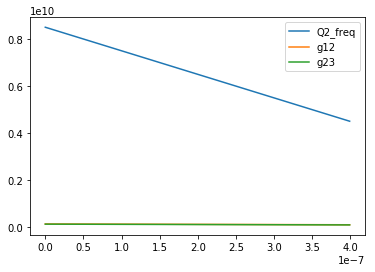

In [5]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.2e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',-0.25e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

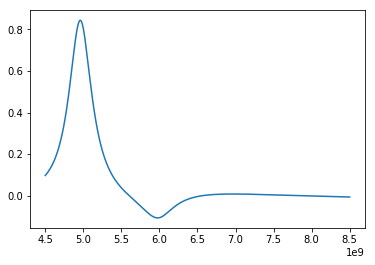

In [6]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)
# Simulator.EigenResult.show_eigenenergy()
eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
plt.plot(freq_array[0:400],eigen_trace[0:400]/1e6)

In [7]:
def get_suppress_point(r1c,r2c,r12,Q1_freq,Q2_freq):
    g12 = r12*np.sqrt(Q1_freq*Q2_freq)
    Qc_arr = np.linspace(Q1_freq+0.4e9,Q1_freq+4e9,361)
    geff_arr = []
    for Qc in Qc_arr:
        g1cg2c = r2c*r1c*np.sqrt(Q1_freq*Q2_freq)*Qc
        geff = g12+g1cg2c/2*(1/(Q1_freq-Qc)+1/(Q2_freq-Qc)-1/(Q1_freq+Qc)-1/(Q2_freq+Qc)   )
        geff_arr.append(geff)
    geff_arr= np.array(geff_arr)
    return Qc_arr[np.argmin( np.abs(geff_arr))]
#     return geff_arr

def r12_zero_geff(w1,w2,wc,r1c,r2c):
    g1cg2c = np.sqrt(w1*wc)*r1c*np.sqrt(w2*wc)*r2c
    g12 = -g1cg2c*(1/(w1-wc)+1/(w2-wc)-1/(w1+wc)-1/(w2+wc))/2
    return g12/(np.sqrt(w1*w2))

In [8]:
get_suppress_point(0.018,0.018,0.0015,6e9,5.4e9)

7630000000.0

In [9]:
def cost_func(pulse_params,*args):
    gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 6.0e9-detuning
    coupler_freq = get_suppress_point(0.018,0.018,0.0015,6e9,q2_freq)

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=6.0e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=coupler_freq-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
#     Seq.add_filter('Reflection',*(0.02,3e-9))
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',coupler_freq)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*coupler_anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    print('lamb:',lamb1)
#     print('error:',1-fidelity)
    return 1 - fidelity

In [10]:
# lamb1=[3]
# gate_time=26e-9
# SRATE=10e9
# # lamb1 = pulse_params
# total_len = gate_time + 16e-9

# Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
# Seq.clear_pulse(tips_on=False)
# Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
#              CPLR_idle_freq=7.87e9,Q2_freq=5.4e9,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=-300e6,
#              anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=6.87e9,gap_threshold=6e6,freqpoints=301,pulsepoints=601)
# Seq.add_filter('Gauss Low Pass',300e6)
# Seq.add_filter('Reflection',*(0.02,3e-9))
# flux_pulse=Seq.get_sequence()
# plt.plot(flux_pulse)

In [40]:
PARAM_ALL = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\PARAM_ALL.txt')
PARAM_ALL

array([[15.55      ,  3.38671875,  2.3203125 , ...,  0.86992187,
         0.87890625,  0.8875    ],
       [16.95      ,  3.39414063,  2.32890625, ...,  0.87890625,
         0.8875    ,  0.89609375],
       [18.54375   ,  3.4015625 ,  2.33710938, ...,  0.88789062,
         0.89609375,  0.90429687],
       ...,
       [-0.7515625 ,  3.9796875 ,  3.05976563, ...,  2.015625  ,
         2.01796875,  2.01992188],
       [-0.475     ,  3.96484375,  3.0453125 , ...,  1.97304688,
         1.97539063,  1.97734375],
       [-0.65078125,  3.95078125,  3.03164063, ...,  1.9375    ,
         1.93984375,  1.94179688]])

In [53]:
np.arange(10e6,1.201e9,10e6)[29]
# PARAM_ALL[0,29]

300000000.0

In [58]:
SRATE=6e9
gate_time=30e-9

# anhar_arr = np.linspace(-800e6,400e6,61)
# detuning_arr = np.linspace(20e6,1.2e9,60)


anhar_arr = np.arange(-800e6,51e6,10e6)
detuning_arr = np.arange(300e6,1.201e9,10e6)

anhar_arr2 = np.arange(-800e6,401e6,10e6)
detuning_arr2 = np.arange(10e6,1.201e9,10e6)

Adia_error=np.zeros([len(anhar_arr2),len(detuning_arr2)])
Adia_lambda=np.zeros([len(anhar_arr2),len(detuning_arr2)])

# raw_initial_seeds=[1]
ii=0
for anhar_coupler in anhar_arr:
    jj=29
    for detuning in detuning_arr:
        time_start = time.time()
        raw_initial_seeds = [PARAM_ALL[ii,jj]]
        DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,anhar_coupler,detuning,SRATE), method='Nelder-Mead', options={'disp': True,'ftol':10e-5,'xtol':10e-5,'maxiter': 16})
#         raw_initial_seeds =[max(DATA.x[0]*0.96,0.6)]  
        Adia_error[ii,jj] = DATA.fun
        Adia_lambda[ii,jj] = DATA.x
        print(time.time()-time_start)
        jj+=1
    ii+=1
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Simu_NonAdiaError.txt',Adia_error)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Simu_Parameters.txt',Adia_lambda)

lamb: [1.07304688]
lamb: [1.12669922]
lamb: [1.01939453]
lamb: [1.0462207]
lamb: [1.01939453]
lamb: [1.05963379]
lamb: [1.03280762]
lamb: [1.05292725]
lamb: [1.05963379]
lamb: [1.04957397]
lamb: [1.0462207]
lamb: [1.05125061]
lamb: [1.05292725]
lamb: [1.05041229]
lamb: [1.04957397]
lamb: [1.05083145]
lamb: [1.04999313]
lamb: [1.04957397]
lamb: [1.04957397]
lamb: [1.05020271]
lamb: [1.05041229]
lamb: [1.05009792]
lamb: [1.05009792]
lamb: [1.0503075]
lamb: [1.05041229]
lamb: [1.05041229]
lamb: [1.05025511]
lamb: [1.05025511]
Optimization terminated successfully.
         Current function value: 0.022523
         Iterations: 13
         Function evaluations: 28
48.84051012992859
lamb: [0.93945312]
lamb: [0.98642578]
lamb: [0.89248047]
lamb: [0.9159668]
lamb: [0.89248047]
lamb: [0.92770996]
lamb: [0.90422363]
lamb: [0.92183838]
lamb: [0.92770996]
lamb: [0.91890259]
lamb: [0.92477417]
lamb: [0.92037048]
lamb: [0.92330627]
lamb: [0.92110443]
lamb: [0.92037048]
lamb: [0.92147141]
lamb: [0.920

lamb: [0.49397461]
lamb: [0.51930664]
lamb: [0.50030762]
lamb: [0.49397461]
lamb: [0.50347412]
lamb: [0.49714111]
lamb: [0.50189087]
lamb: [0.49872437]
lamb: [0.50109924]
lamb: [0.50189087]
lamb: [0.50070343]
lamb: [0.50030762]
lamb: [0.50090134]
lamb: [0.50109924]
lamb: [0.50080238]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 9
         Function evaluations: 18
30.854827880859375
lamb: [0.49921875]
lamb: [0.52417969]
lamb: [0.47425781]
lamb: [0.48673828]
lamb: [0.51169922]
lamb: [0.49297852]
lamb: [0.48673828]
lamb: [0.49609863]
lamb: [0.4898584]
lamb: [0.49453857]
lamb: [0.49141846]
lamb: [0.49375854]
lamb: [0.49453857]
lamb: [0.49336853]
lamb: [0.49297852]
lamb: [0.49356354]
lamb: [0.49375854]
lamb: [0.49346603]
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 9
         Function evaluations: 18
31.01566195487976
lamb: [0.49296875]
lamb: [0.51761719]
lamb: [0.46832031]
lamb: 

lamb: [0.46328125]
lamb: [0.48644531]
lamb: [0.44011719]
lamb: [0.45169922]
lamb: [0.47486328]
lamb: [0.45749023]
lamb: [0.45169922]
lamb: [0.46038574]
lamb: [0.45459473]
lamb: [0.45893799]
lamb: [0.46038574]
lamb: [0.45821411]
lamb: [0.45749023]
lamb: [0.45857605]
lamb: [0.45893799]
lamb: [0.45839508]
lamb: [0.45875702]
lamb: [0.45848557]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
30.986459732055664
lamb: [0.46445312]
lamb: [0.48767578]
lamb: [0.44123047]
lamb: [0.4528418]
lamb: [0.47606445]
lamb: [0.45864746]
lamb: [0.4528418]
lamb: [0.46155029]
lamb: [0.45574463]
lamb: [0.46009888]
lamb: [0.46155029]
lamb: [0.45937317]
lamb: [0.45864746]
lamb: [0.45973602]
lamb: [0.45901031]
lamb: [0.4595546]
lamb: [0.45919174]
lamb: [0.45946388]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
31.37020444869995
lamb: [0

lamb: [0.51348145]
lamb: [0.51429199]
lamb: [0.51368408]
lamb: [0.51408936]
lamb: [0.5137854]
lamb: [0.51398804]
lamb: [0.51383606]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
34.494263648986816
lamb: [0.52460937]
lamb: [0.55083984]
lamb: [0.49837891]
lamb: [0.51149414]
lamb: [0.53772461]
lamb: [0.51805176]
lamb: [0.51149414]
lamb: [0.52133057]
lamb: [0.52460937]
lamb: [0.51969116]
lamb: [0.51805176]
lamb: [0.52051086]
lamb: [0.51887146]
lamb: [0.52010101]
lamb: [0.51928131]
lamb: [0.51989609]
lamb: [0.51948624]
lamb: [0.51979362]
lamb: [0.51989609]
lamb: [0.51974239]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.64003324508667
lamb: [0.53046875]
lamb: [0.55699219]
lamb: [0.50394531]
lamb: [0.51720703]
lamb: [0.54373047]
lamb: [0.52383789]
lamb: [0.51720703]
lamb: [0.52715332]
lamb: [0.53046875]
lamb

lamb: [0.63710937]
lamb: [0.66896484]
lamb: [0.60525391]
lamb: [0.62118164]
lamb: [0.65303711]
lamb: [0.62914551]
lamb: [0.62118164]
lamb: [0.63312744]
lamb: [0.63710937]
lamb: [0.63113647]
lamb: [0.63511841]
lamb: [0.63213196]
lamb: [0.63113647]
lamb: [0.6326297]
lamb: [0.63163422]
lamb: [0.63238083]
lamb: [0.63188309]
lamb: [0.63225639]
lamb: [0.63238083]
lamb: [0.63219418]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.67471766471863
lamb: [0.64609375]
lamb: [0.67839844]
lamb: [0.61378906]
lamb: [0.62994141]
lamb: [0.66224609]
lamb: [0.63801758]
lamb: [0.62994141]
lamb: [0.64205566]
lamb: [0.64609375]
lamb: [0.64003662]
lamb: [0.64407471]
lamb: [0.64104614]
lamb: [0.64003662]
lamb: [0.6415509]
lamb: [0.64054138]
lamb: [0.64129852]
lamb: [0.6415509]
lamb: [0.64117233]
lamb: [0.64104614]
lamb: [0.64123543]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.77997681]
lamb: [0.77814301]
lamb: [0.77936554]
lamb: [0.77844864]
lamb: [0.77814301]
lamb: [0.77860146]
lamb: [0.77829582]
lamb: [0.77852505]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.59577012062073
lamb: [0.79257812]
lamb: [0.83220703]
lamb: [0.75294922]
lamb: [0.77276367]
lamb: [0.81239258]
lamb: [0.7826709]
lamb: [0.80248535]
lamb: [0.78762451]
lamb: [0.7826709]
lamb: [0.79010132]
lamb: [0.78514771]
lamb: [0.78886292]
lamb: [0.79010132]
lamb: [0.78824371]
lamb: [0.78948212]
lamb: [0.78855331]
lamb: [0.78917252]
lamb: [0.78870811]
lamb: [0.78855331]
lamb: [0.78878551]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.664790630340576
lamb: [0.80273437]
lamb: [0.84287109]
lamb: [0.76259766]
lamb: [0.78266602]
lamb: [0.82280273]
lamb: [0.7927002]
lamb: [0.81276855]
lamb: [0.79771729]
lamb: 

lamb: [0.76291199]
lamb: [0.76260864]
lamb: [0.76306366]
lamb: [0.76321533]
lamb: [0.76298782]
Optimization terminated successfully.
         Current function value: 0.001984
         Iterations: 10
         Function evaluations: 20
34.51905941963196
lamb: [0.72421875]
lamb: [0.76042969]
lamb: [0.68800781]
lamb: [0.70611328]
lamb: [0.68800781]
lamb: [0.71516602]
lamb: [0.72421875]
lamb: [0.71063965]
lamb: [0.70611328]
lamb: [0.71290283]
lamb: [0.71516602]
lamb: [0.71177124]
lamb: [0.71403442]
lamb: [0.71233704]
lamb: [0.71346863]
lamb: [0.71261993]
lamb: [0.71318573]
lamb: [0.71276138]
lamb: [0.71261993]
lamb: [0.71283211]
Optimization terminated successfully.
         Current function value: 0.002169
         Iterations: 10
         Function evaluations: 20
40.87921690940857
lamb: [0.6828125]
lamb: [0.71695312]
lamb: [0.64867187]
lamb: [0.66574219]
lamb: [0.64867187]
lamb: [0.67427734]
lamb: [0.6828125]
lamb: [0.67000977]
lamb: [0.67854492]
lamb: [0.67214355]
lamb: [0.67000977]
lamb: 

lamb: [0.47188477]
lamb: [0.49608398]
lamb: [0.47793457]
lamb: [0.47188477]
lamb: [0.48095947]
lamb: [0.47490967]
lamb: [0.47944702]
lamb: [0.47642212]
lamb: [0.4786908]
lamb: [0.47944702]
lamb: [0.47831268]
lamb: [0.47906891]
lamb: [0.47850174]
lamb: [0.47887985]
lamb: [0.47859627]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
31.670919179916382
lamb: [0.48007812]
lamb: [0.50408203]
lamb: [0.45607422]
lamb: [0.46807617]
lamb: [0.49208008]
lamb: [0.47407715]
lamb: [0.46807617]
lamb: [0.47707764]
lamb: [0.47107666]
lamb: [0.47557739]
lamb: [0.4725769]
lamb: [0.47482727]
lamb: [0.47557739]
lamb: [0.47445221]
lamb: [0.47407715]
lamb: [0.47463974]
lamb: [0.47426468]
lamb: [0.47454597]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 9
         Function evaluations: 18
31.722745418548584
lamb: [0.4765625]
lamb: [0.50039062]
lamb: [0.45273437]
lamb: [

lamb: [0.46564674]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
31.34155035018921
lamb: [0.47265625]
lamb: [0.49628906]
lamb: [0.44902344]
lamb: [0.46083984]
lamb: [0.48447266]
lamb: [0.46674805]
lamb: [0.46083984]
lamb: [0.46970215]
lamb: [0.46379395]
lamb: [0.4682251]
lamb: [0.46970215]
lamb: [0.46748657]
lamb: [0.46896362]
lamb: [0.46785583]
lamb: [0.46748657]
lamb: [0.46804047]
lamb: [0.4676712]
lamb: [0.46794815]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
31.915520429611206
lamb: [0.47539062]
lamb: [0.49916016]
lamb: [0.45162109]
lamb: [0.46350586]
lamb: [0.48727539]
lamb: [0.46944824]
lamb: [0.46350586]
lamb: [0.47241943]
lamb: [0.46647705]
lamb: [0.47093384]
lamb: [0.47241943]
lamb: [0.47019104]
lamb: [0.47167664]
lamb: [0.47056244]
lamb: [0.47019104]
lamb: [0.47074814]
lamb: [0.47037674]
lamb: [

lamb: [0.55]
lamb: [0.5775]
lamb: [0.5225]
lamb: [0.53625]
lamb: [0.56375]
lamb: [0.543125]
lamb: [0.53625]
lamb: [0.5465625]
lamb: [0.55]
lamb: [0.54484375]
lamb: [0.543125]
lamb: [0.54570312]
lamb: [0.5465625]
lamb: [0.54527344]
lamb: [0.54484375]
lamb: [0.54548828]
lamb: [0.54505859]
lamb: [0.54538086]
lamb: [0.54548828]
lamb: [0.54532715]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.04409599304199
lamb: [0.55703125]
lamb: [0.58488281]
lamb: [0.52917969]
lamb: [0.54310547]
lamb: [0.57095703]
lamb: [0.55006836]
lamb: [0.54310547]
lamb: [0.5535498]
lamb: [0.55703125]
lamb: [0.55180908]
lamb: [0.55006836]
lamb: [0.55267944]
lamb: [0.5535498]
lamb: [0.55224426]
lamb: [0.55180908]
lamb: [0.55246185]
lamb: [0.55202667]
lamb: [0.55235306]
lamb: [0.55246185]
lamb: [0.55229866]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function

lamb: [0.66751099]
lamb: [0.66909027]
lamb: [0.6696167]
lamb: [0.66882706]
lamb: [0.66935349]
lamb: [0.66895866]
lamb: [0.66882706]
lamb: [0.66902447]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.68236303329468
lamb: [0.68320312]
lamb: [0.71736328]
lamb: [0.64904297]
lamb: [0.66612305]
lamb: [0.7002832]
lamb: [0.67466309]
lamb: [0.66612305]
lamb: [0.67893311]
lamb: [0.68320312]
lamb: [0.6767981]
lamb: [0.68106812]
lamb: [0.6778656]
lamb: [0.68000061]
lamb: [0.67839935]
lamb: [0.6778656]
lamb: [0.67866623]
lamb: [0.67813248]
lamb: [0.67853279]
lamb: [0.67866623]
lamb: [0.67846607]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.68569469451904
lamb: [0.69257812]
lamb: [0.72720703]
lamb: [0.65794922]
lamb: [0.67526367]
lamb: [0.70989258]
lamb: [0.6839209]
lamb: [0.67526367]
lamb: [0.68824951]
lamb: [0.6

lamb: [0.83242187]
lamb: [0.87404297]
lamb: [0.79080078]
lamb: [0.81161133]
lamb: [0.85323242]
lamb: [0.8220166]
lamb: [0.84282715]
lamb: [0.82721924]
lamb: [0.8220166]
lamb: [0.82982056]
lamb: [0.83242187]
lamb: [0.8285199]
lamb: [0.82721924]
lamb: [0.82917023]
lamb: [0.82982056]
lamb: [0.82884506]
lamb: [0.8285199]
lamb: [0.82900764]
lamb: [0.82868248]
lamb: [0.82892635]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.88960099220276
lamb: [0.8421875]
lamb: [0.88429687]
lamb: [0.80007812]
lamb: [0.82113281]
lamb: [0.86324219]
lamb: [0.83166016]
lamb: [0.85271484]
lamb: [0.83692383]
lamb: [0.83166016]
lamb: [0.83955566]
lamb: [0.8421875]
lamb: [0.83823975]
lamb: [0.83692383]
lamb: [0.83889771]
lamb: [0.83955566]
lamb: [0.83856873]
lamb: [0.83823975]
lamb: [0.83873322]
lamb: [0.83840424]
lamb: [0.83865097]
Optimization terminated successfully.
         Current function value: 0.000001
         I

lamb: [0.59189453]
lamb: [0.61525879]
lamb: [0.62304687]
lamb: [0.61136475]
lamb: [0.61915283]
lamb: [0.61331177]
lamb: [0.61720581]
lamb: [0.61428528]
lamb: [0.61331177]
lamb: [0.61477203]
lamb: [0.61525879]
lamb: [0.61452866]
lamb: [0.61501541]
lamb: [0.61465034]
lamb: [0.61489372]
lamb: [0.61471119]
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 10
         Function evaluations: 20
35.03736710548401
lamb: [0.60039062]
lamb: [0.63041016]
lamb: [0.57037109]
lamb: [0.58538086]
lamb: [0.57037109]
lamb: [0.59288574]
lamb: [0.60039062]
lamb: [0.5891333]
lamb: [0.59663818]
lamb: [0.59100952]
lamb: [0.59476196]
lamb: [0.59194763]
lamb: [0.59382385]
lamb: [0.59241669]
lamb: [0.59194763]
lamb: [0.59265121]
lamb: [0.59288574]
lamb: [0.59253395]
lamb: [0.59241669]
lamb: [0.59259258]
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 20
34.85379672050476
lamb:

lamb: [0.49710937]
lamb: [0.44976562]
lamb: [0.46160156]
lamb: [0.48527344]
lamb: [0.46751953]
lamb: [0.46160156]
lamb: [0.47047852]
lamb: [0.46456055]
lamb: [0.46899902]
lamb: [0.46604004]
lamb: [0.46825928]
lamb: [0.46899902]
lamb: [0.4678894]
lamb: [0.46862915]
lamb: [0.46807434]
lamb: [0.4678894]
lamb: [0.46816681]
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 9
         Function evaluations: 18
31.360108852386475
lamb: [0.47148437]
lamb: [0.49505859]
lamb: [0.44791016]
lamb: [0.45969727]
lamb: [0.48327148]
lamb: [0.46559082]
lamb: [0.45969727]
lamb: [0.4685376]
lamb: [0.46264404]
lamb: [0.46706421]
lamb: [0.46411743]
lamb: [0.46632751]
lamb: [0.46706421]
lamb: [0.46595917]
lamb: [0.46669586]
lamb: [0.46614334]
lamb: [0.46595917]
lamb: [0.46623543]
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 9
         Function evaluations: 18
30.83959460258484
lamb: [0.46992187]
lamb: [0

lamb: [0.48081238]
lamb: [0.48109711]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
30.93921208381653
lamb: [0.48945312]
lamb: [0.51392578]
lamb: [0.46498047]
lamb: [0.4772168]
lamb: [0.50168945]
lamb: [0.48333496]
lamb: [0.4772168]
lamb: [0.48639404]
lamb: [0.48027588]
lamb: [0.4848645]
lamb: [0.48639404]
lamb: [0.48409973]
lamb: [0.48562927]
lamb: [0.48524689]
lamb: [0.48448212]
lamb: [0.48467331]
lamb: [0.48505569]
lamb: [0.48476891]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
31.21713161468506
lamb: [0.49375]
lamb: [0.5184375]
lamb: [0.4690625]
lamb: [0.48140625]
lamb: [0.50609375]
lamb: [0.48757812]
lamb: [0.48140625]
lamb: [0.49066406]
lamb: [0.48449219]
lamb: [0.48912109]
lamb: [0.49066406]
lamb: [0.48834961]
lamb: [0.48989258]
lamb: [0.48873535]
lamb: [0.48950684]
lamb: [0.48892822]
lamb: [0.48931

lamb: [0.57477112]
lamb: [0.57296082]
lamb: [0.57431854]
lamb: [0.57477112]
lamb: [0.57409225]
lamb: [0.57454483]
lamb: [0.5742054]
lamb: [0.57443169]
lamb: [0.57426197]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.63957333564758
lamb: [0.58671875]
lamb: [0.61605469]
lamb: [0.55738281]
lamb: [0.57205078]
lamb: [0.60138672]
lamb: [0.57938477]
lamb: [0.57205078]
lamb: [0.58305176]
lamb: [0.58671875]
lamb: [0.58121826]
lamb: [0.57938477]
lamb: [0.58213501]
lamb: [0.58305176]
lamb: [0.58167664]
lamb: [0.58259338]
lamb: [0.58190582]
lamb: [0.5823642]
lamb: [0.58202042]
lamb: [0.58190582]
lamb: [0.58207771]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.7948157787323
lamb: [0.59492187]
lamb: [0.62466797]
lamb: [0.56517578]
lamb: [0.58004883]
lamb: [0.60979492]
lamb: [0.58748535]
lamb: [0.58004883]
lamb: [

lamb: [0.72226562]
lamb: [0.75837891]
lamb: [0.68615234]
lamb: [0.70420898]
lamb: [0.74032227]
lamb: [0.7132373]
lamb: [0.73129395]
lamb: [0.71775146]
lamb: [0.7132373]
lamb: [0.72000854]
lamb: [0.71549438]
lamb: [0.71888]
lamb: [0.71662292]
lamb: [0.71831573]
lamb: [0.71718719]
lamb: [0.7180336]
lamb: [0.71746933]
lamb: [0.71789253]
lamb: [0.7180336]
lamb: [0.717822]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.4572274684906
lamb: [0.73242187]
lamb: [0.76904297]
lamb: [0.69580078]
lamb: [0.71411133]
lamb: [0.75073242]
lamb: [0.7232666]
lamb: [0.71411133]
lamb: [0.72784424]
lamb: [0.73242187]
lamb: [0.72555542]
lamb: [0.73013306]
lamb: [0.72669983]
lamb: [0.72898865]
lamb: [0.72727203]
lamb: [0.72841644]
lamb: [0.72755814]
lamb: [0.72813034]
lamb: [0.72770119]
lamb: [0.72798729]
lamb: [0.72777271]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterat

lamb: [0.86623291]
lamb: [0.86895264]
lamb: [0.86691284]
lamb: [0.86623291]
lamb: [0.86725281]
lamb: [0.86657288]
lamb: [0.86708282]
lamb: [0.86725281]
lamb: [0.86699783]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.686713218688965
lamb: [0.87929687]
lamb: [0.92326172]
lamb: [0.83533203]
lamb: [0.85731445]
lamb: [0.9012793]
lamb: [0.86830566]
lamb: [0.89028809]
lamb: [0.87380127]
lamb: [0.86830566]
lamb: [0.87654907]
lamb: [0.87929687]
lamb: [0.87517517]
lamb: [0.87792297]
lamb: [0.87586212]
lamb: [0.87723602]
lamb: [0.8762056]
lamb: [0.87586212]
lamb: [0.87637733]
lamb: [0.87603386]
lamb: [0.87629147]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.632317304611206
lamb: [0.88789062]
lamb: [0.93228516]
lamb: [0.84349609]
lamb: [0.86569336]
lamb: [0.91008789]
lamb: [0.87679199]
lamb: [0.89898926]
lamb

lamb: [0.55943848]
lamb: [0.5576709]
lamb: [0.55899658]
lamb: [0.55811279]
lamb: [0.55877563]
lamb: [0.55833374]
lamb: [0.55866516]
lamb: [0.55877563]
lamb: [0.55860992]
Optimization terminated successfully.
         Current function value: 0.000198
         Iterations: 10
         Function evaluations: 20
34.5798077583313
lamb: [0.5515625]
lamb: [0.57914062]
lamb: [0.52398437]
lamb: [0.53777344]
lamb: [0.56535156]
lamb: [0.54466797]
lamb: [0.53777344]
lamb: [0.54811523]
lamb: [0.5412207]
lamb: [0.5463916]
lamb: [0.54294434]
lamb: [0.54552979]
lamb: [0.54380615]
lamb: [0.54509888]
lamb: [0.54552979]
lamb: [0.54488342]
lamb: [0.54466797]
lamb: [0.54499115]
lamb: [0.5447757]
lamb: [0.54493729]
Optimization terminated successfully.
         Current function value: 0.000075
         Iterations: 10
         Function evaluations: 20
34.88332176208496
lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53

lamb: [0.46612518]
lamb: [0.46649323]
lamb: [0.46621719]
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 9
         Function evaluations: 18
31.402852058410645
lamb: [0.47070312]
lamb: [0.49423828]
lamb: [0.44716797]
lamb: [0.45893555]
lamb: [0.4824707]
lamb: [0.46481934]
lamb: [0.45893555]
lamb: [0.46776123]
lamb: [0.46187744]
lamb: [0.46629028]
lamb: [0.46776123]
lamb: [0.46555481]
lamb: [0.46481934]
lamb: [0.46592255]
lamb: [0.46518707]
lamb: [0.46573868]
lamb: [0.46592255]
lamb: [0.46564674]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
31.131402730941772
lamb: [0.4703125]
lamb: [0.49382812]
lamb: [0.44679687]
lamb: [0.45855469]
lamb: [0.48207031]
lamb: [0.46443359]
lamb: [0.45855469]
lamb: [0.46737305]
lamb: [0.46149414]
lamb: [0.46590332]
lamb: [0.46737305]
lamb: [0.46516846]
lamb: [0.46443359]
lamb: [0.46553589]
lamb: [0.46590332]
lamb: 

lamb: [0.49587891]
lamb: [0.52130859]
lamb: [0.50223633]
lamb: [0.49587891]
lamb: [0.50541504]
lamb: [0.49905762]
lamb: [0.50382568]
lamb: [0.50541504]
lamb: [0.50303101]
lamb: [0.50462036]
lamb: [0.50342834]
lamb: [0.50422302]
lamb: [0.50362701]
lamb: [0.50402435]
lamb: [0.50372635]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 9
         Function evaluations: 18
84.53045415878296
lamb: [0.51367187]
lamb: [0.53935547]
lamb: [0.48798828]
lamb: [0.50083008]
lamb: [0.52651367]
lamb: [0.50725098]
lamb: [0.50083008]
lamb: [0.51046143]
lamb: [0.51367187]
lamb: [0.5088562]
lamb: [0.50725098]
lamb: [0.50965881]
lamb: [0.50805359]
lamb: [0.50925751]
lamb: [0.5084549]
lamb: [0.50905685]
lamb: [0.50925751]
lamb: [0.50895653]
lamb: [0.50915718]
lamb: [0.50900669]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
109.67799806594849
lamb: [0.51914062]
lamb: 

lamb: [0.60607452]
lamb: [0.60643272]
lamb: [0.60619392]
lamb: [0.60637302]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
73.21307492256165
lamb: [0.61953125]
lamb: [0.65050781]
lamb: [0.58855469]
lamb: [0.60404297]
lamb: [0.63501953]
lamb: [0.61178711]
lamb: [0.60404297]
lamb: [0.61565918]
lamb: [0.61953125]
lamb: [0.61372314]
lamb: [0.61759521]
lamb: [0.61469116]
lamb: [0.61372314]
lamb: [0.61517517]
lamb: [0.61420715]
lamb: [0.61493317]
lamb: [0.61444916]
lamb: [0.61481216]
lamb: [0.61493317]
lamb: [0.61475166]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
73.38995933532715
lamb: [0.628125]
lamb: [0.65953125]
lamb: [0.59671875]
lamb: [0.61242187]
lamb: [0.64382812]
lamb: [0.62027344]
lamb: [0.61242187]
lamb: [0.62419922]
lamb: [0.628125]
lamb: [0.62223633]
lamb: [0.62616211]
lamb: [0.62321777]
lamb: [0

lamb: [0.7625]
lamb: [0.800625]
lamb: [0.724375]
lamb: [0.7434375]
lamb: [0.7815625]
lamb: [0.75296875]
lamb: [0.77203125]
lamb: [0.75773437]
lamb: [0.75296875]
lamb: [0.76011719]
lamb: [0.75535156]
lamb: [0.75892578]
lamb: [0.76011719]
lamb: [0.75833008]
lamb: [0.75773437]
lamb: [0.75862793]
lamb: [0.75803223]
lamb: [0.758479]
lamb: [0.75818115]
lamb: [0.75840454]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
99.55917572975159
lamb: [0.77265625]
lamb: [0.81128906]
lamb: [0.73402344]
lamb: [0.75333984]
lamb: [0.79197266]
lamb: [0.76299805]
lamb: [0.78231445]
lamb: [0.76782715]
lamb: [0.76299805]
lamb: [0.7702417]
lamb: [0.7654126]
lamb: [0.76903442]
lamb: [0.7702417]
lamb: [0.76843079]
lamb: [0.76782715]
lamb: [0.7687326]
lamb: [0.76903442]
lamb: [0.7685817]
lamb: [0.76843079]
lamb: [0.76865715]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 

lamb: [0.90327393]
lamb: [0.90044678]
lamb: [0.90256714]
lamb: [0.90115356]
lamb: [0.90221375]
lamb: [0.90150696]
lamb: [0.90203705]
lamb: [0.90221375]
lamb: [0.9019487]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
49.72376275062561
lamb: [0.9125]
lamb: [0.958125]
lamb: [0.866875]
lamb: [0.8896875]
lamb: [0.9353125]
lamb: [0.90109375]
lamb: [0.92390625]
lamb: [0.90679687]
lamb: [0.91820312]
lamb: [0.90964844]
lamb: [0.90679687]
lamb: [0.91107422]
lamb: [0.90822266]
lamb: [0.91036133]
lamb: [0.90893555]
lamb: [0.91000488]
lamb: [0.91036133]
lamb: [0.90982666]
lamb: [0.91018311]
lamb: [0.90991577]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
48.16401243209839
lamb: [1.07148438]
lamb: [1.12505859]
lamb: [1.01791016]
lamb: [1.04469727]
lamb: [1.01791016]
lamb: [1.05809082]
lamb: [1.03130371]
lamb: [1.051394

lamb: [0.52472168]
lamb: [0.52348022]
lamb: [0.52430786]
lamb: [0.52368713]
lamb: [0.52348022]
lamb: [0.52379059]
lamb: [0.52389404]
lamb: [0.52373886]
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 10
         Function evaluations: 20
61.25710153579712
lamb: [0.5203125]
lamb: [0.54632812]
lamb: [0.49429687]
lamb: [0.50730469]
lamb: [0.53332031]
lamb: [0.51380859]
lamb: [0.50730469]
lamb: [0.51706055]
lamb: [0.51055664]
lamb: [0.51543457]
lamb: [0.51218262]
lamb: [0.51462158]
lamb: [0.51543457]
lamb: [0.51421509]
lamb: [0.51502808]
lamb: [0.51441833]
lamb: [0.51482483]
lamb: [0.51451996]
lamb: [0.51472321]
lamb: [0.51457077]
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 10
         Function evaluations: 20
62.407047748565674
lamb: [0.5125]
lamb: [0.538125]
lamb: [0.486875]
lamb: [0.4996875]
lamb: [0.5253125]
lamb: [0.50609375]
lamb: [0.4996875]
lamb: [0.50929687]
lamb: [0.502890

lamb: [0.47382812]
lamb: [0.49751953]
lamb: [0.45013672]
lamb: [0.46198242]
lamb: [0.48567383]
lamb: [0.46790527]
lamb: [0.46198242]
lamb: [0.4708667]
lamb: [0.46494385]
lamb: [0.46938599]
lamb: [0.4708667]
lamb: [0.46864563]
lamb: [0.46790527]
lamb: [0.46901581]
lamb: [0.46827545]
lamb: [0.46883072]
lamb: [0.46901581]
lamb: [0.46873817]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
56.68952012062073
lamb: [0.47421875]
lamb: [0.49792969]
lamb: [0.45050781]
lamb: [0.46236328]
lamb: [0.48607422]
lamb: [0.46829102]
lamb: [0.46236328]
lamb: [0.47125488]
lamb: [0.46532715]
lamb: [0.46977295]
lamb: [0.47125488]
lamb: [0.46903198]
lamb: [0.47051392]
lamb: [0.46940247]
lamb: [0.46903198]
lamb: [0.46958771]
lamb: [0.46977295]
lamb: [0.46949509]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 9
         Function evaluations: 18
61.89948487281799
lamb: [0

lamb: [0.52626953]
lamb: [0.52460937]
lamb: [0.52709961]
lamb: [0.52543945]
lamb: [0.52668457]
lamb: [0.52709961]
lamb: [0.52647705]
lamb: [0.52626953]
lamb: [0.52658081]
lamb: [0.52637329]
lamb: [0.52652893]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
59.16405010223389
lamb: [0.5375]
lamb: [0.564375]
lamb: [0.510625]
lamb: [0.5240625]
lamb: [0.5509375]
lamb: [0.53078125]
lamb: [0.5240625]
lamb: [0.53414062]
lamb: [0.5375]
lamb: [0.53246094]
lamb: [0.53078125]
lamb: [0.53330078]
lamb: [0.53162109]
lamb: [0.53288086]
lamb: [0.53204102]
lamb: [0.5326709]
lamb: [0.53288086]
lamb: [0.53256592]
lamb: [0.53277588]
lamb: [0.53261841]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
60.79683756828308
lamb: [0.54375]
lamb: [0.5709375]
lamb: [0.5165625]
lamb: [0.53015625]
lamb: [0.55734375]
lamb: [0.53695312]
lamb: 

lamb: [0.65507812]
lamb: [0.68783203]
lamb: [0.62232422]
lamb: [0.63870117]
lamb: [0.67145508]
lamb: [0.64688965]
lamb: [0.63870117]
lamb: [0.65098389]
lamb: [0.65507812]
lamb: [0.64893677]
lamb: [0.65303101]
lamb: [0.64996033]
lamb: [0.64893677]
lamb: [0.65047211]
lamb: [0.65098389]
lamb: [0.65021622]
lamb: [0.650728]
lamb: [0.65034416]
lamb: [0.65021622]
lamb: [0.65040813]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.902345180511475
lamb: [0.66445312]
lamb: [0.69767578]
lamb: [0.63123047]
lamb: [0.6478418]
lamb: [0.68106445]
lamb: [0.65614746]
lamb: [0.6478418]
lamb: [0.66030029]
lamb: [0.66445312]
lamb: [0.65822388]
lamb: [0.66237671]
lamb: [0.65926208]
lamb: [0.65822388]
lamb: [0.65978119]
lamb: [0.66030029]
lamb: [0.65952164]
lamb: [0.65926208]
lamb: [0.65965141]
lamb: [0.65939186]
lamb: [0.65958652]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.80061523]
lamb: [0.79873291]
lamb: [0.79998779]
lamb: [0.79904663]
lamb: [0.79967407]
lamb: [0.79920349]
lamb: [0.79904663]
lamb: [0.79928192]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.86530876159668
lamb: [0.81289062]
lamb: [0.85353516]
lamb: [0.77224609]
lamb: [0.79256836]
lamb: [0.83321289]
lamb: [0.80272949]
lamb: [0.82305176]
lamb: [0.80781006]
lamb: [0.80272949]
lamb: [0.81035034]
lamb: [0.81289062]
lamb: [0.8090802]
lamb: [0.80781006]
lamb: [0.80971527]
lamb: [0.80844513]
lamb: [0.80939774]
lamb: [0.80971527]
lamb: [0.80923897]
lamb: [0.8090802]
lamb: [0.80931835]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.18933916091919
lamb: [0.82304687]
lamb: [0.86419922]
lamb: [0.78189453]
lamb: [0.8024707]
lamb: [0.84362305]
lamb: [0.81275879]
lamb: [0.83333496]
lamb: [0.81790283]
lamb: [

lamb: [0.92085472]
lamb: [0.92122108]
lamb: [0.92112949]
Optimization terminated successfully.
         Current function value: 0.004049
         Iterations: 10
         Function evaluations: 20
37.46991229057312
lamb: [0.8453125]
lamb: [0.88757812]
lamb: [0.80304687]
lamb: [0.82417969]
lamb: [0.80304687]
lamb: [0.83474609]
lamb: [0.8453125]
lamb: [0.82946289]
lamb: [0.82417969]
lamb: [0.83210449]
lamb: [0.82682129]
lamb: [0.83078369]
lamb: [0.83210449]
lamb: [0.83012329]
lamb: [0.83144409]
lamb: [0.83045349]
lamb: [0.83012329]
lamb: [0.83061859]
lamb: [0.83028839]
lamb: [0.83037094]
lamb: [0.83053604]
Optimization terminated successfully.
         Current function value: 0.000653
         Iterations: 10
         Function evaluations: 21
39.16426181793213
lamb: [0.7765625]
lamb: [0.81539062]
lamb: [0.73773437]
lamb: [0.75714844]
lamb: [0.73773437]
lamb: [0.76685547]
lamb: [0.7765625]
lamb: [0.76200195]
lamb: [0.75714844]
lamb: [0.76442871]
lamb: [0.76685547]
lamb: [0.76321533]
lamb: [0

lamb: [0.52623047]
lamb: [0.47611328]
lamb: [0.48864258]
lamb: [0.51370117]
lamb: [0.49490723]
lamb: [0.48864258]
lamb: [0.49803955]
lamb: [0.4917749]
lamb: [0.49647339]
lamb: [0.49803955]
lamb: [0.49569031]
lamb: [0.49490723]
lamb: [0.49608185]
lamb: [0.49647339]
lamb: [0.49588608]
lamb: [0.49569031]
lamb: [0.49598396]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 9
         Function evaluations: 18
35.15160250663757
lamb: [0.49609375]
lamb: [0.52089844]
lamb: [0.47128906]
lamb: [0.48369141]
lamb: [0.50849609]
lamb: [0.48989258]
lamb: [0.48369141]
lamb: [0.49299316]
lamb: [0.48679199]
lamb: [0.49144287]
lamb: [0.49299316]
lamb: [0.49066772]
lamb: [0.48989258]
lamb: [0.4910553]
lamb: [0.49028015]
lamb: [0.49086151]
lamb: [0.49047394]
lamb: [0.49076462]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
34.67514109611511
lamb: [0.49179687]
lamb: [0

lamb: [0.47578781]
lamb: [0.47606956]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
34.42017483711243
lamb: [0.48320312]
lamb: [0.50736328]
lamb: [0.45904297]
lamb: [0.47112305]
lamb: [0.4952832]
lamb: [0.47716309]
lamb: [0.47112305]
lamb: [0.48018311]
lamb: [0.47414307]
lamb: [0.4786731]
lamb: [0.48018311]
lamb: [0.47791809]
lamb: [0.4794281]
lamb: [0.47829559]
lamb: [0.47791809]
lamb: [0.47848434]
lamb: [0.47810684]
lamb: [0.47838997]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 9
         Function evaluations: 18
34.77944350242615
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48137421]
lamb: [0.48080521]
lamb: [0.48

lamb: [0.55285538]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
38.406447410583496
lamb: [0.56445312]
lamb: [0.59267578]
lamb: [0.53623047]
lamb: [0.5503418]
lamb: [0.57856445]
lamb: [0.55739746]
lamb: [0.5503418]
lamb: [0.56092529]
lamb: [0.56445312]
lamb: [0.55916138]
lamb: [0.55739746]
lamb: [0.56004333]
lamb: [0.56092529]
lamb: [0.55960236]
lamb: [0.55916138]
lamb: [0.55982285]
lamb: [0.56004333]
lamb: [0.5597126]
lamb: [0.55993309]
lamb: [0.55976772]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.55700421333313
lamb: [0.571875]
lamb: [0.60046875]
lamb: [0.54328125]
lamb: [0.55757812]
lamb: [0.58617187]
lamb: [0.56472656]
lamb: [0.55757812]
lamb: [0.56830078]
lamb: [0.571875]
lamb: [0.56651367]
lamb: [0.56472656]
lamb: [0.56740723]
lamb: [0.56830078]
lamb: [0.56696045]
lamb: [0.56651367]
lamb: [0.5

lamb: [0.72761719]
lamb: [0.65832031]
lamb: [0.67564453]
lamb: [0.71029297]
lamb: [0.68430664]
lamb: [0.67564453]
lamb: [0.6886377]
lamb: [0.69296875]
lamb: [0.68647217]
lamb: [0.69080322]
lamb: [0.68755493]
lamb: [0.68972046]
lamb: [0.68809631]
lamb: [0.68755493]
lamb: [0.688367]
lamb: [0.6886377]
lamb: [0.68823166]
lamb: [0.68850235]
lamb: [0.68829933]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.92505145072937
lamb: [0.70273437]
lamb: [0.73787109]
lamb: [0.66759766]
lamb: [0.68516602]
lamb: [0.72030273]
lamb: [0.6939502]
lamb: [0.68516602]
lamb: [0.69834229]
lamb: [0.70273437]
lamb: [0.69614624]
lamb: [0.70053833]
lamb: [0.69724426]
lamb: [0.69944031]
lamb: [0.69779327]
lamb: [0.69724426]
lamb: [0.69806778]
lamb: [0.69834229]
lamb: [0.69793053]
lamb: [0.69820503]
lamb: [0.69799915]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
    

lamb: [0.8412616]
lamb: [0.8392868]
lamb: [0.83862854]
lamb: [0.83961594]
lamb: [0.83895767]
lamb: [0.83945137]
lamb: [0.83912224]
lamb: [0.83936909]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.25758957862854
lamb: [0.85234375]
lamb: [0.89496094]
lamb: [0.80972656]
lamb: [0.83103516]
lamb: [0.87365234]
lamb: [0.84168945]
lamb: [0.86299805]
lamb: [0.8470166]
lamb: [0.84168945]
lamb: [0.84968018]
lamb: [0.85234375]
lamb: [0.84834839]
lamb: [0.8470166]
lamb: [0.84901428]
lamb: [0.84968018]
lamb: [0.84868134]
lamb: [0.84934723]
lamb: [0.84884781]
lamb: [0.84918076]
lamb: [0.84893105]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.22271966934204
lamb: [0.86171875]
lamb: [0.90480469]
lamb: [0.81863281]
lamb: [0.84017578]
lamb: [0.88326172]
lamb: [0.85094727]
lamb: [0.87249023]
lamb: [0.85633301]
lamb: [0

lamb: [0.71433975]
lamb: [0.71377304]
lamb: [0.71419807]
lamb: [0.71433975]
lamb: [0.71412724]
Optimization terminated successfully.
         Current function value: 0.002238
         Iterations: 10
         Function evaluations: 20
38.12742495536804
lamb: [0.684375]
lamb: [0.71859375]
lamb: [0.65015625]
lamb: [0.66726562]
lamb: [0.65015625]
lamb: [0.67582031]
lamb: [0.684375]
lamb: [0.67154297]
lamb: [0.68009766]
lamb: [0.67368164]
lamb: [0.67154297]
lamb: [0.67475098]
lamb: [0.67582031]
lamb: [0.67421631]
lamb: [0.67528564]
lamb: [0.67448364]
lamb: [0.67421631]
lamb: [0.67461731]
lamb: [0.67434998]
lamb: [0.67455048]
Optimization terminated successfully.
         Current function value: 0.001108
         Iterations: 10
         Function evaluations: 20
38.62540674209595
lamb: [0.65234375]
lamb: [0.68496094]
lamb: [0.61972656]
lamb: [0.63603516]
lamb: [0.61972656]
lamb: [0.64418945]
lamb: [0.65234375]
lamb: [0.6401123]
lamb: [0.6482666]
lamb: [0.64215088]
lamb: [0.64622803]
lamb: [0.6

lamb: [0.50249023]
lamb: [0.48410645]
lamb: [0.47797852]
lamb: [0.48717041]
lamb: [0.48104248]
lamb: [0.48563843]
lamb: [0.48717041]
lamb: [0.48487244]
lamb: [0.48410645]
lamb: [0.48525543]
lamb: [0.48563843]
lamb: [0.48506393]
lamb: [0.48487244]
lamb: [0.48515968]
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 9
         Function evaluations: 18
34.93161201477051
lamb: [0.4875]
lamb: [0.511875]
lamb: [0.463125]
lamb: [0.4753125]
lamb: [0.4996875]
lamb: [0.48140625]
lamb: [0.4753125]
lamb: [0.48445312]
lamb: [0.47835937]
lamb: [0.48292969]
lamb: [0.48445312]
lamb: [0.48216797]
lamb: [0.48140625]
lamb: [0.48254883]
lamb: [0.48178711]
lamb: [0.4823584]
lamb: [0.48197754]
lamb: [0.48226318]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 9
         Function evaluations: 18
34.26955723762512
lamb: [0.48476562]
lamb: [0.50900391]
lamb: [0.46052734]
lamb: [0.47264648]
lamb: [0.49688477]

lamb: [0.496875]
lamb: [0.52171875]
lamb: [0.47203125]
lamb: [0.48445312]
lamb: [0.50929687]
lamb: [0.49066406]
lamb: [0.48445312]
lamb: [0.49376953]
lamb: [0.48755859]
lamb: [0.4922168]
lamb: [0.49376953]
lamb: [0.49144043]
lamb: [0.49299316]
lamb: [0.49182861]
lamb: [0.49260498]
lamb: [0.49202271]
lamb: [0.49241089]
lamb: [0.49211975]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
34.35174632072449
lamb: [0.50078125]
lamb: [0.52582031]
lamb: [0.47574219]
lamb: [0.48826172]
lamb: [0.51330078]
lamb: [0.49452148]
lamb: [0.48826172]
lamb: [0.49765137]
lamb: [0.50078125]
lamb: [0.49608643]
lamb: [0.49452148]
lamb: [0.4968689]
lamb: [0.49530396]
lamb: [0.49647766]
lamb: [0.49569519]
lamb: [0.49628204]
lamb: [0.49589081]
lamb: [0.49618423]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
35.807262659072876
lamb: [0.

lamb: [0.58217857]
lamb: [0.58235058]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
38.89689898490906
lamb: [0.59492187]
lamb: [0.62466797]
lamb: [0.56517578]
lamb: [0.58004883]
lamb: [0.60979492]
lamb: [0.58748535]
lamb: [0.58004883]
lamb: [0.59120361]
lamb: [0.59492187]
lamb: [0.58934448]
lamb: [0.58748535]
lamb: [0.59027405]
lamb: [0.59120361]
lamb: [0.58980927]
lamb: [0.59073883]
lamb: [0.59004166]
lamb: [0.59050644]
lamb: [0.59015785]
lamb: [0.59039024]
lamb: [0.59021595]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
37.49488925933838
lamb: [0.603125]
lamb: [0.63328125]
lamb: [0.57296875]
lamb: [0.58804687]
lamb: [0.61820312]
lamb: [0.59558594]
lamb: [0.58804687]
lamb: [0.59935547]
lamb: [0.603125]
lamb: [0.5974707]
lamb: [0.59558594]
lamb: [0.59841309]
lamb: [0.59935547]
lamb: [0.59794189]
lamb: [0.

lamb: [0.7328125]
lamb: [0.76945312]
lamb: [0.69617187]
lamb: [0.71449219]
lamb: [0.75113281]
lamb: [0.72365234]
lamb: [0.71449219]
lamb: [0.72823242]
lamb: [0.7328125]
lamb: [0.72594238]
lamb: [0.73052246]
lamb: [0.7270874]
lamb: [0.72937744]
lamb: [0.72765991]
lamb: [0.72880493]
lamb: [0.72794617]
lamb: [0.72851868]
lamb: [0.72808929]
lamb: [0.72837555]
lamb: [0.72816086]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.980355739593506
lamb: [0.74257812]
lamb: [0.77970703]
lamb: [0.70544922]
lamb: [0.72401367]
lamb: [0.76114258]
lamb: [0.7332959]
lamb: [0.75186035]
lamb: [0.73793701]
lamb: [0.7332959]
lamb: [0.74025757]
lamb: [0.73561646]
lamb: [0.73909729]
lamb: [0.73677673]
lamb: [0.73851715]
lamb: [0.73909729]
lamb: [0.73822708]
lamb: [0.73793701]
lamb: [0.73837212]
lamb: [0.73808205]
lamb: [0.73815456]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.88007812]
lamb: [0.87595276]
lamb: [0.878703]
lamb: [0.87664032]
lamb: [0.87801544]
lamb: [0.8769841]
lamb: [0.87664032]
lamb: [0.87715599]
lamb: [0.87732788]
lamb: [0.87707005]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
37.203064918518066
lamb: [0.8890625]
lamb: [0.93351563]
lamb: [0.84460937]
lamb: [0.86683594]
lamb: [0.91128906]
lamb: [0.87794922]
lamb: [0.90017578]
lamb: [0.88350586]
lamb: [0.87794922]
lamb: [0.88628418]
lamb: [0.8890625]
lamb: [0.88489502]
lamb: [0.88767334]
lamb: [0.8855896]
lamb: [0.88697876]
lamb: [0.88593689]
lamb: [0.8855896]
lamb: [0.88611053]
lamb: [0.88628418]
lamb: [0.88602371]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
37.00028038024902
lamb: [0.89726562]
lamb: [0.94212891]
lamb: [0.85240234]
lamb: [0.87483398]
lamb: [0.91969727]
lamb: [0.8860498]
lamb: [0.90

lamb: [0.61921997]
lamb: [0.61848572]
lamb: [0.61897522]
lamb: [0.61860809]
lamb: [0.61848572]
lamb: [0.61866928]
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 10
         Function evaluations: 20
37.9165735244751
lamb: [0.6046875]
lamb: [0.63492187]
lamb: [0.57445312]
lamb: [0.58957031]
lamb: [0.57445312]
lamb: [0.59712891]
lamb: [0.6046875]
lamb: [0.59334961]
lamb: [0.6009082]
lamb: [0.59901855]
lamb: [0.59523926]
lamb: [0.59807373]
lamb: [0.59618408]
lamb: [0.59760132]
lamb: [0.59665649]
lamb: [0.59736511]
lamb: [0.5968927]
lamb: [0.59724701]
lamb: [0.5970108]
lamb: [0.59718796]
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 10
         Function evaluations: 20
38.37581491470337
lamb: [0.58632812]
lamb: [0.61564453]
lamb: [0.55701172]
lamb: [0.57166992]
lamb: [0.60098633]
lamb: [0.57899902]
lamb: [0.57166992]
lamb: [0.58266357]
lamb: [0.57533447]
lamb: [0.5808313]
lamb: [0.57

lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48023621]
lamb: [0.48080521]
lamb: [0.48042587]
lamb: [0.48071037]
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 9
         Function evaluations: 18
34.77547311782837
lamb: [0.48398437]
lamb: [0.50818359]
lamb: [0.45978516]
lamb: [0.47188477]
lamb: [0.49608398]
lamb: [0.47793457]
lamb: [0.47188477]
lamb: [0.48095947]
lamb: [0.47490967]
lamb: [0.47944702]
lamb: [0.48095947]
lamb: [0.4786908]
lamb: [0.48020325]
lamb: [0.47906891]
lamb: [0.4786908]
lamb: [0.47925797]
lamb: [0.47887985]
lamb: [0.47916344]
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 9
         Function evaluations: 18
35.91963744163513
lamb: [0.48320312]
lamb: [0.50736328]
lamb: [0.45904297]
lamb: [0.47112305]
lamb: [0.4952832]
lamb: [0.47716309]
lamb: [0.47112305]
lamb: [0.48018311]
lamb: [0.47414307]
lamb: [0.4786731]
lamb: [0.4

lamb: [0.515625]
lamb: [0.54140625]
lamb: [0.48984375]
lamb: [0.50273437]
lamb: [0.52851562]
lamb: [0.50917969]
lamb: [0.50273437]
lamb: [0.51240234]
lamb: [0.515625]
lamb: [0.51079102]
lamb: [0.50917969]
lamb: [0.51159668]
lamb: [0.50998535]
lamb: [0.51119385]
lamb: [0.51038818]
lamb: [0.51099243]
lamb: [0.5105896]
lamb: [0.51089172]
lamb: [0.51069031]
lamb: [0.51084137]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
39.44233775138855
lamb: [0.52070312]
lamb: [0.54673828]
lamb: [0.49466797]
lamb: [0.50768555]
lamb: [0.5337207]
lamb: [0.51419434]
lamb: [0.50768555]
lamb: [0.51744873]
lamb: [0.52070312]
lamb: [0.51582153]
lamb: [0.51419434]
lamb: [0.51663513]
lamb: [0.51500793]
lamb: [0.51622833]
lamb: [0.51663513]
lamb: [0.51602493]
lamb: [0.51643173]
lamb: [0.51612663]
lamb: [0.51602493]
lamb: [0.51617748]
Optimization terminated successfully.
         Current function value: 0.000006
         I

lamb: [0.61507874]
lamb: [0.61604736]
lamb: [0.61459442]
lamb: [0.61556305]
lamb: [0.61483658]
lamb: [0.61532089]
lamb: [0.61519981]
lamb: [0.61495766]
lamb: [0.6150182]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.23727750778198
lamb: [0.62851562]
lamb: [0.65994141]
lamb: [0.59708984]
lamb: [0.61280273]
lamb: [0.64422852]
lamb: [0.62065918]
lamb: [0.61280273]
lamb: [0.6245874]
lamb: [0.62851562]
lamb: [0.62262329]
lamb: [0.62655151]
lamb: [0.62360535]
lamb: [0.62262329]
lamb: [0.62409637]
lamb: [0.62311432]
lamb: [0.62385086]
lamb: [0.62409637]
lamb: [0.6237281]
lamb: [0.62360535]
lamb: [0.62378948]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.6015088558197
lamb: [0.6375]
lamb: [0.669375]
lamb: [0.605625]
lamb: [0.6215625]
lamb: [0.6534375]
lamb: [0.62953125]
lamb: [0.6215625]
lamb: [0.63351562]


lamb: [0.7734375]
lamb: [0.81210937]
lamb: [0.73476562]
lamb: [0.75410156]
lamb: [0.79277344]
lamb: [0.76376953]
lamb: [0.78310547]
lamb: [0.76860352]
lamb: [0.76376953]
lamb: [0.77102051]
lamb: [0.76618652]
lamb: [0.76981201]
lamb: [0.76739502]
lamb: [0.76920776]
lamb: [0.76981201]
lamb: [0.76890564]
lamb: [0.76950989]
lamb: [0.7690567]
lamb: [0.76935883]
lamb: [0.76913223]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.085124492645264
lamb: [0.78359375]
lamb: [0.82277344]
lamb: [0.74441406]
lamb: [0.76400391]
lamb: [0.80318359]
lamb: [0.77379883]
lamb: [0.79338867]
lamb: [0.77869629]
lamb: [0.77379883]
lamb: [0.78114502]
lamb: [0.77624756]
lamb: [0.77992065]
lamb: [0.78114502]
lamb: [0.77930847]
lamb: [0.77869629]
lamb: [0.77961456]
lamb: [0.77900238]
lamb: [0.77946152]
lamb: [0.77915543]
lamb: [0.77938499]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.90796143]
lamb: [0.91224426]
lamb: [0.90938904]
lamb: [0.91153046]
lamb: [0.91224426]
lamb: [0.91117355]
lamb: [0.91081665]
lamb: [0.91135201]
lamb: [0.9109951]
lamb: [0.91126278]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
39.69604420661926
lamb: [0.92148438]
lamb: [0.96755859]
lamb: [0.87541016]
lamb: [0.89844727]
lamb: [0.94452148]
lamb: [0.90996582]
lamb: [0.93300293]
lamb: [0.9157251]
lamb: [0.92724365]
lamb: [0.91860474]
lamb: [0.9157251]
lamb: [0.92004456]
lamb: [0.91716492]
lamb: [0.91932465]
lamb: [0.91788483]
lamb: [0.91896469]
lamb: [0.91932465]
lamb: [0.91878471]
lamb: [0.91914467]
lamb: [0.9188747]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
46.30630683898926
lamb: [0.92890625]
lamb: [0.97535156]
lamb: [0.88246094]
lamb: [0.90568359]
lamb: [0.95212891]
lamb: [0.91729492]
lamb: [0

lamb: [0.56255493]
lamb: [0.56523376]
lamb: [0.56612671]
lamb: [0.56478729]
lamb: [0.56568024]
lamb: [0.56501053]
lamb: [0.56478729]
lamb: [0.56512215]
lamb: [0.56523376]
lamb: [0.56506634]
Optimization terminated successfully.
         Current function value: 0.000188
         Iterations: 10
         Function evaluations: 20
36.493539810180664
lamb: [0.55820312]
lamb: [0.58611328]
lamb: [0.53029297]
lamb: [0.54424805]
lamb: [0.5721582]
lamb: [0.55122559]
lamb: [0.54424805]
lamb: [0.55471436]
lamb: [0.54773682]
lamb: [0.55296997]
lamb: [0.5494812]
lamb: [0.55209778]
lamb: [0.55296997]
lamb: [0.55166168]
lamb: [0.55253387]
lamb: [0.55187973]
lamb: [0.55231583]
lamb: [0.55198875]
lamb: [0.5522068]
lamb: [0.55204327]
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations: 10
         Function evaluations: 20
38.60765838623047
lamb: [0.54648437]
lamb: [0.57380859]
lamb: [0.51916016]
lamb: [0.53282227]
lamb: [0.56014648]
lamb: [0.53965332]
lamb: 

lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.48175354]
lamb: [0.48061554]
lamb: [0.48023621]
lamb: [0.48080521]
lamb: [0.48042587]
lamb: [0.48071037]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
37.58602595329285
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.48251221]
lamb: [0.48023621]
lamb: [0.47947754]
lamb: [0.48061554]
lamb: [0.48099487]
lamb: [0.48042587]
lamb: [0.48080521]
lamb: [0.48052071]
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 9
         Function evaluations: 18
36.677547216415405
lamb: [0.48554687]
lamb: [0.50982422]
lamb: [0.46126953]
lamb: [0.4734082]
lamb: [0.49768555]
lamb: [0.47947754]
lamb: [0.4734082]
lamb: [0.48251221]
lamb: [0.47644287]
lamb: [0.48099487]
lamb: [0.

lamb: [0.52779438]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
37.5361225605011
lamb: [0.53867187]
lamb: [0.56560547]
lamb: [0.51173828]
lamb: [0.52520508]
lamb: [0.55213867]
lamb: [0.53193848]
lamb: [0.52520508]
lamb: [0.53530518]
lamb: [0.53867187]
lamb: [0.53362183]
lamb: [0.53193848]
lamb: [0.5344635]
lamb: [0.53278015]
lamb: [0.53404266]
lamb: [0.5344635]
lamb: [0.53383224]
lamb: [0.53362183]
lamb: [0.53393745]
lamb: [0.53404266]
lamb: [0.53388485]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
40.30063843727112
lamb: [0.54492187]
lamb: [0.57216797]
lamb: [0.51767578]
lamb: [0.53129883]
lamb: [0.55854492]
lamb: [0.53811035]
lamb: [0.53129883]
lamb: [0.54151611]
lamb: [0.54492187]
lamb: [0.53981323]
lamb: [0.53811035]
lamb: [0.54066467]
lamb: [0.54151611]
lamb: [0.54023895]
lamb: [0.53981323]
lamb: [

lamb: [0.62269531]
lamb: [0.63908203]
lamb: [0.67185547]
lamb: [0.64727539]
lamb: [0.63908203]
lamb: [0.65137207]
lamb: [0.65546875]
lamb: [0.64932373]
lamb: [0.65342041]
lamb: [0.6503479]
lamb: [0.64932373]
lamb: [0.65085999]
lamb: [0.65137207]
lamb: [0.65060394]
lamb: [0.6503479]
lamb: [0.65073196]
lamb: [0.65085999]
lamb: [0.65066795]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
37.950496435165405
lamb: [0.66484375]
lamb: [0.69808594]
lamb: [0.63160156]
lamb: [0.64822266]
lamb: [0.68146484]
lamb: [0.6565332]
lamb: [0.64822266]
lamb: [0.66068848]
lamb: [0.66484375]
lamb: [0.65861084]
lamb: [0.66276611]
lamb: [0.65964966]
lamb: [0.65861084]
lamb: [0.66016907]
lamb: [0.66068848]
lamb: [0.65990936]
lamb: [0.65964966]
lamb: [0.66003922]
lamb: [0.66016907]
lamb: [0.65997429]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function ev

lamb: [0.80139404]
lamb: [0.79950989]
lamb: [0.80076599]
lamb: [0.79982391]
lamb: [0.80045197]
lamb: [0.79998093]
lamb: [0.79982391]
lamb: [0.80005943]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.16889977455139
lamb: [0.8140625]
lamb: [0.85476562]
lamb: [0.77335937]
lamb: [0.79371094]
lamb: [0.83441406]
lamb: [0.80388672]
lamb: [0.82423828]
lamb: [0.80897461]
lamb: [0.80388672]
lamb: [0.81151855]
lamb: [0.80643066]
lamb: [0.81024658]
lamb: [0.81151855]
lamb: [0.8096106]
lamb: [0.81088257]
lamb: [0.80992859]
lamb: [0.81056458]
lamb: [0.81008759]
lamb: [0.81040558]
lamb: [0.81016708]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.51539587974548
lamb: [0.82382812]
lamb: [0.86501953]
lamb: [0.78263672]
lamb: [0.80323242]
lamb: [0.84442383]
lamb: [0.81353027]
lamb: [0.83412598]
lamb: [0.8186792]
lamb: [

lamb: [0.94335937]
lamb: [0.99052734]
lamb: [0.89619141]
lamb: [0.91977539]
lamb: [0.96694336]
lamb: [0.93156738]
lamb: [0.95515137]
lamb: [0.93746338]
lamb: [0.94925537]
lamb: [0.94041138]
lamb: [0.93746338]
lamb: [0.94188538]
lamb: [0.93893738]
lamb: [0.94114838]
lamb: [0.94188538]
lamb: [0.94077988]
lamb: [0.94151688]
lamb: [0.94096413]
lamb: [0.94077988]
lamb: [0.94105625]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
39.12177300453186
lamb: [0.95]
lamb: [0.9975]
lamb: [0.9025]
lamb: [0.92625]
lamb: [0.97375]
lamb: [0.938125]
lamb: [0.961875]
lamb: [0.9440625]
lamb: [0.9559375]
lamb: [0.94703125]
lamb: [0.9440625]
lamb: [0.94851562]
lamb: [0.95]
lamb: [0.94777344]
lamb: [0.94703125]
lamb: [0.94814453]
lamb: [0.94851562]
lamb: [0.94795898]
lamb: [0.94777344]
lamb: [0.94805176]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Func

lamb: [0.52482422]
lamb: [0.55173828]
lamb: [0.53155273]
lamb: [0.52482422]
lamb: [0.53491699]
lamb: [0.52818848]
lamb: [0.53323486]
lamb: [0.53491699]
lamb: [0.5323938]
lamb: [0.53155273]
lamb: [0.53281433]
lamb: [0.53323486]
lamb: [0.53260406]
lamb: [0.5323938]
lamb: [0.5327092]
lamb: [0.53249893]
lamb: [0.53265663]
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 10
         Function evaluations: 20
39.259082555770874
lamb: [0.5296875]
lamb: [0.55617187]
lamb: [0.50320312]
lamb: [0.51644531]
lamb: [0.54292969]
lamb: [0.52306641]
lamb: [0.51644531]
lamb: [0.52637695]
lamb: [0.51975586]
lamb: [0.52472168]
lamb: [0.52637695]
lamb: [0.52389404]
lamb: [0.52306641]
lamb: [0.52430786]
lamb: [0.52348022]
lamb: [0.52410095]
lamb: [0.52430786]
lamb: [0.5239975]
lamb: [0.52389404]
lamb: [0.52404922]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
38.6228

lamb: [0.48678223]
lamb: [0.48448608]
lamb: [0.48601685]
lamb: [0.48486877]
lamb: [0.48448608]
lamb: [0.48506012]
lamb: [0.48467743]
lamb: [0.48496445]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 9
         Function evaluations: 18
36.219642639160156
lamb: [0.49101562]
lamb: [0.51556641]
lamb: [0.46646484]
lamb: [0.47874023]
lamb: [0.50329102]
lamb: [0.48487793]
lamb: [0.47874023]
lamb: [0.48794678]
lamb: [0.48180908]
lamb: [0.48641235]
lamb: [0.48794678]
lamb: [0.48564514]
lamb: [0.48717957]
lamb: [0.48602875]
lamb: [0.48679596]
lamb: [0.48622055]
lamb: [0.48602875]
lamb: [0.48631645]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 9
         Function evaluations: 18
36.214807987213135
lamb: [0.49257812]
lamb: [0.51720703]
lamb: [0.46794922]
lamb: [0.48026367]
lamb: [0.50489258]
lamb: [0.4864209]
lamb: [0.48026367]
lamb: [0.48949951]
lamb: [0.48334229]
lamb: [0.48796021]
lamb:

lamb: [0.55335693]
lamb: [0.55161133]
lamb: [0.55422974]
lamb: [0.55248413]
lamb: [0.55379333]
lamb: [0.55422974]
lamb: [0.55357513]
lamb: [0.55401154]
lamb: [0.55368423]
lamb: [0.55390244]
lamb: [0.55384789]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
40.67373561859131
lamb: [0.565625]
lamb: [0.59390625]
lamb: [0.53734375]
lamb: [0.55148437]
lamb: [0.57976562]
lamb: [0.55855469]
lamb: [0.55148437]
lamb: [0.56208984]
lamb: [0.565625]
lamb: [0.56032227]
lamb: [0.55855469]
lamb: [0.56120605]
lamb: [0.56208984]
lamb: [0.56076416]
lamb: [0.56032227]
lamb: [0.56098511]
lamb: [0.56054321]
lamb: [0.56087463]
lamb: [0.56065369]
lamb: [0.5608194]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
40.389498472213745
lamb: [0.57265625]
lamb: [0.60128906]
lamb: [0.54402344]
lamb: [0.55833984]
lamb: [0.58697266]
lamb: [0

lamb: [0.67912102]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.95905256271362
lamb: [0.69335937]
lamb: [0.72802734]
lamb: [0.65869141]
lamb: [0.67602539]
lamb: [0.71069336]
lamb: [0.68469238]
lamb: [0.67602539]
lamb: [0.68902588]
lamb: [0.69335937]
lamb: [0.68685913]
lamb: [0.69119263]
lamb: [0.6879425]
lamb: [0.69010925]
lamb: [0.68848419]
lamb: [0.68956757]
lamb: [0.68875504]
lamb: [0.68848419]
lamb: [0.68889046]
lamb: [0.68861961]
lamb: [0.68882275]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
40.378071784973145
lamb: [0.703125]
lamb: [0.73828125]
lamb: [0.66796875]
lamb: [0.68554687]
lamb: [0.72070312]
lamb: [0.69433594]
lamb: [0.68554687]
lamb: [0.69873047]
lamb: [0.703125]
lamb: [0.6965332]
lamb: [0.70092773]
lamb: [0.69763184]
lamb: [0.6998291]
lamb: [0.69818115]
lamb: [0.69927979]
lamb: [0.6

lamb: [0.84375]
lamb: [0.8859375]
lamb: [0.8015625]
lamb: [0.82265625]
lamb: [0.86484375]
lamb: [0.83320312]
lamb: [0.85429687]
lamb: [0.83847656]
lamb: [0.83320312]
lamb: [0.84111328]
lamb: [0.84375]
lamb: [0.83979492]
lamb: [0.83847656]
lamb: [0.8404541]
lamb: [0.84111328]
lamb: [0.84012451]
lamb: [0.84078369]
lamb: [0.84028931]
lamb: [0.84012451]
lamb: [0.8403717]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
39.64865255355835
lamb: [0.85351562]
lamb: [0.89619141]
lamb: [0.81083984]
lamb: [0.83217773]
lamb: [0.87485352]
lamb: [0.84284668]
lamb: [0.86418457]
lamb: [0.84818115]
lamb: [0.84284668]
lamb: [0.85084839]
lamb: [0.85351562]
lamb: [0.84951477]
lamb: [0.84818115]
lamb: [0.85018158]
lamb: [0.85084839]
lamb: [0.84984818]
lamb: [0.85051498]
lamb: [0.85001488]
lamb: [0.84984818]
lamb: [0.85009823]
Optimization terminated successfully.
         Current function value: 0.000001
         Itera

lamb: [1.05268433]
lamb: [1.04933716]
lamb: [1.05184753]
lamb: [1.05017395]
lamb: [1.05142914]
lamb: [1.05184753]
lamb: [1.05121994]
lamb: [1.05101074]
lamb: [1.05132454]
lamb: [1.05142914]
lamb: [1.05127224]
lamb: [1.05127224]
Optimization terminated successfully.
         Current function value: 0.020589
         Iterations: 11
         Function evaluations: 23
46.39662027359009
lamb: [0.93867187]
lamb: [0.98560547]
lamb: [0.89173828]
lamb: [0.91520508]
lamb: [0.89173828]
lamb: [0.92693848]
lamb: [0.93867187]
lamb: [0.92107178]
lamb: [0.91520508]
lamb: [0.92400513]
lamb: [0.92693848]
lamb: [0.92253845]
lamb: [0.92107178]
lamb: [0.92327179]
lamb: [0.92180511]
lamb: [0.92217178]
lamb: [0.92290512]
lamb: [0.92235512]
lamb: [0.92272179]
lamb: [0.92290512]
lamb: [0.92290512]
lamb: [0.92263012]
lamb: [0.92263012]
Optimization terminated successfully.
         Current function value: 0.003023
         Iterations: 11
         Function evaluations: 23
48.64059042930603
lamb: [0.846875]
lamb: 

lamb: [0.51805176]
lamb: [0.51928131]
lamb: [0.51969116]
lamb: [0.51907639]
lamb: [0.51887146]
lamb: [0.51917885]
lamb: [0.51928131]
lamb: [0.51912762]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
119.0930826663971
lamb: [0.51796875]
lamb: [0.54386719]
lamb: [0.49207031]
lamb: [0.50501953]
lamb: [0.53091797]
lamb: [0.51149414]
lamb: [0.50501953]
lamb: [0.51473145]
lamb: [0.50825684]
lamb: [0.51311279]
lamb: [0.51473145]
lamb: [0.51230347]
lamb: [0.51392212]
lamb: [0.51270813]
lamb: [0.51230347]
lamb: [0.51291046]
lamb: [0.5125058]
lamb: [0.5128093]
lamb: [0.51260696]
lamb: [0.51275871]
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 10
         Function evaluations: 20
104.40416216850281
lamb: [0.51289062]
lamb: [0.53853516]
lamb: [0.48724609]
lamb: [0.50006836]
lamb: [0.52571289]
lamb: [0.50647949]
lamb: [0.50006836]
lamb: [0.50968506]
lamb:

lamb: [0.49921875]
lamb: [0.52417969]
lamb: [0.47425781]
lamb: [0.48673828]
lamb: [0.51169922]
lamb: [0.49297852]
lamb: [0.48673828]
lamb: [0.49609863]
lamb: [0.4898584]
lamb: [0.49453857]
lamb: [0.49609863]
lamb: [0.49375854]
lamb: [0.4953186]
lamb: [0.49414856]
lamb: [0.49492859]
lamb: [0.49434357]
lamb: [0.49473358]
lamb: [0.49444107]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 9
         Function evaluations: 18
115.84168481826782
lamb: [0.50195312]
lamb: [0.52705078]
lamb: [0.47685547]
lamb: [0.4894043]
lamb: [0.51450195]
lamb: [0.49567871]
lamb: [0.4894043]
lamb: [0.49881592]
lamb: [0.4925415]
lamb: [0.49724731]
lamb: [0.49881592]
lamb: [0.49646301]
lamb: [0.49803162]
lamb: [0.49685516]
lamb: [0.49763947]
lamb: [0.49705124]
lamb: [0.49744339]
lamb: [0.49714928]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 9
         Function evaluations: 18
103.51220297813416
lamb: [0.

lamb: [0.57570709]
lamb: [0.57553703]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
114.42393827438354
lamb: [0.58789062]
lamb: [0.61728516]
lamb: [0.55849609]
lamb: [0.57319336]
lamb: [0.60258789]
lamb: [0.58054199]
lamb: [0.57319336]
lamb: [0.58421631]
lamb: [0.58789062]
lamb: [0.58237915]
lamb: [0.58054199]
lamb: [0.58329773]
lamb: [0.58421631]
lamb: [0.58283844]
lamb: [0.58375702]
lamb: [0.58306808]
lamb: [0.58352737]
lamb: [0.58318291]
lamb: [0.58306808]
lamb: [0.58324032]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
104.92856431007385
lamb: [0.59570312]
lamb: [0.62548828]
lamb: [0.56591797]
lamb: [0.58081055]
lamb: [0.6105957]
lamb: [0.58825684]
lamb: [0.58081055]
lamb: [0.59197998]
lamb: [0.59570312]
lamb: [0.59011841]
lamb: [0.59384155]
lamb: [0.59104919]
lamb: [0.59011841]
lamb: [0.59151459]
lam

lamb: [0.72304687]
lamb: [0.75919922]
lamb: [0.68689453]
lamb: [0.7049707]
lamb: [0.74112305]
lamb: [0.71400879]
lamb: [0.73208496]
lamb: [0.71852783]
lamb: [0.71400879]
lamb: [0.72078735]
lamb: [0.71626831]
lamb: [0.71965759]
lamb: [0.71739807]
lamb: [0.71909271]
lamb: [0.71796295]
lamb: [0.71881027]
lamb: [0.71909271]
lamb: [0.71866905]
lamb: [0.71852783]
lamb: [0.71873966]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
117.30873107910156
lamb: [0.73320312]
lamb: [0.76986328]
lamb: [0.69654297]
lamb: [0.71487305]
lamb: [0.7515332]
lamb: [0.72403809]
lamb: [0.74236816]
lamb: [0.72862061]
lamb: [0.72403809]
lamb: [0.73091187]
lamb: [0.72632935]
lamb: [0.72976624]
lamb: [0.72747498]
lamb: [0.72919342]
lamb: [0.72804779]
lamb: [0.72890701]
lamb: [0.72919342]
lamb: [0.72876381]
lamb: [0.72905022]
lamb: [0.72883541]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.86953979]
lamb: [0.87226562]
lamb: [0.86817688]
lamb: [0.87090271]
lamb: [0.86885834]
lamb: [0.87022125]
lamb: [0.86919907]
lamb: [0.86885834]
lamb: [0.86936943]
lamb: [0.86953979]
lamb: [0.86928425]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
44.65874242782593
lamb: [0.88125]
lamb: [0.9253125]
lamb: [0.8371875]
lamb: [0.85921875]
lamb: [0.90328125]
lamb: [0.87023437]
lamb: [0.89226562]
lamb: [0.87574219]
lamb: [0.87023437]
lamb: [0.87849609]
lamb: [0.88125]
lamb: [0.87711914]
lamb: [0.87987305]
lamb: [0.87780762]
lamb: [0.87918457]
lamb: [0.87815186]
lamb: [0.87884033]
lamb: [0.87832397]
lamb: [0.87815186]
lamb: [0.87841003]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
47.98848748207092
lamb: [0.89023438]
lamb: [0.93474609]
lamb: [0.84572266]
lamb: [0.86797852]
lamb: [0.91249023]
lamb: [0.879

lamb: [0.83336517]
lamb: [0.83204132]
lamb: [0.83303421]
lamb: [0.83336517]
lamb: [0.83286873]
lamb: [0.83319969]
lamb: [0.83336517]
lamb: [0.83336517]
lamb: [0.83311695]
Optimization terminated successfully.
         Current function value: 0.000931
         Iterations: 11
         Function evaluations: 22
48.92501711845398
lamb: [0.77890625]
lamb: [0.81785156]
lamb: [0.73996094]
lamb: [0.75943359]
lamb: [0.73996094]
lamb: [0.76916992]
lamb: [0.77890625]
lamb: [0.76430176]
lamb: [0.77403809]
lamb: [0.76673584]
lamb: [0.76430176]
lamb: [0.76795288]
lamb: [0.7655188]
lamb: [0.76734436]
lamb: [0.76612732]
lamb: [0.7670401]
lamb: [0.76643158]
lamb: [0.76688797]
lamb: [0.7670401]
lamb: [0.7668119]
lamb: [0.7668119]
Optimization terminated successfully.
         Current function value: 0.002877
         Iterations: 10
         Function evaluations: 21
46.71886348724365
lamb: [0.72851562]
lamb: [0.76494141]
lamb: [0.69208984]
lamb: [0.71030273]
lamb: [0.69208984]
lamb: [0.71940918]
lamb: [0.

lamb: [0.5109375]
lamb: [0.53648437]
lamb: [0.48539062]
lamb: [0.49816406]
lamb: [0.52371094]
lamb: [0.50455078]
lamb: [0.49816406]
lamb: [0.50774414]
lamb: [0.50135742]
lamb: [0.50614746]
lamb: [0.50774414]
lamb: [0.50534912]
lamb: [0.50455078]
lamb: [0.50574829]
lamb: [0.50614746]
lamb: [0.50554871]
lamb: [0.50534912]
lamb: [0.5056485]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 9
         Function evaluations: 18
37.216702699661255
lamb: [0.50703125]
lamb: [0.53238281]
lamb: [0.48167969]
lamb: [0.49435547]
lamb: [0.51970703]
lamb: [0.50069336]
lamb: [0.49435547]
lamb: [0.5038623]
lamb: [0.49752441]
lamb: [0.50227783]
lamb: [0.5038623]
lamb: [0.5014856]
lamb: [0.50307007]
lamb: [0.50188171]
lamb: [0.5014856]
lamb: [0.50207977]
lamb: [0.50227783]
lamb: [0.50198074]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 9
         Function evaluations: 18
39.55570936203003
lamb: [0.50

lamb: [0.50556107]
lamb: [0.50595993]
lamb: [0.50566078]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 9
         Function evaluations: 18
32.57957482337952
lamb: [0.51445312]
lamb: [0.54017578]
lamb: [0.48873047]
lamb: [0.5015918]
lamb: [0.52731445]
lamb: [0.50802246]
lamb: [0.5015918]
lamb: [0.51123779]
lamb: [0.50480713]
lamb: [0.50963013]
lamb: [0.51123779]
lamb: [0.50882629]
lamb: [0.51043396]
lamb: [0.50922821]
lamb: [0.51003204]
lamb: [0.50942917]
lamb: [0.50983109]
lamb: [0.50952965]
lamb: [0.50973061]
lamb: [0.50957989]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.919769287109375
lamb: [0.51875]
lamb: [0.5446875]
lamb: [0.4928125]
lamb: [0.50578125]
lamb: [0.53171875]
lamb: [0.51226562]
lamb: [0.50578125]
lamb: [0.51550781]
lamb: [0.51875]
lamb: [0.51388672]
lamb: [0.51226562]
lamb: [0.51469727]
lamb: [0.51307617]
lamb: [0.51429

lamb: [0.61210937]
lamb: [0.64271484]
lamb: [0.58150391]
lamb: [0.59680664]
lamb: [0.62741211]
lamb: [0.60445801]
lamb: [0.59680664]
lamb: [0.60828369]
lamb: [0.61210937]
lamb: [0.60637085]
lamb: [0.61019653]
lamb: [0.60732727]
lamb: [0.60637085]
lamb: [0.60780548]
lamb: [0.60684906]
lamb: [0.60756638]
lamb: [0.60780548]
lamb: [0.60744682]
lamb: [0.60732727]
lamb: [0.6075066]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.17745780944824
lamb: [0.62070312]
lamb: [0.65173828]
lamb: [0.58966797]
lamb: [0.60518555]
lamb: [0.6362207]
lamb: [0.61294434]
lamb: [0.60518555]
lamb: [0.61682373]
lamb: [0.62070312]
lamb: [0.61488403]
lamb: [0.61876343]
lamb: [0.61585388]
lamb: [0.61488403]
lamb: [0.61633881]
lamb: [0.61536896]
lamb: [0.61609634]
lamb: [0.61561142]
lamb: [0.61597511]
lamb: [0.61609634]
lamb: [0.6159145]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.74683838]
lamb: [0.75037231]
lamb: [0.74801636]
lamb: [0.74978333]
lamb: [0.75037231]
lamb: [0.74948883]
lamb: [0.74919434]
lamb: [0.74963608]
lamb: [0.74934158]
lamb: [0.74956245]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.170915603637695
lamb: [0.7640625]
lamb: [0.80226562]
lamb: [0.72585937]
lamb: [0.74496094]
lamb: [0.78316406]
lamb: [0.75451172]
lamb: [0.77361328]
lamb: [0.75928711]
lamb: [0.75451172]
lamb: [0.7616748]
lamb: [0.75689941]
lamb: [0.76048096]
lamb: [0.75809326]
lamb: [0.75988403]
lamb: [0.76048096]
lamb: [0.75958557]
lamb: [0.75928711]
lamb: [0.7597348]
lamb: [0.75988403]
lamb: [0.75966019]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.071799516677856
lamb: [0.77421875]
lamb: [0.81292969]
lamb: [0.73550781]
lamb: [0.75486328]
lamb: [0.79357422]
lamb: [0.76454102]
lamb:

lamb: [0.90742187]
lamb: [0.95279297]
lamb: [0.86205078]
lamb: [0.88473633]
lamb: [0.93010742]
lamb: [0.8960791]
lamb: [0.91876465]
lamb: [0.90175049]
lamb: [0.91309326]
lamb: [0.90458618]
lamb: [0.90175049]
lamb: [0.90600403]
lamb: [0.90316833]
lamb: [0.9052951]
lamb: [0.90387726]
lamb: [0.90494064]
lamb: [0.9052951]
lamb: [0.90476341]
lamb: [0.90458618]
lamb: [0.90485203]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.25773787498474
lamb: [0.91523437]
lamb: [0.96099609]
lamb: [0.86947266]
lamb: [0.89235352]
lamb: [0.93811523]
lamb: [0.90379395]
lamb: [0.9266748]
lamb: [0.90951416]
lamb: [0.92095459]
lamb: [0.91237427]
lamb: [0.90951416]
lamb: [0.91380432]
lamb: [0.91094421]
lamb: [0.91308929]
lamb: [0.91165924]
lamb: [0.91273178]
lamb: [0.91308929]
lamb: [0.91255302]
lamb: [0.91291054]
lamb: [0.9126424]
Optimization terminated successfully.
         Current function value: 0.000005
         

lamb: [0.68945312]
lamb: [0.72392578]
lamb: [0.65498047]
lamb: [0.6722168]
lamb: [0.65498047]
lamb: [0.68083496]
lamb: [0.68945312]
lamb: [0.67652588]
lamb: [0.68514404]
lamb: [0.67868042]
lamb: [0.6829895]
lamb: [0.67975769]
lamb: [0.67868042]
lamb: [0.68029633]
lamb: [0.67921906]
lamb: [0.68002701]
lamb: [0.68029633]
lamb: [0.67989235]
lamb: [0.68016167]
lamb: [0.67995968]
Optimization terminated successfully.
         Current function value: 0.000865
         Iterations: 10
         Function evaluations: 20
35.16970348358154
lamb: [0.65820312]
lamb: [0.69111328]
lamb: [0.62529297]
lamb: [0.64174805]
lamb: [0.62529297]
lamb: [0.64997559]
lamb: [0.65820312]
lamb: [0.64586182]
lamb: [0.65408936]
lamb: [0.6479187]
lamb: [0.65203247]
lamb: [0.64894714]
lamb: [0.65100403]
lamb: [0.64946136]
lamb: [0.65048981]
lamb: [0.64971848]
lamb: [0.6502327]
lamb: [0.64984703]
lamb: [0.64971848]
lamb: [0.64991131]
Optimization terminated successfully.
         Current function value: 0.000333
        

lamb: [0.50307007]
lamb: [0.50188171]
lamb: [0.5014856]
lamb: [0.50207977]
lamb: [0.50168365]
lamb: [0.50198074]
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 9
         Function evaluations: 18
31.3853919506073
lamb: [0.5046875]
lamb: [0.52992187]
lamb: [0.47945312]
lamb: [0.49207031]
lamb: [0.51730469]
lamb: [0.49837891]
lamb: [0.49207031]
lamb: [0.5015332]
lamb: [0.49522461]
lamb: [0.49995605]
lamb: [0.5015332]
lamb: [0.49916748]
lamb: [0.50074463]
lamb: [0.49956177]
lamb: [0.49916748]
lamb: [0.49975891]
lamb: [0.49936462]
lamb: [0.49966034]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 9
         Function evaluations: 18
31.8040030002594
lamb: [0.50273437]
lamb: [0.52787109]
lamb: [0.47759766]
lamb: [0.49016602]
lamb: [0.51530273]
lamb: [0.4964502]
lamb: [0.49016602]
lamb: [0.49959229]
lamb: [0.49330811]
lamb: [0.49802124]
lamb: [0.49959229]
lamb: [0.49723572]
lamb: [0.4988

lamb: [0.5296875]
lamb: [0.55617187]
lamb: [0.50320312]
lamb: [0.51644531]
lamb: [0.54292969]
lamb: [0.52306641]
lamb: [0.51644531]
lamb: [0.52637695]
lamb: [0.5296875]
lamb: [0.52472168]
lamb: [0.52306641]
lamb: [0.52554932]
lamb: [0.52389404]
lamb: [0.5251355]
lamb: [0.52554932]
lamb: [0.52492859]
lamb: [0.52472168]
lamb: [0.52503204]
lamb: [0.5251355]
lamb: [0.52498032]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
34.915183782577515
lamb: [0.53515625]
lamb: [0.56191406]
lamb: [0.50839844]
lamb: [0.52177734]
lamb: [0.54853516]
lamb: [0.5284668]
lamb: [0.52177734]
lamb: [0.53181152]
lamb: [0.53515625]
lamb: [0.53013916]
lamb: [0.5284668]
lamb: [0.53097534]
lamb: [0.52930298]
lamb: [0.53055725]
lamb: [0.53097534]
lamb: [0.53034821]
lamb: [0.53013916]
lamb: [0.53045273]
lamb: [0.53024368]
lamb: [0.53029594]
Optimization terminated successfully.
         Current function value: 0.000003
         

lamb: [0.63329468]
lamb: [0.63229736]
lamb: [0.63379333]
lamb: [0.63279602]
lamb: [0.63354401]
lamb: [0.63304535]
lamb: [0.63341934]
lamb: [0.63354401]
lamb: [0.63335701]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.09358739852905
lamb: [0.64726562]
lamb: [0.67962891]
lamb: [0.61490234]
lamb: [0.63108398]
lamb: [0.66344727]
lamb: [0.6391748]
lamb: [0.63108398]
lamb: [0.64322021]
lamb: [0.64726562]
lamb: [0.64119751]
lamb: [0.64524292]
lamb: [0.64220886]
lamb: [0.64119751]
lamb: [0.64271454]
lamb: [0.64170319]
lamb: [0.6424617]
lamb: [0.64271454]
lamb: [0.64233528]
lamb: [0.64258812]
lamb: [0.64239849]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.224194049835205
lamb: [0.65625]
lamb: [0.6890625]
lamb: [0.6234375]
lamb: [0.63984375]
lamb: [0.67265625]
lamb: [0.64804687]
lamb: [0.63984375]
lamb: [0.6

lamb: [0.79492187]
lamb: [0.83466797]
lamb: [0.75517578]
lamb: [0.77504883]
lamb: [0.81479492]
lamb: [0.78498535]
lamb: [0.8048584]
lamb: [0.78995361]
lamb: [0.78498535]
lamb: [0.79243774]
lamb: [0.78746948]
lamb: [0.79119568]
lamb: [0.79243774]
lamb: [0.79057465]
lamb: [0.79181671]
lamb: [0.79088516]
lamb: [0.79057465]
lamb: [0.79104042]
lamb: [0.7907299]
lamb: [0.79096279]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.007798194885254
lamb: [0.80507812]
lamb: [0.84533203]
lamb: [0.76482422]
lamb: [0.78495117]
lamb: [0.82520508]
lamb: [0.79501465]
lamb: [0.8151416]
lamb: [0.80004639]
lamb: [0.79501465]
lamb: [0.80256226]
lamb: [0.79753052]
lamb: [0.80130432]
lamb: [0.80256226]
lamb: [0.80067535]
lamb: [0.80193329]
lamb: [0.80098984]
lamb: [0.80067535]
lamb: [0.80114708]
lamb: [0.80130432]
lamb: [0.80106846]
Optimization terminated successfully.
         Current function value: 0.000000
      

lamb: [0.92940491]
lamb: [0.92649597]
lamb: [0.92867767]
lamb: [0.92940491]
lamb: [0.92831406]
lamb: [0.92904129]
lamb: [0.92849586]
lamb: [0.92831406]
lamb: [0.92858677]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.05328845977783
lamb: [0.93789062]
lamb: [0.98478516]
lamb: [0.89099609]
lamb: [0.91444336]
lamb: [0.96133789]
lamb: [0.92616699]
lamb: [0.94961426]
lamb: [0.93202881]
lamb: [0.94375244]
lamb: [0.93495972]
lamb: [0.93202881]
lamb: [0.93642517]
lamb: [0.93789062]
lamb: [0.93569244]
lamb: [0.93495972]
lamb: [0.93605881]
lamb: [0.93532608]
lamb: [0.93587563]
lamb: [0.93550926]
lamb: [0.93578403]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.49933934211731
lamb: [0.94492187]
lamb: [0.99216797]
lamb: [0.89767578]
lamb: [0.92129883]
lamb: [0.96854492]
lamb: [0.93311035]
lamb: [0.9567334]
lamb:

lamb: [0.6254541]
lamb: [0.62694092]
lamb: [0.62594971]
lamb: [0.62669312]
lamb: [0.62619751]
lamb: [0.62656921]
lamb: [0.62669312]
lamb: [0.62650726]
Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 10
         Function evaluations: 20
35.16973543167114
lamb: [0.61289062]
lamb: [0.64353516]
lamb: [0.58224609]
lamb: [0.59756836]
lamb: [0.62821289]
lamb: [0.60522949]
lamb: [0.59756836]
lamb: [0.60906006]
lamb: [0.60139893]
lamb: [0.60714478]
lamb: [0.60331421]
lamb: [0.60618713]
lamb: [0.60714478]
lamb: [0.60570831]
lamb: [0.60666595]
lamb: [0.60594772]
lamb: [0.60570831]
lamb: [0.60606743]
lamb: [0.60582802]
lamb: [0.60600758]
Optimization terminated successfully.
         Current function value: 0.000183
         Iterations: 10
         Function evaluations: 20
34.85410284996033
lamb: [0.59570312]
lamb: [0.62548828]
lamb: [0.56591797]
lamb: [0.58081055]
lamb: [0.6105957]
lamb: [0.58825684]
lamb: [0.58081055]
lamb: [0.59197998]
lamb: 

lamb: [0.5046875]
lamb: [0.52992187]
lamb: [0.47945312]
lamb: [0.49207031]
lamb: [0.51730469]
lamb: [0.49837891]
lamb: [0.49207031]
lamb: [0.5015332]
lamb: [0.49522461]
lamb: [0.49995605]
lamb: [0.5015332]
lamb: [0.49916748]
lamb: [0.50074463]
lamb: [0.49956177]
lamb: [0.50035034]
lamb: [0.49975891]
lamb: [0.5001532]
lamb: [0.49985748]
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 9
         Function evaluations: 18
31.874246835708618
lamb: [0.50390625]
lamb: [0.52910156]
lamb: [0.47871094]
lamb: [0.49130859]
lamb: [0.51650391]
lamb: [0.49760742]
lamb: [0.49130859]
lamb: [0.50075684]
lamb: [0.49445801]
lamb: [0.49918213]
lamb: [0.50075684]
lamb: [0.49839478]
lamb: [0.49996948]
lamb: [0.49878845]
lamb: [0.49839478]
lamb: [0.49898529]
lamb: [0.49918213]
lamb: [0.49888687]
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 9
         Function evaluations: 18
31.863507509231567
lamb: [0

lamb: [0.54765625]
lamb: [0.57503906]
lamb: [0.52027344]
lamb: [0.53396484]
lamb: [0.56134766]
lamb: [0.54081055]
lamb: [0.53396484]
lamb: [0.5442334]
lamb: [0.54765625]
lamb: [0.54252197]
lamb: [0.54081055]
lamb: [0.54337769]
lamb: [0.54166626]
lamb: [0.54294983]
lamb: [0.54337769]
lamb: [0.5427359]
lamb: [0.54252197]
lamb: [0.54284286]
lamb: [0.54294983]
lamb: [0.54278938]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
34.98921823501587
lamb: [0.55390625]
lamb: [0.58160156]
lamb: [0.52621094]
lamb: [0.54005859]
lamb: [0.56775391]
lamb: [0.54698242]
lamb: [0.54005859]
lamb: [0.55044434]
lamb: [0.55390625]
lamb: [0.54871338]
lamb: [0.54698242]
lamb: [0.54957886]
lamb: [0.5478479]
lamb: [0.54914612]
lamb: [0.54957886]
lamb: [0.54892975]
lamb: [0.54871338]
lamb: [0.54903793]
lamb: [0.54914612]
lamb: [0.54898384]
Optimization terminated successfully.
         Current function value: 0.000009
       

lamb: [0.66393433]
lamb: [0.66081238]
lamb: [0.65977173]
lamb: [0.6613327]
lamb: [0.66185303]
lamb: [0.66107254]
lamb: [0.66081238]
lamb: [0.66120262]
lamb: [0.66094246]
lamb: [0.66113758]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.556777477264404
lamb: [0.675]
lamb: [0.70875]
lamb: [0.64125]
lamb: [0.658125]
lamb: [0.691875]
lamb: [0.6665625]
lamb: [0.658125]
lamb: [0.67078125]
lamb: [0.675]
lamb: [0.66867187]
lamb: [0.67289062]
lamb: [0.66972656]
lamb: [0.67183594]
lamb: [0.67025391]
lamb: [0.66972656]
lamb: [0.67051758]
lamb: [0.67078125]
lamb: [0.67038574]
lamb: [0.67064941]
lamb: [0.67045166]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.21470808982849
lamb: [0.68476562]
lamb: [0.71900391]
lamb: [0.65052734]
lamb: [0.66764648]
lamb: [0.70188477]
lamb: [0.67620605]
lamb: [0.66764648]
lamb: [0

lamb: [0.82539062]
lamb: [0.86666016]
lamb: [0.78412109]
lamb: [0.80475586]
lamb: [0.84602539]
lamb: [0.81507324]
lamb: [0.83570801]
lamb: [0.82023193]
lamb: [0.81507324]
lamb: [0.82281128]
lamb: [0.82539062]
lamb: [0.82152161]
lamb: [0.82023193]
lamb: [0.82216644]
lamb: [0.82087677]
lamb: [0.82184402]
lamb: [0.82216644]
lamb: [0.82168282]
lamb: [0.82200523]
lamb: [0.82176342]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.4899582862854
lamb: [0.83554687]
lamb: [0.87732422]
lamb: [0.79376953]
lamb: [0.8146582]
lamb: [0.85643555]
lamb: [0.82510254]
lamb: [0.84599121]
lamb: [0.83032471]
lamb: [0.82510254]
lamb: [0.83293579]
lamb: [0.83554687]
lamb: [0.83163025]
lamb: [0.83032471]
lamb: [0.83228302]
lamb: [0.83097748]
lamb: [0.83195663]
lamb: [0.83228302]
lamb: [0.83179344]
lamb: [0.83211983]
lamb: [0.83187504]
Optimization terminated successfully.
         Current function value: 0.000001
      

lamb: [0.95011169]
lamb: [0.94936768]
lamb: [0.9504837]
lamb: [0.94973969]
lamb: [0.9502977]
lamb: [0.94992569]
lamb: [0.95001869]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.295300006866455
lamb: [0.95859375]
lamb: [1.00652344]
lamb: [0.91066406]
lamb: [0.93462891]
lamb: [0.98255859]
lamb: [0.94661133]
lamb: [0.97057617]
lamb: [0.95260254]
lamb: [0.96458496]
lamb: [0.95559814]
lamb: [0.95260254]
lamb: [0.95709595]
lamb: [0.95859375]
lamb: [0.95634705]
lamb: [0.95559814]
lamb: [0.9567215]
lamb: [0.95709595]
lamb: [0.95653427]
lamb: [0.95690872]
lamb: [0.95662788]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
34.86756706237793
lamb: [0.96523437]
lamb: [1.01349609]
lamb: [0.91697266]
lamb: [0.94110352]
lamb: [0.98936523]
lamb: [0.95316895]
lamb: [0.9772998]
lamb: [0.95920166]
lamb: [0.97126709]
lamb: [

lamb: [0.59106102]
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 10
         Function evaluations: 20
35.26669764518738
lamb: [0.5828125]
lamb: [0.61195312]
lamb: [0.55367187]
lamb: [0.56824219]
lamb: [0.59738281]
lamb: [0.57552734]
lamb: [0.56824219]
lamb: [0.57916992]
lamb: [0.57188477]
lamb: [0.57734863]
lamb: [0.57916992]
lamb: [0.57643799]
lamb: [0.57552734]
lamb: [0.57689331]
lamb: [0.57598267]
lamb: [0.57666565]
lamb: [0.57621033]
lamb: [0.57655182]
lamb: [0.57632416]
lamb: [0.5764949]
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 10
         Function evaluations: 20
35.296658754348755
lamb: [0.5703125]
lamb: [0.59882812]
lamb: [0.54179687]
lamb: [0.55605469]
lamb: [0.58457031]
lamb: [0.56318359]
lamb: [0.55605469]
lamb: [0.56674805]
lamb: [0.55961914]
lamb: [0.56496582]
lamb: [0.56674805]
lamb: [0.56407471]
lamb: [0.56318359]
lamb: [0.56452026]
lamb: [0.56496582]
lamb: 

lamb: [0.50069336]
lamb: [0.50307007]
lamb: [0.5014856]
lamb: [0.50267395]
lamb: [0.50188171]
lamb: [0.50247589]
lamb: [0.50267395]
lamb: [0.50237686]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 9
         Function evaluations: 18
31.615516424179077
lamb: [0.50703125]
lamb: [0.53238281]
lamb: [0.48167969]
lamb: [0.49435547]
lamb: [0.51970703]
lamb: [0.50069336]
lamb: [0.49435547]
lamb: [0.5038623]
lamb: [0.50703125]
lamb: [0.50227783]
lamb: [0.50069336]
lamb: [0.50307007]
lamb: [0.5014856]
lamb: [0.50267395]
lamb: [0.50188171]
lamb: [0.50247589]
lamb: [0.50207977]
lamb: [0.50237686]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 9
         Function evaluations: 18
31.18738031387329
lamb: [0.5078125]
lamb: [0.53320312]
lamb: [0.48242187]
lamb: [0.49511719]
lamb: [0.52050781]
lamb: [0.50146484]
lamb: [0.49511719]
lamb: [0.50463867]
lamb: [0.49829102]
lamb: [0.50305176]
lamb: [0.

lamb: [0.55338867]
lamb: [0.58176758]
lamb: [0.5604834]
lamb: [0.55338867]
lamb: [0.56403076]
lamb: [0.56757812]
lamb: [0.56225708]
lamb: [0.5604834]
lamb: [0.56314392]
lamb: [0.56403076]
lamb: [0.5627005]
lamb: [0.56358734]
lamb: [0.56292221]
lamb: [0.5627005]
lamb: [0.56303307]
lamb: [0.56281136]
lamb: [0.56297764]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
34.974437952041626
lamb: [0.57460937]
lamb: [0.60333984]
lamb: [0.54587891]
lamb: [0.56024414]
lamb: [0.58897461]
lamb: [0.56742676]
lamb: [0.56024414]
lamb: [0.57101807]
lamb: [0.57460937]
lamb: [0.56922241]
lamb: [0.56742676]
lamb: [0.57012024]
lamb: [0.57101807]
lamb: [0.56967133]
lamb: [0.56922241]
lamb: [0.56989578]
lamb: [0.57012024]
lamb: [0.56978355]
lamb: [0.57000801]
lamb: [0.56983967]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.075

lamb: [0.69127563]
lamb: [0.68964783]
lamb: [0.69073303]
lamb: [0.68991913]
lamb: [0.68964783]
lamb: [0.69005478]
lamb: [0.69019043]
lamb: [0.68998695]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.64369344711304
lamb: [0.7046875]
lamb: [0.73992187]
lamb: [0.66945312]
lamb: [0.68707031]
lamb: [0.72230469]
lamb: [0.69587891]
lamb: [0.68707031]
lamb: [0.7002832]
lamb: [0.7046875]
lamb: [0.69808105]
lamb: [0.70248535]
lamb: [0.69918213]
lamb: [0.70138428]
lamb: [0.69973267]
lamb: [0.69918213]
lamb: [0.70000793]
lamb: [0.7002832]
lamb: [0.6998703]
lamb: [0.70014557]
lamb: [0.69993912]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.4256477355957
lamb: [0.71445312]
lamb: [0.75017578]
lamb: [0.67873047]
lamb: [0.6965918]
lamb: [0.73231445]
lamb: [0.70552246]
lamb: [0.6965918]
lamb: [0.70998779]
lamb: [0.714

lamb: [0.85507812]
lamb: [0.89783203]
lamb: [0.81232422]
lamb: [0.83370117]
lamb: [0.87645508]
lamb: [0.84438965]
lamb: [0.8657666]
lamb: [0.84973389]
lamb: [0.84438965]
lamb: [0.85240601]
lamb: [0.85507812]
lamb: [0.85106995]
lamb: [0.85374207]
lamb: [0.85173798]
lamb: [0.85106995]
lamb: [0.85207199]
lamb: [0.85240601]
lamb: [0.85190498]
lamb: [0.85173798]
lamb: [0.85198849]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.251941204071045
lamb: [0.86484375]
lamb: [0.90808594]
lamb: [0.82160156]
lamb: [0.84322266]
lamb: [0.88646484]
lamb: [0.8540332]
lamb: [0.8756543]
lamb: [0.85943848]
lamb: [0.8540332]
lamb: [0.86214111]
lamb: [0.86484375]
lamb: [0.86078979]
lamb: [0.86349243]
lamb: [0.86146545]
lamb: [0.86078979]
lamb: [0.86180328]
lamb: [0.86112762]
lamb: [0.86163437]
lamb: [0.86129654]
lamb: [0.86154991]
Optimization terminated successfully.
         Current function value: 0.000001
       

lamb: [0.96580078]
lamb: [0.97035645]
lamb: [0.971875]
lamb: [0.96959717]
lamb: [0.96883789]
lamb: [0.96997681]
lamb: [0.96921753]
lamb: [0.96978699]
lamb: [0.96997681]
lamb: [0.96969208]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.78401279449463
lamb: [0.97734375]
lamb: [1.02621094]
lamb: [0.92847656]
lamb: [0.95291016]
lamb: [1.00177734]
lamb: [0.96512695]
lamb: [0.98956055]
lamb: [0.97123535]
lamb: [0.98345215]
lamb: [0.97428955]
lamb: [0.97123535]
lamb: [0.97581665]
lamb: [0.97734375]
lamb: [0.9750531]
lamb: [0.9765802]
lamb: [0.97543488]
lamb: [0.9750531]
lamb: [0.97562576]
lamb: [0.97581665]
lamb: [0.97553032]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.36419081687927
lamb: [0.98320312]
lamb: [1.03236328]
lamb: [0.93404297]
lamb: [0.95862305]
lamb: [1.0077832]
lamb: [0.97091309]
lamb: [0.9

lamb: [0.56672836]
lamb: [0.56695206]
lamb: [0.56678429]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
35.516435384750366
lamb: [0.56171875]
lamb: [0.58980469]
lamb: [0.53363281]
lamb: [0.54767578]
lamb: [0.57576172]
lamb: [0.55469727]
lamb: [0.54767578]
lamb: [0.55820801]
lamb: [0.55118652]
lamb: [0.55645264]
lamb: [0.55820801]
lamb: [0.55557495]
lamb: [0.55733032]
lamb: [0.55601379]
lamb: [0.55557495]
lamb: [0.55623322]
lamb: [0.55645264]
lamb: [0.5561235]
lamb: [0.55601379]
lamb: [0.55617836]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 10
         Function evaluations: 20
35.504417419433594
lamb: [0.55273437]
lamb: [0.58037109]
lamb: [0.52509766]
lamb: [0.53891602]
lamb: [0.56655273]
lamb: [0.5458252]
lamb: [0.53891602]
lamb: [0.54927979]
lamb: [0.54237061]
lamb: [0.54755249]
lamb: [0.54927979]
lamb: [0.54668884]
lamb: [0.54841614]
lamb

lamb: [0.50570801]
lamb: [0.49930664]
lamb: [0.50890869]
lamb: [0.50250732]
lamb: [0.50730835]
lamb: [0.50890869]
lamb: [0.50650818]
lamb: [0.50810852]
lamb: [0.50690826]
lamb: [0.50770844]
lamb: [0.50710831]
lamb: [0.50750839]
lamb: [0.50720833]
lamb: [0.50740837]
lamb: [0.50725834]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.15361046791077
lamb: [0.51328125]
lamb: [0.53894531]
lamb: [0.48761719]
lamb: [0.50044922]
lamb: [0.52611328]
lamb: [0.50686523]
lamb: [0.50044922]
lamb: [0.51007324]
lamb: [0.51328125]
lamb: [0.50846924]
lamb: [0.50686523]
lamb: [0.50927124]
lamb: [0.50766724]
lamb: [0.50887024]
lamb: [0.50806824]
lamb: [0.50866974]
lamb: [0.50887024]
lamb: [0.50856949]
lamb: [0.50876999]
lamb: [0.50861961]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.22206377983093
lamb: [0.51523437]
lamb

lamb: [0.57696167]
lamb: [0.5776442]
lamb: [0.5778717]
lamb: [0.57753044]
lamb: [0.57775795]
lamb: [0.57770107]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.04671502113342
lamb: [0.58984375]
lamb: [0.61933594]
lamb: [0.56035156]
lamb: [0.57509766]
lamb: [0.60458984]
lamb: [0.5824707]
lamb: [0.57509766]
lamb: [0.58615723]
lamb: [0.58984375]
lamb: [0.58431396]
lamb: [0.5824707]
lamb: [0.5852356]
lamb: [0.58615723]
lamb: [0.58477478]
lamb: [0.58569641]
lamb: [0.58500519]
lamb: [0.585466]
lamb: [0.58512039]
lamb: [0.58500519]
lamb: [0.58517799]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.30544948577881
lamb: [0.59765625]
lamb: [0.62753906]
lamb: [0.56777344]
lamb: [0.58271484]
lamb: [0.61259766]
lamb: [0.59018555]
lamb: [0.58271484]
lamb: [0.5939209]
lamb: [0.59765625]
lamb: [0.59205322]
lamb: [0.590

lamb: [0.72460937]
lamb: [0.76083984]
lamb: [0.68837891]
lamb: [0.70649414]
lamb: [0.74272461]
lamb: [0.71555176]
lamb: [0.73366699]
lamb: [0.72008057]
lamb: [0.71555176]
lamb: [0.72234497]
lamb: [0.71781616]
lamb: [0.72121277]
lamb: [0.71894836]
lamb: [0.72064667]
lamb: [0.71951447]
lamb: [0.72036362]
lamb: [0.71979752]
lamb: [0.72022209]
lamb: [0.72036362]
lamb: [0.72015133]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.22847366333008
lamb: [0.73476562]
lamb: [0.77150391]
lamb: [0.69802734]
lamb: [0.71639648]
lamb: [0.75313477]
lamb: [0.72558105]
lamb: [0.7439502]
lamb: [0.73017334]
lamb: [0.72558105]
lamb: [0.73246948]
lamb: [0.7278772]
lamb: [0.73132141]
lamb: [0.72902527]
lamb: [0.73074738]
lamb: [0.7295993]
lamb: [0.73046036]
lamb: [0.73074738]
lamb: [0.73031685]
lamb: [0.73017334]
lamb: [0.7303886]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.87460937]
lamb: [0.87050964]
lamb: [0.8732428]
lamb: [0.87119293]
lamb: [0.87050964]
lamb: [0.87153458]
lamb: [0.87187622]
lamb: [0.87136375]
lamb: [0.8717054]
lamb: [0.87144917]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.09574770927429
lamb: [0.88359375]
lamb: [0.92777344]
lamb: [0.83941406]
lamb: [0.86150391]
lamb: [0.90568359]
lamb: [0.87254883]
lamb: [0.89463867]
lamb: [0.87807129]
lamb: [0.87254883]
lamb: [0.88083252]
lamb: [0.88359375]
lamb: [0.8794519]
lamb: [0.88221313]
lamb: [0.88014221]
lamb: [0.88152283]
lamb: [0.88048737]
lamb: [0.88014221]
lamb: [0.88065994]
lamb: [0.88083252]
lamb: [0.88057365]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.763941049575806
lamb: [0.89257812]
lamb: [0.93720703]
lamb: [0.84794922]
lamb: [0.87026367]
lamb: [0.91489258]
lamb: [0.8814209]
lamb: [

lamb: [0.9890625]
lamb: [1.03851563]
lamb: [0.93960938]
lamb: [0.96433594]
lamb: [1.01378906]
lamb: [0.97669922]
lamb: [1.00142578]
lamb: [0.98288086]
lamb: [0.99524414]
lamb: [0.98597168]
lamb: [0.98288086]
lamb: [0.98751709]
lamb: [0.9890625]
lamb: [0.98674438]
lamb: [0.98828979]
lamb: [0.98713074]
lamb: [0.98674438]
lamb: [0.98732391]
lamb: [0.98751709]
lamb: [0.98722733]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.10185360908508
lamb: [0.99453125]
lamb: [1.04425781]
lamb: [0.94480469]
lamb: [0.96966797]
lamb: [1.01939453]
lamb: [0.98209961]
lamb: [1.00696289]
lamb: [0.98831543]
lamb: [1.00074707]
lamb: [0.99142334]
lamb: [0.98831543]
lamb: [0.99297729]
lamb: [0.99453125]
lamb: [0.99220032]
lamb: [0.99142334]
lamb: [0.99258881]
lamb: [0.99297729]
lamb: [0.99239456]
lamb: [0.99278305]
lamb: [0.99249168]
Optimization terminated successfully.
         Current function value: 0.000011
      

lamb: [0.55238525]
lamb: [0.54543701]
lamb: [0.55064819]
lamb: [0.55238525]
lamb: [0.54977966]
lamb: [0.54891113]
lamb: [0.55021393]
lamb: [0.55064819]
lamb: [0.5499968]
lamb: [0.55043106]
lamb: [0.55010536]
lamb: [0.55032249]
lamb: [0.55015965]
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 10
         Function evaluations: 20
35.11420965194702
lamb: [0.54765625]
lamb: [0.57503906]
lamb: [0.52027344]
lamb: [0.53396484]
lamb: [0.56134766]
lamb: [0.54081055]
lamb: [0.53396484]
lamb: [0.5442334]
lamb: [0.5373877]
lamb: [0.54252197]
lamb: [0.5442334]
lamb: [0.54166626]
lamb: [0.54337769]
lamb: [0.54209412]
lamb: [0.54294983]
lamb: [0.54230804]
lamb: [0.5427359]
lamb: [0.54241501]
lamb: [0.54230804]
lamb: [0.54246849]
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 10
         Function evaluations: 20
34.931493282318115
lamb: [0.54140625]
lamb: [0.56847656]
lamb: [0.51433594]
lamb: [0

lamb: [0.51341629]
lamb: [0.51321396]
lamb: [0.51336571]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.20857262611389
lamb: [0.51992187]
lamb: [0.54591797]
lamb: [0.49392578]
lamb: [0.50692383]
lamb: [0.53291992]
lamb: [0.51342285]
lamb: [0.50692383]
lamb: [0.51667236]
lamb: [0.51992187]
lamb: [0.51504761]
lamb: [0.51342285]
lamb: [0.51585999]
lamb: [0.51423523]
lamb: [0.5154538]
lamb: [0.51585999]
lamb: [0.5152507]
lamb: [0.51565689]
lamb: [0.51535225]
lamb: [0.5152507]
lamb: [0.51540302]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
35.209964990615845
lamb: [0.52304687]
lamb: [0.54919922]
lamb: [0.49689453]
lamb: [0.5099707]
lamb: [0.53612305]
lamb: [0.51650879]
lamb: [0.5099707]
lamb: [0.51977783]
lamb: [0.52304687]
lamb: [0.51814331]
lamb: [0.51650879]
lamb: [0.51896057]
lamb: [0.51732605]
lamb: [0

lamb: [0.5759375]
lamb: [0.59109375]
lamb: [0.62140625]
lamb: [0.59867187]
lamb: [0.59109375]
lamb: [0.60246094]
lamb: [0.60625]
lamb: [0.60056641]
lamb: [0.59867187]
lamb: [0.60151367]
lamb: [0.60246094]
lamb: [0.60104004]
lamb: [0.6019873]
lamb: [0.60127686]
lamb: [0.60104004]
lamb: [0.60139526]
lamb: [0.60115845]
lamb: [0.60133606]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.033167362213135
lamb: [0.6140625]
lamb: [0.64476562]
lamb: [0.58335937]
lamb: [0.59871094]
lamb: [0.62941406]
lamb: [0.60638672]
lamb: [0.59871094]
lamb: [0.61022461]
lamb: [0.6140625]
lamb: [0.60830566]
lamb: [0.61214355]
lamb: [0.60926514]
lamb: [0.60830566]
lamb: [0.60974487]
lamb: [0.6087854]
lamb: [0.609505]
lamb: [0.60902527]
lamb: [0.60938507]
lamb: [0.609505]
lamb: [0.6093251]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations:

lamb: [0.74123657]
lamb: [0.74181885]
lamb: [0.74094543]
lamb: [0.7406543]
lamb: [0.741091]
lamb: [0.74079987]
lamb: [0.74101822]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.218138217926025
lamb: [0.75546875]
lamb: [0.79324219]
lamb: [0.71769531]
lamb: [0.73658203]
lamb: [0.77435547]
lamb: [0.74602539]
lamb: [0.76491211]
lamb: [0.75074707]
lamb: [0.74602539]
lamb: [0.75310791]
lamb: [0.74838623]
lamb: [0.75192749]
lamb: [0.74956665]
lamb: [0.75133728]
lamb: [0.75192749]
lamb: [0.75104218]
lamb: [0.75074707]
lamb: [0.75118973]
lamb: [0.75133728]
lamb: [0.75111595]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.885910987854004
lamb: [0.765625]
lamb: [0.80390625]
lamb: [0.72734375]
lamb: [0.74648437]
lamb: [0.78476562]
lamb: [0.75605469]
lamb: [0.77519531]
lamb: [0.76083984]
lamb: [0.75605469]
lamb: [

lamb: [0.9015625]
lamb: [0.94664063]
lamb: [0.85648437]
lamb: [0.87902344]
lamb: [0.92410156]
lamb: [0.89029297]
lamb: [0.91283203]
lamb: [0.89592773]
lamb: [0.89029297]
lamb: [0.89874512]
lamb: [0.9015625]
lamb: [0.89733643]
lamb: [0.90015381]
lamb: [0.89944946]
lamb: [0.89804077]
lamb: [0.89909729]
lamb: [0.89839294]
lamb: [0.8989212]
lamb: [0.89856903]
lamb: [0.89883316]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.282647371292114
lamb: [0.90976562]
lamb: [0.95525391]
lamb: [0.86427734]
lamb: [0.88702148]
lamb: [0.93250977]
lamb: [0.89839355]
lamb: [0.9211377]
lamb: [0.90407959]
lamb: [0.91545166]
lamb: [0.90692261]
lamb: [0.90407959]
lamb: [0.90834412]
lamb: [0.9055011]
lamb: [0.90763336]
lamb: [0.90621185]
lamb: [0.90727798]
lamb: [0.90763336]
lamb: [0.9071003]
lamb: [0.90692261]
lamb: [0.90718914]
Optimization terminated successfully.
         Current function value: 0.000005
         

lamb: [0.99765625]
lamb: [0.99921875]
lamb: [0.99804688]
lamb: [0.99765625]
lamb: [0.99824219]
lamb: [0.9984375]
lamb: [0.99814453]
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 10
         Function evaluations: 20
34.92024350166321
lamb: [1.07460938]
lamb: [1.12833984]
lamb: [1.02087891]
lamb: [1.04774414]
lamb: [1.02087891]
lamb: [1.06117676]
lamb: [1.07460937]
lamb: [1.05446045]
lamb: [1.04774414]
lamb: [1.0578186]
lamb: [1.06117676]
lamb: [1.05613953]
lamb: [1.05446045]
lamb: [1.05697906]
lamb: [1.0578186]
lamb: [1.0565593]
lamb: [1.05739883]
lamb: [1.05718895]
lamb: [1.05676918]
lamb: [1.05718895]
lamb: [1.05687412]
lamb: [1.05676918]
lamb: [1.05692659]
lamb: [1.05692659]
Optimization terminated successfully.
         Current function value: 0.018240
         Iterations: 11
         Function evaluations: 24
42.11785173416138
lamb: [0.94375]
lamb: [0.9909375]
lamb: [0.8965625]
lamb: [0.92015625]
lamb: [0.8965625]
lamb: [0.93195

lamb: [0.5455101]
lamb: [0.54572525]
lamb: [0.54556389]
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 10
         Function evaluations: 20
35.038235664367676
lamb: [0.54453125]
lamb: [0.57175781]
lamb: [0.51730469]
lamb: [0.53091797]
lamb: [0.55814453]
lamb: [0.53772461]
lamb: [0.53091797]
lamb: [0.54112793]
lamb: [0.53432129]
lamb: [0.53942627]
lamb: [0.54112793]
lamb: [0.53857544]
lamb: [0.5402771]
lamb: [0.53900085]
lamb: [0.53985168]
lamb: [0.53921356]
lamb: [0.53900085]
lamb: [0.53931992]
lamb: [0.53942627]
lamb: [0.53926674]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.26243829727173
lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53569336]
lamb: [0.52895508]
lamb: [0.53400879]
lamb: [0.53569336]
lamb: [0.5331665]
lamb: [0.53485107]
lamb: [

lamb: [0.528125]
lamb: [0.55453125]
lamb: [0.50171875]
lamb: [0.51492187]
lamb: [0.54132812]
lamb: [0.52152344]
lamb: [0.51492187]
lamb: [0.52482422]
lamb: [0.528125]
lamb: [0.52317383]
lamb: [0.52152344]
lamb: [0.52399902]
lamb: [0.52482422]
lamb: [0.52358643]
lamb: [0.52317383]
lamb: [0.52379272]
lamb: [0.52338013]
lamb: [0.52348328]
lamb: [0.52368958]
lamb: [0.52353485]
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 10
         Function evaluations: 20
35.13688254356384
lamb: [0.53164062]
lamb: [0.55822266]
lamb: [0.50505859]
lamb: [0.51834961]
lamb: [0.54493164]
lamb: [0.52499512]
lamb: [0.51834961]
lamb: [0.52831787]
lamb: [0.53164062]
lamb: [0.52665649]
lamb: [0.52499512]
lamb: [0.52748718]
lamb: [0.52582581]
lamb: [0.52707184]
lamb: [0.52748718]
lamb: [0.52686417]
lamb: [0.52727951]
lamb: [0.526968]
lamb: [0.52717567]
lamb: [0.52701992]
Optimization terminated successfully.
         Current function value: 0.000016
         I

lamb: [0.61525879]
lamb: [0.61817932]
lamb: [0.61915283]
lamb: [0.61769257]
lamb: [0.61866608]
lamb: [0.61793594]
lamb: [0.6184227]
lamb: [0.61805763]
lamb: [0.61830101]
lamb: [0.61811848]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.35647773742676
lamb: [0.63125]
lamb: [0.6628125]
lamb: [0.5996875]
lamb: [0.61546875]
lamb: [0.64703125]
lamb: [0.62335937]
lamb: [0.61546875]
lamb: [0.62730469]
lamb: [0.63125]
lamb: [0.62533203]
lamb: [0.62927734]
lamb: [0.62631836]
lamb: [0.62533203]
lamb: [0.62681152]
lamb: [0.62730469]
lamb: [0.62656494]
lamb: [0.62631836]
lamb: [0.62668823]
lamb: [0.62681152]
lamb: [0.62662659]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.52763104438782
lamb: [0.64023437]
lamb: [0.67224609]
lamb: [0.60822266]
lamb: [0.62422852]
lamb: [0.65624023]
lamb: [0.63223145]
lamb: [0.6242

lamb: [0.7765625]
lamb: [0.81539062]
lamb: [0.73773437]
lamb: [0.75714844]
lamb: [0.79597656]
lamb: [0.76685547]
lamb: [0.78626953]
lamb: [0.77170898]
lamb: [0.76685547]
lamb: [0.77413574]
lamb: [0.76928223]
lamb: [0.77292236]
lamb: [0.77049561]
lamb: [0.77231567]
lamb: [0.77292236]
lamb: [0.77201233]
lamb: [0.77261902]
lamb: [0.772164]
lamb: [0.77246735]
lamb: [0.77223984]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
34.90349984169006
lamb: [0.78671875]
lamb: [0.82605469]
lamb: [0.74738281]
lamb: [0.76705078]
lamb: [0.80638672]
lamb: [0.77688477]
lamb: [0.79655273]
lamb: [0.78180176]
lamb: [0.77688477]
lamb: [0.78426025]
lamb: [0.77934326]
lamb: [0.78303101]
lamb: [0.78426025]
lamb: [0.78241638]
lamb: [0.78180176]
lamb: [0.78272369]
lamb: [0.78303101]
lamb: [0.78257004]
lamb: [0.78287735]
lamb: [0.78264687]
Optimization terminated successfully.
         Current function value: 0.000000
       

lamb: [0.91692444]
lamb: [0.91405457]
lamb: [0.91620697]
lamb: [0.91692444]
lamb: [0.91584824]
lamb: [0.9154895]
lamb: [0.9160276]
lamb: [0.91566887]
lamb: [0.91593792]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.497923851013184
lamb: [0.92617187]
lamb: [0.97248047]
lamb: [0.87986328]
lamb: [0.90301758]
lamb: [0.94932617]
lamb: [0.91459473]
lamb: [0.93774902]
lamb: [0.9203833]
lamb: [0.93196045]
lamb: [0.92327759]
lamb: [0.9203833]
lamb: [0.92472473]
lamb: [0.92183044]
lamb: [0.92400116]
lamb: [0.92472473]
lamb: [0.92363937]
lamb: [0.92327759]
lamb: [0.92382027]
lamb: [0.92345848]
lamb: [0.92372982]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.30347657203674
lamb: [0.93359375]
lamb: [0.98027344]
lamb: [0.88691406]
lamb: [0.91025391]
lamb: [0.95693359]
lamb: [0.92192383]
lamb: [0.94526367]
lamb: [

lamb: [1.0579216]
lamb: [1.0579216]
lamb: [1.05807919]
lamb: [1.05807919]
Optimization terminated successfully.
         Current function value: 0.017830
         Iterations: 12
         Function evaluations: 26
45.638410329818726
lamb: [0.94453125]
lamb: [0.99175781]
lamb: [0.89730469]
lamb: [0.92091797]
lamb: [0.89730469]
lamb: [0.93272461]
lamb: [0.94453125]
lamb: [0.92682129]
lamb: [0.92091797]
lamb: [0.92977295]
lamb: [0.93272461]
lamb: [0.92829712]
lamb: [0.93124878]
lamb: [0.92903503]
lamb: [0.93051086]
lamb: [0.92940399]
lamb: [0.93014191]
lamb: [0.92958847]
lamb: [0.92940399]
lamb: [0.92968071]
Optimization terminated successfully.
         Current function value: 0.001468
         Iterations: 10
         Function evaluations: 20
35.41786026954651
lamb: [0.85390625]
lamb: [0.89660156]
lamb: [0.81121094]
lamb: [0.83255859]
lamb: [0.81121094]
lamb: [0.84323242]
lamb: [0.85390625]
lamb: [0.83789551]
lamb: [0.83255859]
lamb: [0.84056396]
lamb: [0.84323242]
lamb: [0.83922974]
lamb:

lamb: [0.54257812]
lamb: [0.56970703]
lamb: [0.51544922]
lamb: [0.52901367]
lamb: [0.55614258]
lamb: [0.5357959]
lamb: [0.52901367]
lamb: [0.53918701]
lamb: [0.53240479]
lamb: [0.53749146]
lamb: [0.53918701]
lamb: [0.53664368]
lamb: [0.53833923]
lamb: [0.53706757]
lamb: [0.53791534]
lamb: [0.53727951]
lamb: [0.53706757]
lamb: [0.53738548]
lamb: [0.53717354]
lamb: [0.5373325]
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20
35.175127267837524
lamb: [0.53789062]
lamb: [0.56478516]
lamb: [0.51099609]
lamb: [0.52444336]
lamb: [0.55133789]
lamb: [0.53116699]
lamb: [0.52444336]
lamb: [0.53452881]
lamb: [0.53789062]
lamb: [0.5328479]
lamb: [0.53116699]
lamb: [0.53368835]
lamb: [0.53200745]
lamb: [0.53326813]
lamb: [0.53242767]
lamb: [0.53305801]
lamb: [0.53263779]
lamb: [0.53295296]
lamb: [0.53305801]
lamb: [0.53290043]
Optimization terminated successfully.
         Current function value: 0.000045
      

lamb: [0.53078125]
lamb: [0.53330078]
lamb: [0.53414062]
lamb: [0.53288086]
lamb: [0.53246094]
lamb: [0.53309082]
lamb: [0.5326709]
lamb: [0.53298584]
lamb: [0.53309082]
lamb: [0.53293335]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
35.19326090812683
lamb: [0.5421875]
lamb: [0.56929687]
lamb: [0.51507812]
lamb: [0.52863281]
lamb: [0.55574219]
lamb: [0.53541016]
lamb: [0.52863281]
lamb: [0.53879883]
lamb: [0.5421875]
lamb: [0.53710449]
lamb: [0.53541016]
lamb: [0.53795166]
lamb: [0.53625732]
lamb: [0.53752808]
lamb: [0.53795166]
lamb: [0.53731628]
lamb: [0.53710449]
lamb: [0.53742218]
lamb: [0.53752808]
lamb: [0.53736923]
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 10
         Function evaluations: 20
35.307018756866455
lamb: [0.546875]
lamb: [0.57421875]
lamb: [0.51953125]
lamb: [0.53320312]
lamb: [0.56054687]
lamb: [0.54003906]
lamb: [0

lamb: [0.64921875]
lamb: [0.68167969]
lamb: [0.61675781]
lamb: [0.63298828]
lamb: [0.66544922]
lamb: [0.64110352]
lamb: [0.63298828]
lamb: [0.64516113]
lamb: [0.64921875]
lamb: [0.64313232]
lamb: [0.64718994]
lamb: [0.64414673]
lamb: [0.64313232]
lamb: [0.64465393]
lamb: [0.64516113]
lamb: [0.64440033]
lamb: [0.64490753]
lamb: [0.64452713]
lamb: [0.64478073]
lamb: [0.64459053]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.22360706329346
lamb: [0.65859375]
lamb: [0.69152344]
lamb: [0.62566406]
lamb: [0.64212891]
lamb: [0.67505859]
lamb: [0.65036133]
lamb: [0.64212891]
lamb: [0.65447754]
lamb: [0.65859375]
lamb: [0.65241943]
lamb: [0.65653564]
lamb: [0.65344849]
lamb: [0.65241943]
lamb: [0.65396301]
lamb: [0.65447754]
lamb: [0.65370575]
lamb: [0.65344849]
lamb: [0.65383438]
lamb: [0.65357712]
lamb: [0.65377007]
Optimization terminated successfully.
         Current function value: 0.000000
    

lamb: [0.78979126]
lamb: [0.79352844]
lamb: [0.79477417]
lamb: [0.79290558]
lamb: [0.79415131]
lamb: [0.79321701]
lamb: [0.79383987]
lamb: [0.79337273]
lamb: [0.79368416]
lamb: [0.79345058]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.221283197402954
lamb: [0.80742187]
lamb: [0.84779297]
lamb: [0.76705078]
lamb: [0.78723633]
lamb: [0.82760742]
lamb: [0.7973291]
lamb: [0.81751465]
lamb: [0.80237549]
lamb: [0.7973291]
lamb: [0.80489868]
lamb: [0.80742187]
lamb: [0.80363708]
lamb: [0.80237549]
lamb: [0.80426788]
lamb: [0.80300629]
lamb: [0.80395248]
lamb: [0.80332169]
lamb: [0.80379478]
lamb: [0.80347939]
lamb: [0.80371593]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.69869422912598
lamb: [0.81796875]
lamb: [0.85886719]
lamb: [0.77707031]
lamb: [0.79751953]
lamb: [0.83841797]
lamb: [0.80774414]
lamb:

lamb: [0.94140625]
lamb: [0.98847656]
lamb: [0.89433594]
lamb: [0.91787109]
lamb: [0.96494141]
lamb: [0.92963867]
lamb: [0.95317383]
lamb: [0.93552246]
lamb: [0.94729004]
lamb: [0.93846436]
lamb: [0.93552246]
lamb: [0.9399353]
lamb: [0.94140625]
lamb: [0.93919983]
lamb: [0.93846436]
lamb: [0.93956757]
lamb: [0.93883209]
lamb: [0.9393837]
lamb: [0.93901596]
lamb: [0.93929176]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
34.934274196624756
lamb: [0.9484375]
lamb: [0.99585937]
lamb: [0.90101562]
lamb: [0.92472656]
lamb: [0.97214844]
lamb: [0.93658203]
lamb: [0.96029297]
lamb: [0.94250977]
lamb: [0.95436523]
lamb: [0.94547363]
lamb: [0.94250977]
lamb: [0.94695557]
lamb: [0.9439917]
lamb: [0.9462146]
lamb: [0.94695557]
lamb: [0.94584412]
lamb: [0.94658508]
lamb: [0.94602936]
lamb: [0.94639984]
lamb: [0.94612198]
Optimization terminated successfully.
         Current function value: 0.000002
        

lamb: [0.84171753]
lamb: [0.84438965]
lamb: [0.84038147]
lamb: [0.84305359]
lamb: [0.8410495]
lamb: [0.84238556]
lamb: [0.84138351]
lamb: [0.8410495]
lamb: [0.84155052]
lamb: [0.84155052]
lamb: [0.84121651]
lamb: [0.84146702]
Optimization terminated successfully.
         Current function value: 0.001834
         Iterations: 10
         Function evaluations: 21
36.99752235412598
lamb: [0.78828125]
lamb: [0.82769531]
lamb: [0.74886719]
lamb: [0.76857422]
lamb: [0.74886719]
lamb: [0.77842773]
lamb: [0.78828125]
lamb: [0.77350098]
lamb: [0.78335449]
lamb: [0.77596436]
lamb: [0.77350098]
lamb: [0.77719604]
lamb: [0.77842773]
lamb: [0.7765802]
lamb: [0.77596436]
lamb: [0.77688812]
lamb: [0.77719604]
lamb: [0.77673416]
lamb: [0.7765802]
lamb: [0.77681114]
lamb: [0.77681114]
Optimization terminated successfully.
         Current function value: 0.003763
         Iterations: 10
         Function evaluations: 21
36.86805748939514
lamb: [0.73867187]
lamb: [0.77560547]
lamb: [0.70173828]
lamb: [0

lamb: [0.53677044]
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 20
35.03034520149231
lamb: [0.53789062]
lamb: [0.56478516]
lamb: [0.51099609]
lamb: [0.52444336]
lamb: [0.55133789]
lamb: [0.53116699]
lamb: [0.52444336]
lamb: [0.53452881]
lamb: [0.53789062]
lamb: [0.5328479]
lamb: [0.53116699]
lamb: [0.53368835]
lamb: [0.53200745]
lamb: [0.53326813]
lamb: [0.53242767]
lamb: [0.53305801]
lamb: [0.53326813]
lamb: [0.53295296]
lamb: [0.53316307]
lamb: [0.53300549]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.48301887512207
lamb: [0.53515625]
lamb: [0.56191406]
lamb: [0.50839844]
lamb: [0.52177734]
lamb: [0.54853516]
lamb: [0.5284668]
lamb: [0.52177734]
lamb: [0.53181152]
lamb: [0.53515625]
lamb: [0.53013916]
lamb: [0.5284668]
lamb: [0.53097534]
lamb: [0.52930298]
lamb: [0.53055725]
lamb: [0.52972107]
lamb: [

lamb: [0.58119141]
lamb: [0.52583984]
lamb: [0.53967773]
lamb: [0.56735352]
lamb: [0.54659668]
lamb: [0.53967773]
lamb: [0.55005615]
lamb: [0.55351562]
lamb: [0.54832642]
lamb: [0.54659668]
lamb: [0.54919128]
lamb: [0.55005615]
lamb: [0.54875885]
lamb: [0.54832642]
lamb: [0.54897507]
lamb: [0.54854263]
lamb: [0.54886696]
lamb: [0.54897507]
lamb: [0.5488129]
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
35.40588164329529
lamb: [0.559375]
lamb: [0.58734375]
lamb: [0.53140625]
lamb: [0.54539062]
lamb: [0.57335937]
lamb: [0.55238281]
lamb: [0.54539062]
lamb: [0.55587891]
lamb: [0.559375]
lamb: [0.55413086]
lamb: [0.55238281]
lamb: [0.55500488]
lamb: [0.55325684]
lamb: [0.55456787]
lamb: [0.55500488]
lamb: [0.55434937]
lamb: [0.55478638]
lamb: [0.55445862]
lamb: [0.55434937]
lamb: [0.55451324]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
    

lamb: [0.66313782]
lamb: [0.66352943]
lamb: [0.66365997]
lamb: [0.66346416]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.19051384925842
lamb: [0.67773437]
lamb: [0.71162109]
lamb: [0.64384766]
lamb: [0.66079102]
lamb: [0.69467773]
lamb: [0.6692627]
lamb: [0.66079102]
lamb: [0.67349854]
lamb: [0.67773437]
lamb: [0.67138062]
lamb: [0.67561646]
lamb: [0.67243958]
lamb: [0.67138062]
lamb: [0.67296906]
lamb: [0.67349854]
lamb: [0.67270432]
lamb: [0.6732338]
lamb: [0.67283669]
lamb: [0.67310143]
lamb: [0.67303524]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.24112153053284
lamb: [0.68710937]
lamb: [0.72146484]
lamb: [0.65275391]
lamb: [0.66993164]
lamb: [0.70428711]
lamb: [0.67852051]
lamb: [0.66993164]
lamb: [0.68281494]
lamb: [0.68710937]
lamb: [0.68066772]
lamb: [0.68496216]
lamb: [0.68174133]
lamb: 

lamb: [0.82851562]
lamb: [0.86994141]
lamb: [0.78708984]
lamb: [0.80780273]
lamb: [0.84922852]
lamb: [0.81815918]
lamb: [0.83887207]
lamb: [0.8233374]
lamb: [0.81815918]
lamb: [0.82592651]
lamb: [0.82851562]
lamb: [0.82463196]
lamb: [0.8233374]
lamb: [0.82527924]
lamb: [0.82398468]
lamb: [0.8249556]
lamb: [0.82430832]
lamb: [0.82479378]
lamb: [0.8249556]
lamb: [0.82471287]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.608060359954834
lamb: [0.83828125]
lamb: [0.88019531]
lamb: [0.79636719]
lamb: [0.81732422]
lamb: [0.85923828]
lamb: [0.82780273]
lamb: [0.84875977]
lamb: [0.83304199]
lamb: [0.82780273]
lamb: [0.83566162]
lamb: [0.83828125]
lamb: [0.83435181]
lamb: [0.83304199]
lamb: [0.83500671]
lamb: [0.83566162]
lamb: [0.83467926]
lamb: [0.83533417]
lamb: [0.83484299]
lamb: [0.83467926]
lamb: [0.83492485]
Optimization terminated successfully.
         Current function value: 0.000001
       

lamb: [0.95436584]
lamb: [0.95585937]
lamb: [0.95361908]
lamb: [0.95287231]
lamb: [0.95399246]
lamb: [0.9532457]
lamb: [0.95380577]
lamb: [0.95343239]
lamb: [0.95371243]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.64095664024353
lamb: [0.9625]
lamb: [1.010625]
lamb: [0.914375]
lamb: [0.9384375]
lamb: [0.9865625]
lamb: [0.95046875]
lamb: [0.97453125]
lamb: [0.95648437]
lamb: [0.96851562]
lamb: [0.95949219]
lamb: [0.95648438]
lamb: [0.96099609]
lamb: [0.9625]
lamb: [0.96024414]
lamb: [0.95949219]
lamb: [0.96062012]
lamb: [0.95986816]
lamb: [0.96043213]
lamb: [0.96062012]
lamb: [0.96033813]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.12165570259094
lamb: [0.96875]
lamb: [1.0171875]
lamb: [0.9203125]
lamb: [0.94453125]
lamb: [0.99296875]
lamb: [0.95664062]
lamb: [0.98085938]
lamb: [0.96269531]
lamb:

lamb: [0.77827377]
lamb: [0.77850517]
lamb: [0.77850517]
Optimization terminated successfully.
         Current function value: 0.003880
         Iterations: 10
         Function evaluations: 21
37.21854519844055
lamb: [0.740625]
lamb: [0.77765625]
lamb: [0.70359375]
lamb: [0.72210937]
lamb: [0.70359375]
lamb: [0.73136719]
lamb: [0.740625]
lamb: [0.72673828]
lamb: [0.73599609]
lamb: [0.72905273]
lamb: [0.73368164]
lamb: [0.73020996]
lamb: [0.72905273]
lamb: [0.73078857]
lamb: [0.73136719]
lamb: [0.73049927]
lamb: [0.73107788]
lamb: [0.73064392]
lamb: [0.73049927]
lamb: [0.73071625]
Optimization terminated successfully.
         Current function value: 0.002129
         Iterations: 10
         Function evaluations: 20
35.23259663581848
lamb: [0.70195312]
lamb: [0.73705078]
lamb: [0.66685547]
lamb: [0.6844043]
lamb: [0.66685547]
lamb: [0.69317871]
lamb: [0.70195312]
lamb: [0.6887915]
lamb: [0.69756592]
lamb: [0.69098511]
lamb: [0.69537231]
lamb: [0.69208191]
lamb: [0.69427551]
lamb: [0.6

lamb: [0.5390625]
lamb: [0.56601562]
lamb: [0.51210937]
lamb: [0.52558594]
lamb: [0.55253906]
lamb: [0.53232422]
lamb: [0.52558594]
lamb: [0.53569336]
lamb: [0.5390625]
lamb: [0.53400879]
lamb: [0.53232422]
lamb: [0.53485107]
lamb: [0.5331665]
lamb: [0.53442993]
lamb: [0.53485107]
lamb: [0.53421936]
lamb: [0.5346405]
lamb: [0.53432465]
lamb: [0.53421936]
lamb: [0.53437729]
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
35.46244239807129
lamb: [0.53671875]
lamb: [0.56355469]
lamb: [0.50988281]
lamb: [0.52330078]
lamb: [0.55013672]
lamb: [0.53000977]
lamb: [0.52330078]
lamb: [0.53336426]
lamb: [0.53671875]
lamb: [0.53168701]
lamb: [0.53000977]
lamb: [0.53252563]
lamb: [0.53084839]
lamb: [0.53210632]
lamb: [0.53252563]
lamb: [0.53189667]
lamb: [0.53231598]
lamb: [0.5320015]
lamb: [0.53189667]
lamb: [0.53205391]
Optimization terminated successfully.
         Current function value: 0.000028
         

lamb: [0.56286621]
lamb: [0.5615387]
lamb: [0.56109619]
lamb: [0.56175995]
lamb: [0.56131744]
lamb: [0.56164932]
lamb: [0.56175995]
lamb: [0.56159401]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.51020431518555
lamb: [0.57265625]
lamb: [0.60128906]
lamb: [0.54402344]
lamb: [0.55833984]
lamb: [0.58697266]
lamb: [0.56549805]
lamb: [0.55833984]
lamb: [0.56907715]
lamb: [0.57265625]
lamb: [0.5672876]
lamb: [0.56549805]
lamb: [0.56818237]
lamb: [0.56907715]
lamb: [0.56773499]
lamb: [0.5672876]
lamb: [0.56795868]
lamb: [0.56751129]
lamb: [0.56784683]
lamb: [0.56762314]
lamb: [0.56779091]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.47642207145691
lamb: [0.57929687]
lamb: [0.60826172]
lamb: [0.55033203]
lamb: [0.56481445]
lamb: [0.5937793]
lamb: [0.57205566]
lamb: [0.56481445]
lamb: [0.57567627]
lamb: [0

lamb: [0.69726562]
lamb: [0.73212891]
lamb: [0.66240234]
lamb: [0.67983398]
lamb: [0.71469727]
lamb: [0.6885498]
lamb: [0.67983398]
lamb: [0.69290771]
lamb: [0.69726562]
lamb: [0.69072876]
lamb: [0.69508667]
lamb: [0.69181824]
lamb: [0.69399719]
lamb: [0.69236298]
lamb: [0.69345245]
lamb: [0.69263535]
lamb: [0.69236298]
lamb: [0.69277153]
lamb: [0.69249916]
lamb: [0.69270344]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.392173290252686
lamb: [0.70703125]
lamb: [0.74238281]
lamb: [0.67167969]
lamb: [0.68935547]
lamb: [0.72470703]
lamb: [0.69819336]
lamb: [0.68935547]
lamb: [0.7026123]
lamb: [0.70703125]
lamb: [0.70040283]
lamb: [0.70482178]
lamb: [0.70150757]
lamb: [0.70371704]
lamb: [0.70205994]
lamb: [0.70316467]
lamb: [0.70233612]
lamb: [0.70288849]
lamb: [0.70247421]
lamb: [0.70233612]
lamb: [0.70254326]
Optimization terminated successfully.
         Current function value: 0.000000
     

lamb: [0.84882812]
lamb: [0.84484924]
lamb: [0.84750183]
lamb: [0.84551239]
lamb: [0.84484924]
lamb: [0.84584396]
lamb: [0.84518082]
lamb: [0.84567818]
lamb: [0.8453466]
lamb: [0.84559528]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.888715505599976
lamb: [0.85859375]
lamb: [0.90152344]
lamb: [0.81566406]
lamb: [0.83712891]
lamb: [0.88005859]
lamb: [0.84786133]
lamb: [0.86932617]
lamb: [0.85322754]
lamb: [0.84786133]
lamb: [0.85591064]
lamb: [0.85859375]
lamb: [0.85456909]
lamb: [0.8572522]
lamb: [0.85523987]
lamb: [0.85456909]
lamb: [0.85557526]
lamb: [0.85490448]
lamb: [0.85540756]
lamb: [0.85507217]
lamb: [0.85532372]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.035367250442505
lamb: [0.86796875]
lamb: [0.91136719]
lamb: [0.82457031]
lamb: [0.84626953]
lamb: [0.88966797]
lamb: [0.85711914]
lamb

lamb: [0.97539062]
lamb: [1.02416016]
lamb: [0.92662109]
lamb: [0.95100586]
lamb: [0.99977539]
lamb: [0.96319824]
lamb: [0.98758301]
lamb: [0.96929443]
lamb: [0.98148682]
lamb: [0.97234253]
lamb: [0.96929443]
lamb: [0.97386658]
lamb: [0.97539062]
lamb: [0.97310455]
lamb: [0.9746286]
lamb: [0.97348557]
lamb: [0.97310455]
lamb: [0.97367607]
lamb: [0.97329506]
lamb: [0.97358082]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
35.22175574302673
lamb: [0.98125]
lamb: [1.0303125]
lamb: [0.9321875]
lamb: [0.95671875]
lamb: [1.00578125]
lamb: [0.96898437]
lamb: [0.99351563]
lamb: [0.97511719]
lamb: [0.98738281]
lamb: [0.97818359]
lamb: [0.97511719]
lamb: [0.9797168]
lamb: [0.98125]
lamb: [0.9789502]
lamb: [0.9804834]
lamb: [0.9793335]
lamb: [0.9789502]
lamb: [0.97952515]
lamb: [0.9797168]
lamb: [0.97942932]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations

lamb: [0.69989502]
lamb: [0.69329224]
lamb: [0.69769409]
lamb: [0.6943927]
lamb: [0.69659363]
lamb: [0.69494293]
lamb: [0.6960434]
lamb: [0.69521805]
lamb: [0.69494293]
lamb: [0.69535561]
lamb: [0.69508049]
lamb: [0.69528683]
Optimization terminated successfully.
         Current function value: 0.000506
         Iterations: 10
         Function evaluations: 20
35.20991110801697
lamb: [0.67460937]
lamb: [0.70833984]
lamb: [0.64087891]
lamb: [0.65774414]
lamb: [0.69147461]
lamb: [0.66617676]
lamb: [0.65774414]
lamb: [0.67039307]
lamb: [0.66196045]
lamb: [0.66828491]
lamb: [0.6640686]
lamb: [0.66723083]
lamb: [0.66512268]
lamb: [0.6667038]
lamb: [0.66723083]
lamb: [0.66644028]
lamb: [0.66696732]
lamb: [0.66657204]
lamb: [0.66644028]
lamb: [0.66663792]
lamb: [0.66663792]
Optimization terminated successfully.
         Current function value: 0.000360
         Iterations: 10
         Function evaluations: 21
36.66823673248291
lamb: [0.65078125]
lamb: [0.68332031]
lamb: [0.61824219]
lamb: [0

lamb: [0.53633057]
lamb: [0.53648918]
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 10
         Function evaluations: 20
35.12998366355896
lamb: [0.53984375]
lamb: [0.56683594]
lamb: [0.51285156]
lamb: [0.52634766]
lamb: [0.55333984]
lamb: [0.5330957]
lamb: [0.52634766]
lamb: [0.53646973]
lamb: [0.53984375]
lamb: [0.53478271]
lamb: [0.5330957]
lamb: [0.53562622]
lamb: [0.53393921]
lamb: [0.53520447]
lamb: [0.53436096]
lamb: [0.53499359]
lamb: [0.53520447]
lamb: [0.53488815]
lamb: [0.53509903]
lamb: [0.53494087]
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 10
         Function evaluations: 20
35.128620862960815
lamb: [0.53867187]
lamb: [0.56560547]
lamb: [0.51173828]
lamb: [0.52520508]
lamb: [0.55213867]
lamb: [0.53193848]
lamb: [0.52520508]
lamb: [0.53530518]
lamb: [0.53867187]
lamb: [0.53362183]
lamb: [0.53193848]
lamb: [0.5344635]
lamb: [0.53278015]
lamb: [0.53404266]
lamb: 

lamb: [0.58710937]
lamb: [0.61646484]
lamb: [0.55775391]
lamb: [0.57243164]
lamb: [0.60178711]
lamb: [0.57977051]
lamb: [0.57243164]
lamb: [0.58343994]
lamb: [0.58710937]
lamb: [0.58160522]
lamb: [0.57977051]
lamb: [0.58252258]
lamb: [0.58343994]
lamb: [0.5820639]
lamb: [0.58160522]
lamb: [0.58229324]
lamb: [0.58252258]
lamb: [0.58217857]
lamb: [0.58240791]
lamb: [0.58223591]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.522557973861694
lamb: [0.59414062]
lamb: [0.62384766]
lamb: [0.56443359]
lamb: [0.57928711]
lamb: [0.60899414]
lamb: [0.58671387]
lamb: [0.57928711]
lamb: [0.59042725]
lamb: [0.59414062]
lamb: [0.58857056]
lamb: [0.58671387]
lamb: [0.5894989]
lamb: [0.59042725]
lamb: [0.58903473]
lamb: [0.58996307]
lamb: [0.58926682]
lamb: [0.58973099]
lamb: [0.58938286]
lamb: [0.58926682]
lamb: [0.58944088]
Optimization terminated successfully.
         Current function value: 0.000007
     

lamb: [0.71533569]
lamb: [0.71197205]
lamb: [0.71421448]
lamb: [0.71253265]
lamb: [0.71365387]
lamb: [0.71281296]
lamb: [0.71337357]
lamb: [0.71295311]
lamb: [0.71323341]
lamb: [0.71302319]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.58044719696045
lamb: [0.72734375]
lamb: [0.76371094]
lamb: [0.69097656]
lamb: [0.70916016]
lamb: [0.74552734]
lamb: [0.71825195]
lamb: [0.73643555]
lamb: [0.72279785]
lamb: [0.71825195]
lamb: [0.7250708]
lamb: [0.7205249]
lamb: [0.72393433]
lamb: [0.72166138]
lamb: [0.72336609]
lamb: [0.72222961]
lamb: [0.72308197]
lamb: [0.72336609]
lamb: [0.72293991]
lamb: [0.72322403]
lamb: [0.72301094]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.55430626869202
lamb: [0.7375]
lamb: [0.774375]
lamb: [0.700625]
lamb: [0.7190625]
lamb: [0.7559375]
lamb: [0.72828125]
lamb: [0.7467187

lamb: [0.878125]
lamb: [0.92203125]
lamb: [0.83421875]
lamb: [0.85617187]
lamb: [0.90007812]
lamb: [0.86714844]
lamb: [0.88910156]
lamb: [0.87263672]
lamb: [0.86714844]
lamb: [0.87538086]
lamb: [0.878125]
lamb: [0.87400879]
lamb: [0.87675293]
lamb: [0.87469482]
lamb: [0.87606689]
lamb: [0.87503784]
lamb: [0.87469482]
lamb: [0.87520935]
lamb: [0.87486633]
lamb: [0.8751236]
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 10
         Function evaluations: 20
35.37443947792053
lamb: [0.88710937]
lamb: [0.93146484]
lamb: [0.84275391]
lamb: [0.86493164]
lamb: [0.90928711]
lamb: [0.87602051]
lamb: [0.89819824]
lamb: [0.88156494]
lamb: [0.87602051]
lamb: [0.88433716]
lamb: [0.88710938]
lamb: [0.88295105]
lamb: [0.88572327]
lamb: [0.88503021]
lamb: [0.8836441]
lamb: [0.88468369]
lamb: [0.88399063]
lamb: [0.88451042]
lamb: [0.88416389]
lamb: [0.88442379]
Optimization terminated successfully.
         Current function value: 0.000002
         I

lamb: [0.98171631]
lamb: [0.98634705]
lamb: [0.98789063]
lamb: [0.98557526]
lamb: [0.98480347]
lamb: [0.98596115]
lamb: [0.98634705]
lamb: [0.9857682]
lamb: [0.98557526]
lamb: [0.98586468]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.16223978996277
lamb: [0.99335938]
lamb: [1.04302734]
lamb: [0.94369141]
lamb: [0.96852539]
lamb: [1.01819336]
lamb: [0.98094238]
lamb: [1.00577637]
lamb: [0.98715088]
lamb: [0.99956787]
lamb: [0.99025513]
lamb: [0.98715088]
lamb: [0.99180725]
lamb: [0.99335938]
lamb: [0.99103119]
lamb: [0.99025513]
lamb: [0.99141922]
lamb: [0.99180725]
lamb: [0.9912252]
lamb: [0.99161324]
lamb: [0.99132221]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
35.34977197647095
lamb: [0.9984375]
lamb: [1.04835937]
lamb: [0.94851562]
lamb: [0.97347656]
lamb: [1.02339844]
lamb: [0.98595703]
lamb: [

lamb: [0.66875565]
lamb: [0.6691523]
lamb: [0.66928452]
lamb: [0.66908619]
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 10
         Function evaluations: 20
35.2202582359314
lamb: [0.653125]
lamb: [0.68578125]
lamb: [0.62046875]
lamb: [0.63679687]
lamb: [0.66945312]
lamb: [0.64496094]
lamb: [0.63679687]
lamb: [0.64904297]
lamb: [0.64087891]
lamb: [0.64700195]
lamb: [0.64904297]
lamb: [0.64598145]
lamb: [0.64496094]
lamb: [0.6464917]
lamb: [0.64547119]
lamb: [0.64623657]
lamb: [0.64572632]
lamb: [0.64610901]
lamb: [0.64585388]
lamb: [0.64604523]
Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 10
         Function evaluations: 20
35.64736366271973
lamb: [0.63398437]
lamb: [0.66568359]
lamb: [0.60228516]
lamb: [0.61813477]
lamb: [0.64983398]
lamb: [0.62605957]
lamb: [0.61813477]
lamb: [0.63002197]
lamb: [0.62209717]
lamb: [0.62804077]
lamb: [0.63002197]
lamb: [0.62705017]
lamb: [0.

lamb: [0.54335937]
lamb: [0.57052734]
lamb: [0.51619141]
lamb: [0.52977539]
lamb: [0.55694336]
lamb: [0.53656738]
lamb: [0.52977539]
lamb: [0.53996338]
lamb: [0.54335937]
lamb: [0.53826538]
lamb: [0.53656738]
lamb: [0.53911438]
lamb: [0.53741638]
lamb: [0.53868988]
lamb: [0.53911438]
lamb: [0.53847763]
lamb: [0.53890213]
lamb: [0.53858376]
lamb: [0.53847763]
lamb: [0.53863682]
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
35.05129790306091
lamb: [0.54296875]
lamb: [0.57011719]
lamb: [0.51582031]
lamb: [0.52939453]
lamb: [0.55654297]
lamb: [0.53618164]
lamb: [0.52939453]
lamb: [0.5395752]
lamb: [0.54296875]
lamb: [0.53787842]
lamb: [0.53618164]
lamb: [0.53872681]
lamb: [0.53703003]
lamb: [0.53830261]
lamb: [0.53872681]
lamb: [0.53809052]
lamb: [0.53787842]
lamb: [0.53819656]
lamb: [0.53830261]
lamb: [0.53814354]
Optimization terminated successfully.
         Current function value: 0.000025
     

lamb: [0.59669678]
lamb: [0.59810852]
lamb: [0.59716736]
lamb: [0.59787323]
lamb: [0.59810852]
lamb: [0.59775558]
lamb: [0.59763794]
lamb: [0.59781441]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.5174777507782
lamb: [0.61015625]
lamb: [0.64066406]
lamb: [0.57964844]
lamb: [0.59490234]
lamb: [0.62541016]
lamb: [0.6025293]
lamb: [0.59490234]
lamb: [0.60634277]
lamb: [0.61015625]
lamb: [0.60443604]
lamb: [0.6025293]
lamb: [0.6053894]
lamb: [0.60634277]
lamb: [0.60491272]
lamb: [0.60586609]
lamb: [0.60515106]
lamb: [0.60562775]
lamb: [0.60527023]
lamb: [0.60515106]
lamb: [0.60532982]
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
35.44220781326294
lamb: [0.61796875]
lamb: [0.64886719]
lamb: [0.58707031]
lamb: [0.60251953]
lamb: [0.63341797]
lamb: [0.61024414]
lamb: [0.60251953]
lamb: [0.61410645]
lamb: [0

lamb: [0.7484375]
lamb: [0.78585937]
lamb: [0.71101562]
lamb: [0.72972656]
lamb: [0.76714844]
lamb: [0.73908203]
lamb: [0.75779297]
lamb: [0.74375977]
lamb: [0.73908203]
lamb: [0.74609863]
lamb: [0.7414209]
lamb: [0.7449292]
lamb: [0.74259033]
lamb: [0.74434448]
lamb: [0.7449292]
lamb: [0.74405212]
lamb: [0.74375977]
lamb: [0.7441983]
lamb: [0.74390594]
lamb: [0.74397903]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.518213987350464
lamb: [0.75859375]
lamb: [0.79652344]
lamb: [0.72066406]
lamb: [0.73962891]
lamb: [0.77755859]
lamb: [0.74911133]
lamb: [0.76807617]
lamb: [0.75385254]
lamb: [0.74911133]
lamb: [0.75622314]
lamb: [0.75148193]
lamb: [0.75503784]
lamb: [0.75266724]
lamb: [0.75444519]
lamb: [0.75503784]
lamb: [0.75414886]
lamb: [0.75474152]
lamb: [0.75429703]
lamb: [0.75459335]
lamb: [0.75437111]
Optimization terminated successfully.
         Current function value: 0.000000
        

lamb: [0.89547363]
lamb: [0.89337158]
lamb: [0.89477295]
lamb: [0.89372192]
lamb: [0.89442261]
lamb: [0.89389709]
lamb: [0.89424744]
lamb: [0.89398468]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 10
         Function evaluations: 20
35.80784344673157
lamb: [0.90546875]
lamb: [0.95074219]
lamb: [0.86019531]
lamb: [0.88283203]
lamb: [0.92810547]
lamb: [0.89415039]
lamb: [0.91678711]
lamb: [0.89980957]
lamb: [0.91112793]
lamb: [0.90263916]
lamb: [0.89980957]
lamb: [0.90405396]
lamb: [0.90122437]
lamb: [0.90334656]
lamb: [0.90193176]
lamb: [0.90299286]
lamb: [0.90228546]
lamb: [0.90281601]
lamb: [0.90299286]
lamb: [0.90272758]
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 10
         Function evaluations: 20
35.06320238113403
lamb: [0.91367187]
lamb: [0.95935547]
lamb: [0.86798828]
lamb: [0.89083008]
lamb: [0.93651367]
lamb: [0.90225098]
lamb: [0.92509277]
lamb: [0.90796143]
lamb

lamb: [1.00429688]
lamb: [1.05451172]
lamb: [0.95408203]
lamb: [0.97918945]
lamb: [1.0294043]
lamb: [0.99174316]
lamb: [1.01685059]
lamb: [0.99802002]
lamb: [1.01057373]
lamb: [1.00115845]
lamb: [0.99802002]
lamb: [1.00272766]
lamb: [1.00429688]
lamb: [1.00194305]
lamb: [1.00351227]
lamb: [1.00233536]
lamb: [1.00194305]
lamb: [1.00253151]
lamb: [1.00213921]
lamb: [1.00243343]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
35.23596715927124
lamb: [1.009375]
lamb: [1.05984375]
lamb: [0.95890625]
lamb: [0.98414062]
lamb: [1.03460938]
lamb: [0.99675781]
lamb: [1.02199219]
lamb: [1.00306641]
lamb: [1.01568359]
lamb: [1.0062207]
lamb: [1.00306641]
lamb: [1.00779785]
lamb: [1.009375]
lamb: [1.00700928]
lamb: [1.0062207]
lamb: [1.00740356]
lamb: [1.00779785]
lamb: [1.00720642]
lamb: [1.00700928]
lamb: [1.00730499]
Optimization terminated successfully.
         Current function value: 0.000015
         It

lamb: [0.60488281]
lamb: [0.62080078]
lamb: [0.65263672]
lamb: [0.62875977]
lamb: [0.62080078]
lamb: [0.63273926]
lamb: [0.62478027]
lamb: [0.63074951]
lamb: [0.63273926]
lamb: [0.62975464]
lamb: [0.62875977]
lamb: [0.63025208]
lamb: [0.63074951]
lamb: [0.63000336]
lamb: [0.62975464]
lamb: [0.63012772]
lamb: [0.63025208]
lamb: [0.63006554]
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations: 10
         Function evaluations: 20
35.0964777469635
lamb: [0.62148437]
lamb: [0.65255859]
lamb: [0.59041016]
lamb: [0.60594727]
lamb: [0.63702148]
lamb: [0.61371582]
lamb: [0.60594727]
lamb: [0.6176001]
lamb: [0.60983154]
lamb: [0.61565796]
lamb: [0.6176001]
lamb: [0.61468689]
lamb: [0.61371582]
lamb: [0.61517242]
lamb: [0.61565796]
lamb: [0.61492966]
lamb: [0.61468689]
lamb: [0.61505104]
lamb: [0.61480827]
lamb: [0.61499035]
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 10
         Function eva

lamb: [0.54205261]
lamb: [0.5433371]
lamb: [0.54376526]
lamb: [0.54312302]
lamb: [0.54355118]
lamb: [0.54323006]
lamb: [0.54312302]
lamb: [0.54328358]
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 10
         Function evaluations: 20
35.352431297302246
lamb: [0.54804687]
lamb: [0.57544922]
lamb: [0.52064453]
lamb: [0.5343457]
lamb: [0.56174805]
lamb: [0.54119629]
lamb: [0.5343457]
lamb: [0.54462158]
lamb: [0.54804687]
lamb: [0.54290894]
lamb: [0.54119629]
lamb: [0.54376526]
lamb: [0.54462158]
lamb: [0.5433371]
lamb: [0.54290894]
lamb: [0.54355118]
lamb: [0.54312302]
lamb: [0.54344414]
lamb: [0.54355118]
lamb: [0.54339062]
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 10
         Function evaluations: 20
35.33400225639343
lamb: [0.54921875]
lamb: [0.57667969]
lamb: [0.52175781]
lamb: [0.53548828]
lamb: [0.56294922]
lamb: [0.54235352]
lamb: [0.53548828]
lamb: [0.54578613]
lamb: [

lamb: [0.62695312]
lamb: [0.65830078]
lamb: [0.59560547]
lamb: [0.6112793]
lamb: [0.64262695]
lamb: [0.61911621]
lamb: [0.6112793]
lamb: [0.62303467]
lamb: [0.62695312]
lamb: [0.62107544]
lamb: [0.6249939]
lamb: [0.62205505]
lamb: [0.62107544]
lamb: [0.62254486]
lamb: [0.62156525]
lamb: [0.62229996]
lamb: [0.62254486]
lamb: [0.62217751]
lamb: [0.62205505]
lamb: [0.62223873]
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
34.76799297332764
lamb: [0.63515625]
lamb: [0.66691406]
lamb: [0.60339844]
lamb: [0.61927734]
lamb: [0.65103516]
lamb: [0.6272168]
lamb: [0.61927734]
lamb: [0.63118652]
lamb: [0.63515625]
lamb: [0.62920166]
lamb: [0.63317139]
lamb: [0.63019409]
lamb: [0.62920166]
lamb: [0.63069031]
lamb: [0.63118652]
lamb: [0.6304422]
lamb: [0.63019409]
lamb: [0.63056625]
lamb: [0.63031815]
lamb: [0.63050423]
Optimization terminated successfully.
         Current function value: 0.000006
         

lamb: [0.76231689]
lamb: [0.76592407]
lamb: [0.76712646]
lamb: [0.76532288]
lamb: [0.76472168]
lamb: [0.76562347]
lamb: [0.76502228]
lamb: [0.76547318]
lamb: [0.76562347]
lamb: [0.76539803]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.193846464157104
lamb: [0.78007812]
lamb: [0.81908203]
lamb: [0.74107422]
lamb: [0.76057617]
lamb: [0.79958008]
lamb: [0.77032715]
lamb: [0.7898291]
lamb: [0.77520264]
lamb: [0.77032715]
lamb: [0.77764038]
lamb: [0.77276489]
lamb: [0.77642151]
lamb: [0.77398376]
lamb: [0.77581207]
lamb: [0.77642151]
lamb: [0.77550735]
lamb: [0.77611679]
lamb: [0.77565971]
lamb: [0.77596443]
lamb: [0.77573589]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
35.4752140045166
lamb: [0.79023437]
lamb: [0.82974609]
lamb: [0.75072266]
lamb: [0.77047852]
lamb: [0.80999023]
lamb: [0.78035645]
lamb:

lamb: [0.92265625]
lamb: [0.96878906]
lamb: [0.87652344]
lamb: [0.89958984]
lamb: [0.94572266]
lamb: [0.91112305]
lamb: [0.93418945]
lamb: [0.91688965]
lamb: [0.92842285]
lamb: [0.91977295]
lamb: [0.91688965]
lamb: [0.9212146]
lamb: [0.9183313]
lamb: [0.92049377]
lamb: [0.91905212]
lamb: [0.92013336]
lamb: [0.92049377]
lamb: [0.91995316]
lamb: [0.91977295]
lamb: [0.92004326]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
36.37905931472778
lamb: [0.93046875]
lamb: [0.97699219]
lamb: [0.88394531]
lamb: [0.90720703]
lamb: [0.95373047]
lamb: [0.91883789]
lamb: [0.94209961]
lamb: [0.92465332]
lamb: [0.93628418]
lamb: [0.92756104]
lamb: [0.92465332]
lamb: [0.92901489]
lamb: [0.92610718]
lamb: [0.92828796]
lamb: [0.92683411]
lamb: [0.9279245]
lamb: [0.92828796]
lamb: [0.92774277]
lamb: [0.92810623]
lamb: [0.92783363]
Optimization terminated successfully.
         Current function value: 0.000003
       

lamb: [1.01246521]
lamb: [1.01167236]
lamb: [1.01286163]
lamb: [1.01325806]
lamb: [1.01266342]
lamb: [1.01246521]
lamb: [1.01276253]
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
35.92897057533264
lamb: [1.01914062]
lamb: [1.07009766]
lamb: [0.96818359]
lamb: [0.99366211]
lamb: [1.04461914]
lamb: [1.00640137]
lamb: [1.03187988]
lamb: [1.012771]
lamb: [1.02551025]
lamb: [1.01595581]
lamb: [1.012771]
lamb: [1.01754822]
lamb: [1.01914062]
lamb: [1.01675201]
lamb: [1.01834442]
lamb: [1.01715012]
lamb: [1.01675201]
lamb: [1.01734917]
lamb: [1.01754822]
lamb: [1.01724964]
Optimization terminated successfully.
         Current function value: 0.000020
         Iterations: 10
         Function evaluations: 20
36.066091775894165
lamb: [1.0234375]
lamb: [1.07460938]
lamb: [0.97226562]
lamb: [0.99785156]
lamb: [1.04902344]
lamb: [1.01064453]
lamb: [1.03623047]
lamb: [1.01704102]
lamb: [1.02983398]
lamb: [1

lamb: [0.61826569]
lamb: [0.61777771]
lamb: [0.61850967]
lamb: [0.6180217]
lamb: [0.61838768]
lamb: [0.61850967]
lamb: [0.61832668]
Optimization terminated successfully.
         Current function value: 0.000266
         Iterations: 10
         Function evaluations: 20
35.4955735206604
lamb: [0.61171875]
lamb: [0.64230469]
lamb: [0.58113281]
lamb: [0.59642578]
lamb: [0.62701172]
lamb: [0.60407227]
lamb: [0.59642578]
lamb: [0.60789551]
lamb: [0.60024902]
lamb: [0.60598389]
lamb: [0.60789551]
lamb: [0.60502808]
lamb: [0.6069397]
lamb: [0.60550598]
lamb: [0.60502808]
lamb: [0.60574493]
lamb: [0.60598389]
lamb: [0.60562546]
lamb: [0.60550598]
lamb: [0.6056852]
Optimization terminated successfully.
         Current function value: 0.000141
         Iterations: 10
         Function evaluations: 20
35.20218110084534
lamb: [0.60078125]
lamb: [0.63082031]
lamb: [0.57074219]
lamb: [0.58576172]
lamb: [0.61580078]
lamb: [0.59327148]
lamb: [0.58576172]
lamb: [0.59702637]
lamb: [0.60078125]
lamb: [0

lamb: [0.5546875]
lamb: [0.58242187]
lamb: [0.52695312]
lamb: [0.54082031]
lamb: [0.56855469]
lamb: [0.54775391]
lamb: [0.54082031]
lamb: [0.5512207]
lamb: [0.5546875]
lamb: [0.5494873]
lamb: [0.54775391]
lamb: [0.550354]
lamb: [0.5512207]
lamb: [0.54992065]
lamb: [0.55078735]
lamb: [0.55013733]
lamb: [0.54992065]
lamb: [0.55024567]
lamb: [0.55002899]
lamb: [0.55008316]
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
35.40079379081726
lamb: [0.55703125]
lamb: [0.58488281]
lamb: [0.52917969]
lamb: [0.54310547]
lamb: [0.57095703]
lamb: [0.55006836]
lamb: [0.54310547]
lamb: [0.5535498]
lamb: [0.55703125]
lamb: [0.55180908]
lamb: [0.55006836]
lamb: [0.55267944]
lamb: [0.55093872]
lamb: [0.55224426]
lamb: [0.55267944]
lamb: [0.55202667]
lamb: [0.55180908]
lamb: [0.55213547]
lamb: [0.55224426]
lamb: [0.55208107]
Optimization terminated successfully.
         Current function value: 0.000005
         Ite

lamb: [0.64251709]
lamb: [0.63949585]
lamb: [0.63848877]
lamb: [0.63999939]
lamb: [0.64050293]
lamb: [0.63974762]
lamb: [0.63949585]
lamb: [0.6398735]
lamb: [0.63999939]
lamb: [0.63981056]
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 10
         Function evaluations: 20
35.26584506034851
lamb: [0.65351562]
lamb: [0.68619141]
lamb: [0.62083984]
lamb: [0.63717773]
lamb: [0.66985352]
lamb: [0.64534668]
lamb: [0.63717773]
lamb: [0.64943115]
lamb: [0.65351562]
lamb: [0.64738892]
lamb: [0.65147339]
lamb: [0.64841003]
lamb: [0.64738892]
lamb: [0.64892059]
lamb: [0.64789948]
lamb: [0.64866531]
lamb: [0.64892059]
lamb: [0.64853767]
lamb: [0.64879295]
lamb: [0.64860149]
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 10
         Function evaluations: 20
35.38208794593811
lamb: [0.66210937]
lamb: [0.69521484]
lamb: [0.62900391]
lamb: [0.64555664]
lamb: [0.67866211]
lamb: [0.65383301]
lamb:

lamb: [0.80117187]
lamb: [0.84123047]
lamb: [0.76111328]
lamb: [0.78114258]
lamb: [0.82120117]
lamb: [0.79115723]
lamb: [0.81118652]
lamb: [0.79616455]
lamb: [0.79115723]
lamb: [0.79866821]
lamb: [0.79366089]
lamb: [0.79741638]
lamb: [0.79866821]
lamb: [0.79679047]
lamb: [0.7980423]
lamb: [0.79710342]
lamb: [0.79772934]
lamb: [0.7972599]
lamb: [0.79757286]
lamb: [0.79733814]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
36.44008827209473
lamb: [0.81171875]
lamb: [0.85230469]
lamb: [0.77113281]
lamb: [0.79142578]
lamb: [0.83201172]
lamb: [0.80157227]
lamb: [0.82186523]
lamb: [0.80664551]
lamb: [0.80157227]
lamb: [0.80918213]
lamb: [0.80410889]
lamb: [0.80791382]
lamb: [0.80918213]
lamb: [0.80727966]
lamb: [0.80854797]
lamb: [0.80759674]
lamb: [0.80727966]
lamb: [0.80775528]
lamb: [0.80791382]
lamb: [0.80767601]
Optimization terminated successfully.
         Current function value: 0.000000
      

KeyboardInterrupt: 

In [ ]:
20M 3.2297515
30M 2.28378906
40M 1.7438297
60M 1.24317
80M 1.06988831


In [76]:
Fitness_Full[0]

array([7.49990038e-01, 7.49989490e-01, 7.49984724e-01, 7.49973386e-01,
       5.17590767e-03, 5.56216522e-03, 1.61751214e-03, 8.21448349e-03,
       4.15309314e-02, 7.12891237e-01, 8.50425186e-02, 1.08634359e-01,
       1.08973010e-01, 2.95537589e-02, 2.25211246e-02, 6.12651233e-04,
       2.14794084e-03, 6.20393156e-04, 2.99416287e-05, 2.00060565e-04,
       6.77707864e-05, 3.51319100e-05, 3.09269481e-05, 5.87542255e-06,
       1.74551179e-05, 5.25779805e-06, 2.63432162e-05, 2.44437566e-05,
       2.02008763e-05, 5.41400631e-06, 4.10406872e-06, 8.87584558e-06,
       8.31715598e-06, 5.64019814e-06, 2.28850811e-06, 1.34311852e-06,
       3.74002773e-06, 4.39141338e-06, 2.69138341e-06, 1.02233441e-06,
       3.28111254e-07, 2.22237028e-07, 3.08053155e-07, 3.07678970e-07,
       2.42905355e-07, 2.16944596e-07, 1.80069255e-07, 2.28382333e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [78]:
Parameters_Full[0]

array([2.66113281e-03, 1.26403809e-03, 3.53140640e-02, 8.03463929e-02,
       1.03069357e+00, 1.10715820e+00, 1.34015625e+00, 1.91015625e+00,
       3.47378906e+00, 1.41977783e+00, 6.30911133e+00, 4.76249971e+00,
       4.14966797e+00, 1.55474854e+00, 1.05042480e+00, 8.30566406e-01,
       7.12961426e-01, 6.40686035e-01, 5.91635742e-01, 5.56160708e-01,
       5.29466081e-01, 5.09132825e-01, 4.93564249e-01, 4.81725214e-01,
       4.72839877e-01, 4.66392586e-01, 4.61951836e-01, 4.59132306e-01,
       4.57916098e-01, 4.57642198e-01, 4.58614241e-01, 4.60887158e-01,
       4.64487839e-01, 4.69517145e-01, 4.75970713e-01, 4.83750557e-01,
       4.92885836e-01, 5.02909613e-01, 5.13923039e-01, 5.25855188e-01,
       5.38629258e-01, 5.52384292e-01, 5.66787281e-01, 5.82008619e-01,
       5.98008172e-01, 6.14870952e-01, 6.32285156e-01, 6.50310059e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [82]:
detuning_arr = np.linspace(20e6,1.2e9,60)
detuning_arr[0:4]

array([20000000., 40000000., 60000000., 80000000.])

In [ ]:
anhar: -800M

detuning_arr = np.linspace(20e6,1.2e9,60)
    
array([7.49990038e-01, 7.49989490e-01, 7.49984724e-01, 7.49973386e-01,
       5.17590767e-03, 5.56216522e-03, 1.61751214e-03, 8.21448349e-03,
       4.15309314e-02, 7.12891237e-01, 8.50425186e-02, 1.08634359e-01,
       1.08973010e-01, 2.95537589e-02, 2.25211246e-02, 6.12651233e-04,
       2.14794084e-03, 6.20393156e-04, 2.99416287e-05, 2.00060565e-04,
       6.77707864e-05, 3.51319100e-05, 3.09269481e-05, 5.87542255e-06,
       1.74551179e-05, 5.25779805e-06, 2.63432162e-05, 2.44437566e-05,
       2.02008763e-05, 5.41400631e-06, 4.10406872e-06, 8.87584558e-06,
       8.31715598e-06, 5.64019814e-06, 2.28850811e-06, 1.34311852e-06,
       3.74002773e-06, 4.39141338e-06, 2.69138341e-06, 1.02233441e-06,
       3.28111254e-07, 2.22237028e-07, 3.08053155e-07, 3.07678970e-07,
       2.42905355e-07, 2.16944596e-07, 1.80069255e-07, 2.28382333e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
    
array([2.66113281e-03, 1.26403809e-03, 3.53140640e-02, 8.03463929e-02,
       1.03069357e+00, 1.10715820e+00, 1.34015625e+00, 1.91015625e+00,
       3.47378906e+00, 1.41977783e+00, 6.30911133e+00, 4.76249971e+00,
       4.14966797e+00, 1.55474854e+00, 1.05042480e+00, 8.30566406e-01,
       7.12961426e-01, 6.40686035e-01, 5.91635742e-01, 5.56160708e-01,
       5.29466081e-01, 5.09132825e-01, 4.93564249e-01, 4.81725214e-01,
       4.72839877e-01, 4.66392586e-01, 4.61951836e-01, 4.59132306e-01,
       4.57916098e-01, 4.57642198e-01, 4.58614241e-01, 4.60887158e-01,
       4.64487839e-01, 4.69517145e-01, 4.75970713e-01, 4.83750557e-01,
       4.92885836e-01, 5.02909613e-01, 5.13923039e-01, 5.25855188e-01,
       5.38629258e-01, 5.52384292e-01, 5.66787281e-01, 5.82008619e-01,
       5.98008172e-01, 6.14870952e-01, 6.32285156e-01, 6.50310059e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
# fig = plt.figure(figsize=[6.4,6])
# ax = fig.add_subplot(111)
# ax.plot(Fitness_Full[0])
# ax.plot(Fitness_Full[1])
# ax.set_yscale('log')


In [4]:
# np.savetxt(r'C:\Users\tsuji\Desktop\temp_data\simudata\Simu_NonAdiaError.dat',Fitness_Full)
# np.savetxt(r'C:\Users\tsuji\Desktop\temp_data\simudata\Simu_Parameters.dat',Parameters_Full)

In [6]:
# DATA.nit

In [3]:
def r12_zero_geff(w1,w2,wc,r1c,r2c):
    g1cg2c = np.sqrt(w1*wc)*r1c*np.sqrt(w2*wc)*r2c
    g12 = -g1cg2c*(1/(w1-wc)+1/(w2-wc)-1/(w1+wc)-1/(w2+wc))/2
    return g12/(np.sqrt(w1*w2))

## get ZZ coupling and gate fidelity

In [12]:
def get_Amplitude(lamb1,*args):    
    ZZ_spline,gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 6.0e9-detuning
    coupler_freq = get_suppress_point(0.018,0.018,0.0015,6e9,q2_freq)

#     print(lamb1)
    
    total_len = gate_time + 10e-9
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=6.0e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq = q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=coupler_freq-1e9,gap_threshold=10e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
    
    dt = 1/SRATE
    CZ_phase = 0
    for flux_amp in flux_pulse:
        CZ_phase += get_interpolate_value(ZZ_spline,flux_amp)*dt
    
    if CZ_phase<=0:
        return abs(CZ_phase+0.5)
    else:
        return abs(CZ_phase-0.5)

In [13]:
def get_ZZ_Bspline(Coupler_Anhar,detuning):
    SRATE=6e9
    q2_freq = 6.0e9-detuning
    coupler_freq = get_suppress_point(0.018,0.018,0.0015,6e9,q2_freq)

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',coupler_freq)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*Coupler_Anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0.00)

    flux_pulse = np.linspace(0,0.5,601)
    raw_config.setValue('Q2 Flux',flux_pulse)
    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)
#     Simulator.performsimulation(solver_type=2,sort_by_maximum_overlap=True)
    Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=10e6)
    ZZ_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
    ZZ_Bspline = get_Bsline(flux_pulse,ZZ_trace)
    return ZZ_Bspline
    

In [14]:
def cost_func_abs(pulse_params,*args):
    gate_time,coupler_anhar,detuning,SRATE=args
    q2_freq = 6.0e9-detuning
    coupler_freq = get_suppress_point(0.018,0.018,0.0015,6e9,q2_freq)

    lamb1 = pulse_params
    total_len = gate_time + 10e-9
    
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),Q1_freq=6.0e9,
                 CPLR_idle_freq=coupler_freq,Q2_freq=q2_freq,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=coupler_anhar,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=coupler_freq-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
#     Seq.add_filter('Reflection',*(0.02,3e-9))
    flux_pulse=Seq.get_sequence()
        

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',coupler_freq)
    raw_config.setValue('Q3 f01_max',q2_freq)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',-1*coupler_anhar)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_abs_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity_without_phase

    print('lamb:',lamb1)
    print('error:',1-fidelity)
    return 1 - fidelity

In [62]:

# time_start = time.time()
# ZZ_Spline = get_ZZ_Bspline(-800e6,20e6)
# detuning = 20e6
# anhar = -800e6
# gate_time=30e-9
# SRATE=6e9
# DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':1e-3,'xtol':1e-3 ,'maxiter': 20})
# print(time.time()-time_start)

In [71]:
# SRATE=6e9
# gate_time=30e-9
# anhar_arr = np.arange(-800e6,401e6,20e6)
# detuning_arr = np.arange(20e6,1.201e9,20e6)

# Adia_error=np.zeros([len(anhar_arr),len(detuning_arr)])
# Adia_lambda=np.zeros([len(anhar_arr),len(detuning_arr)])

# raw_initial_seeds=[1]

# ii=0
# for anhar in anhar_arr:
#     jj=0
#     for detuning in detuning_arr:
#         time_start= time.time()
#         ZZ_Spline = get_ZZ_Bspline(anhar,detuning)
#         DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':5e-4,'xtol':5e-4 ,'maxiter': 20})
#         Adia_lambda[ii,jj] = DATA.x[0]
#         gate_error = cost_func_abs( DATA.x[0],*(gate_time,anhar,detuning,SRATE))
#         print('GateError',gate_error)
#         Adia_error[ii,jj] = gate_error

#         print('time:',time.time()-time_start)
#         jj+=1
#     ii+=1
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_distor_error.txt',Adia_error)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_distor_lambda.txt',Adia_lambda)

In [16]:
np.arange(-1060e6,-1001e6,10e6)

array([-1.06e+09, -1.05e+09, -1.04e+09, -1.03e+09, -1.02e+09, -1.01e+09])

In [17]:
SRATE=6e9
gate_time=30e-9
anhar_arr = np.arange(-1000e6,-801e6,10e6)
detuning_arr = np.arange(10e6,1.201e9,10e6)

Adia_error_odd=np.zeros([len(anhar_arr),len(detuning_arr)])
Adia_lambda_odd=np.zeros([len(anhar_arr),len(detuning_arr)])

raw_initial_seeds=[1]

ii=0
for anhar in anhar_arr:
    jj=0
    for detuning in detuning_arr:
        time_start= time.time()
        ZZ_Spline = get_ZZ_Bspline(anhar,detuning)
        DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':5e-4,'xtol':5e-4 ,'maxiter': 20})
        Adia_lambda_odd[ii,jj] = DATA.x[0]
        gate_error = cost_func_abs( DATA.x[0],*(gate_time,anhar,detuning,SRATE))
        print('GateError',gate_error)
        Adia_error_odd[ii,jj] = gate_error
        print('time:',time.time()-time_start)
        jj+=1
    ii+=1
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_error_anhar_1000_800.txt',Adia_error_odd)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_lambda_anhar_1000_800.txt',Adia_lambda_odd)

lamb: 12.656250000000028
error: 0.4817515291254959
GateError 0.4817515291254959
time: 30.48931074142456


KeyboardInterrupt: 

In [20]:
anhar_arr = np.arange(-1060e6,-1001e6,10e6)
anhar_arr

array([-1.06e+09, -1.05e+09, -1.04e+09, -1.03e+09, -1.02e+09, -1.01e+09])

In [21]:
SRATE=6e9
gate_time=30e-9
anhar_arr = np.arange(-1060e6,-1001e6,10e6)
detuning_arr = np.arange(10e6,1.201e9,10e6)

Adia_error_odd=np.zeros([len(anhar_arr),len(detuning_arr)])
Adia_lambda_odd=np.zeros([len(anhar_arr),len(detuning_arr)])

raw_initial_seeds=[1]

ii=0
for anhar in anhar_arr:
    jj=0
    for detuning in detuning_arr:
        time_start= time.time()
        ZZ_Spline = get_ZZ_Bspline(anhar,detuning)
        DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':5e-4,'xtol':5e-4 ,'maxiter': 20})
        Adia_lambda_odd[ii,jj] = DATA.x[0]
        gate_error = cost_func_abs( DATA.x[0],*(gate_time,anhar,detuning,SRATE))
        print('GateError',gate_error)
        Adia_error_odd[ii,jj] = gate_error
        print('time:',time.time()-time_start)
        jj+=1
    ii+=1
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_error_anhar_1060_1010.txt',Adia_error_odd)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_lambda_anhar_1060_1010.txt',Adia_lambda_odd)

lamb: 15.55000000000003
error: 0.3965542870254338
GateError 0.3965542870254338
time: 28.450731992721558
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 17
         Function evaluations: 34
lamb: 3.1984375000000047
error: 0.3187468750230813
GateError 0.3187468750230813
time: 21.78108286857605
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 15
         Function evaluations: 30
lamb: 2.1203125000000025
error: 0.12957932997783306
GateError 0.12957932997783306
time: 19.998884439468384
Optimization terminated successfully.
         Current function value: 0.000157
         Iterations: 13
         Function evaluations: 26
lamb: 1.5980468750000019
error: 0.01741959357099243
GateError 0.01741959357099243
time: 17.747857332229614
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 24
lamb: 1.3132812500000008
e

lamb: 0.7117187499999997
error: 0.0017168642112992405
GateError 0.0017168642112992405
time: 16.187830448150635
Optimization terminated successfully.
         Current function value: 0.000154
         Iterations: 12
         Function evaluations: 24
lamb: 0.6761718749999998
error: 0.0015768286241311102
GateError 0.0015768286241311102
time: 16.41934561729431
Optimization terminated successfully.
         Current function value: 0.000149
         Iterations: 12
         Function evaluations: 24
lamb: 0.6457031249999997
error: 0.0008389843832901089
GateError 0.0008389843832901089
time: 16.319315910339355
Optimization terminated successfully.
         Current function value: 0.000175
         Iterations: 12
         Function evaluations: 24
lamb: 0.6195312499999996
error: 0.00019261473572307342
GateError 0.00019261473572307342
time: 16.090150594711304
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations: 13
         Function evaluations: 26
lam

lamb: 0.43046874999999946
error: 2.0002468346103086e-06
GateError 2.0002468346103086e-06
time: 17.157593965530396
Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 13
         Function evaluations: 26
lamb: 0.4300781249999994
error: 7.321562369710932e-07
GateError 7.321562369710932e-07
time: 17.413604974746704
Optimization terminated successfully.
         Current function value: 0.000109
         Iterations: 13
         Function evaluations: 26
lamb: 0.42929687499999947
error: 7.137610356089397e-07
GateError 7.137610356089397e-07
time: 18.719685316085815
Optimization terminated successfully.
         Current function value: 0.000185
         Iterations: 13
         Function evaluations: 26
lamb: 0.42929687499999947
error: 1.3432206671382119e-06
GateError 1.3432206671382119e-06
time: 19.54306411743164
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 14
         Function evaluations: 2

lamb: 0.5054687499999995
error: 2.8317185374326925e-08
GateError 2.8317185374326925e-08
time: 16.799749612808228
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 13
         Function evaluations: 26
lamb: 0.5109374999999995
error: 2.8568079679658354e-08
GateError 2.8568079679658354e-08
time: 16.724032402038574
Optimization terminated successfully.
         Current function value: 0.000100
         Iterations: 13
         Function evaluations: 26
lamb: 0.5167968749999996
error: 2.685831002047223e-08
GateError 2.685831002047223e-08
time: 18.281845808029175
Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 13
         Function evaluations: 26
lamb: 0.5226562499999996
error: 4.842368228619165e-08
GateError 4.842368228619165e-08
time: 19.203883171081543
Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 13
         Function evaluations: 26


lamb: 1.3453125000000008
error: 0.004295407203749768
GateError 0.004295407203749768
time: 16.281973600387573
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 13
         Function evaluations: 26
lamb: 1.5882812500000016
error: 0.00507561175752036
GateError 0.00507561175752036
time: 17.800511598587036
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 15
         Function evaluations: 30
lamb: 1.962109375000002
error: 0.004549988772275859
GateError 0.004549988772275859
time: 19.556980848312378
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 16
         Function evaluations: 32
lamb: 2.5472656250000036
error: 0.018419827717781057
GateError 0.018419827717781057
time: 21.256399631500244
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 17
         Function evaluations: 34
lamb: 3.4898437

lamb: 0.48085937499999953
error: 1.5498728531682104e-05
GateError 1.5498728531682104e-05
time: 16.81093716621399
Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 13
         Function evaluations: 26
lamb: 0.47499999999999953
error: 1.3651146240745149e-05
GateError 1.3651146240745149e-05
time: 16.823519706726074
Optimization terminated successfully.
         Current function value: 0.000230
         Iterations: 13
         Function evaluations: 26
lamb: 0.46953124999999957
error: 5.161343691106879e-06
GateError 5.161343691106879e-06
time: 17.975725173950195
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 13
         Function evaluations: 26
lamb: 0.4648437499999995
error: 1.2100393704805867e-06
GateError 1.2100393704805867e-06
time: 17.606427669525146
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 13
         Function evaluations:

lamb: 0.43789062499999953
error: 5.350700014172816e-07
GateError 5.350700014172816e-07
time: 17.00679636001587
Optimization terminated successfully.
         Current function value: 0.000203
         Iterations: 13
         Function evaluations: 26
lamb: 0.43945312499999944
error: 9.28055266191663e-07
GateError 9.28055266191663e-07
time: 17.490639448165894
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 13
         Function evaluations: 26
lamb: 0.4414062499999995
error: 1.1324044193461447e-06
GateError 1.1324044193461447e-06
time: 17.7675302028656
Optimization terminated successfully.
         Current function value: 0.000096
         Iterations: 13
         Function evaluations: 26
lamb: 0.44374999999999953
error: 1.2431538948254328e-06
GateError 1.2431538948254328e-06
time: 18.359818935394287
Optimization terminated successfully.
         Current function value: 0.000211
         Iterations: 13
         Function evaluations: 26
la

lamb: 0.6082031249999996
error: 4.3533368165871167e-07
GateError 4.3533368165871167e-07
time: 18.564378261566162
Optimization terminated successfully.
         Current function value: 0.000232
         Iterations: 12
         Function evaluations: 24
lamb: 0.6164062499999996
error: 4.192055554907981e-07
GateError 4.192055554907981e-07
time: 16.594278812408447
Optimization terminated successfully.
         Current function value: 0.000134
         Iterations: 12
         Function evaluations: 24
lamb: 0.6249999999999997
error: 4.233467411074443e-07
GateError 4.233467411074443e-07
time: 18.54472827911377
Optimization terminated successfully.
         Current function value: 0.000123
         Iterations: 12
         Function evaluations: 24
lamb: 0.6335937499999997
error: 4.412244731799575e-07
GateError 4.412244731799575e-07
time: 17.028701066970825
Optimization terminated successfully.
         Current function value: 0.000230
         Iterations: 12
         Function evaluations: 24
lam

Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 9
         Function evaluations: 18
lamb: 1.109375
error: 0.0224169405299387
GateError 0.0224169405299387
time: 13.368987798690796
Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 9
         Function evaluations: 18
lamb: 0.9734375
error: 0.0080019703747507
GateError 0.0080019703747507
time: 13.37048053741455
Optimization terminated successfully.
         Current function value: 0.000059
         Iterations: 10
         Function evaluations: 20
lamb: 0.8785156249999998
error: 0.001651749877570774
GateError 0.001651749877570774
time: 14.791194438934326
Optimization terminated successfully.
         Current function value: 0.000174
         Iterations: 11
         Function evaluations: 22
lamb: 0.8070312499999999
error: 0.0010416959229966327
GateError 0.0010416959229966327
time: 15.536728143692017
Optimization terminated successfully.
  

Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 13
         Function evaluations: 26
lamb: 0.4347656249999995
error: 1.7929710974584623e-05
GateError 1.7929710974584623e-05
time: 18.080398321151733
Optimization terminated successfully.
         Current function value: 0.000108
         Iterations: 13
         Function evaluations: 26
lamb: 0.4335937499999995
error: 1.3614095869640686e-05
GateError 1.3614095869640686e-05
time: 17.136972904205322
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations: 13
         Function evaluations: 26
lamb: 0.4324218749999995
error: 9.464946350457026e-06
GateError 9.464946350457026e-06
time: 17.12785506248474
Optimization terminated successfully.
         Current function value: 0.000077
         Iterations: 13
         Function evaluations: 26
lamb: 0.43164062499999944
error: 5.655621996503157e-06
GateError 5.655621996503157e-06
time: 17.699466228485107


Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 13
         Function evaluations: 26
lamb: 0.4890624999999995
error: 6.674578190146718e-08
GateError 6.674578190146718e-08
time: 18.587571144104004
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 13
         Function evaluations: 26
lamb: 0.49414062499999956
error: 5.701443384076299e-08
GateError 5.701443384076299e-08
time: 17.540356874465942
Optimization terminated successfully.
         Current function value: 0.000293
         Iterations: 13
         Function evaluations: 26
lamb: 0.4996093749999996
error: 5.388100210446112e-08
GateError 5.388100210446112e-08
time: 17.170758962631226
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 14
         Function evaluations: 28
lamb: 0.5046874999999995
error: 3.036182505411489e-08
GateError 3.036182505411489e-08
time: 19.217910766601562
Opt

lamb: 0.9632812499999999
error: 0.0009821381735959367
GateError 0.0009821381735959367
time: 12.634928226470947
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 9
         Function evaluations: 18
lamb: 0.9585937499999999
error: 0.005925431855920538
GateError 0.005925431855920538
time: 13.821844100952148
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 8
         Function evaluations: 16
lamb: 0.975390625
error: 0.008196512097767061
GateError 0.008196512097767061
time: 11.781671285629272
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 8
         Function evaluations: 16
lamb: 1.016015625
error: 0.004567627978363742
GateError 0.004567627978363742
time: 11.466450452804565
Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 9
         Function evaluations: 18
lamb: 1.0859375
error: 0.001

lamb: 0.5308593749999996
error: 0.00022515675926093603
GateError 0.00022515675926093603
time: 16.945737600326538
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 13
         Function evaluations: 26
lamb: 0.5195312499999996
error: 0.00018282762312382683
GateError 0.00018282762312382683
time: 18.313077211380005
Optimization terminated successfully.
         Current function value: 0.000221
         Iterations: 13
         Function evaluations: 26
lamb: 0.5097656249999994
error: 0.00012004377949592637
GateError 0.00012004377949592637
time: 17.963770151138306
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 13
         Function evaluations: 26
lamb: 0.5003906249999995
error: 9.499143970126411e-05
GateError 9.499143970126411e-05
time: 17.053382873535156
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 13
         Function evaluations: 2

lamb: 0.4324218749999995
error: 2.648995899301454e-06
GateError 2.648995899301454e-06
time: 17.474360466003418
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 14
         Function evaluations: 28
lamb: 0.4335937499999995
error: 1.333275689852087e-06
GateError 1.333275689852087e-06
time: 19.17050790786743
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations: 13
         Function evaluations: 26
lamb: 0.4347656249999995
error: 4.125978297908617e-07
GateError 4.125978297908617e-07
time: 17.843493700027466
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 13
         Function evaluations: 26
lamb: 0.4363281249999995
error: 5.888603338277676e-08
GateError 5.888603338277676e-08
time: 17.16288995742798
Optimization terminated successfully.
         Current function value: 0.000094
         Iterations: 13
         Function evaluations: 26
lamb: 

lamb: 0.5761718749999997
error: 2.9691080527527447e-07
GateError 2.9691080527527447e-07
time: 17.681787252426147
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations: 13
         Function evaluations: 26
lamb: 0.5835937499999997
error: 3.2421127393877924e-07
GateError 3.2421127393877924e-07
time: 19.32520294189453
Optimization terminated successfully.
         Current function value: 0.000178
         Iterations: 13
         Function evaluations: 26
lamb: 0.5914062499999997
error: 3.496010743120337e-07
GateError 3.496010743120337e-07
time: 17.285947561264038
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 13
         Function evaluations: 26
lamb: 0.5992187499999997
error: 3.8089969411903013e-07
GateError 3.8089969411903013e-07
time: 17.158244371414185
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 13
         Function evaluations: 26

lamb: 0.5683593749999997
error: 0.0028804020664910945
GateError 0.0028804020664910945
time: 17.480436086654663
lamb: -629.3000000000009
error: 0.016269359292481855
GateError 0.016269359292481855
time: 26.797999382019043
lamb: -1010.1000000000013
error: 0.015527247536416544
GateError 0.015527247536416544
time: 25.9598650932312
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 18
         Function evaluations: 36
lamb: 3.8378906250000067
error: 0.03460337361641075
GateError 0.03460337361641075
time: 23.86922574043274
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 15
         Function evaluations: 30
lamb: 2.2535156250000035
error: 0.004520348449469802
GateError 0.004520348449469802
time: 20.196508646011353
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 13
         Function evaluations: 26
lamb: 1.6363281250000021
error: 0.022891394

lamb: 0.44531249999999956
error: 2.9249672530040627e-05
GateError 2.9249672530040627e-05
time: 17.807480573654175
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations: 13
         Function evaluations: 26
lamb: 0.4429687499999995
error: 3.0005056080417702e-05
GateError 3.0005056080417702e-05
time: 18.900496006011963
Optimization terminated successfully.
         Current function value: 0.000271
         Iterations: 13
         Function evaluations: 26
lamb: 0.44101562499999947
error: 2.8616131694136904e-05
GateError 2.8616131694136904e-05
time: 19.129722356796265
Optimization terminated successfully.
         Current function value: 0.000088
         Iterations: 13
         Function evaluations: 26
lamb: 0.43906249999999947
error: 2.82698340449139e-05
GateError 2.82698340449139e-05
time: 16.901278018951416
Optimization terminated successfully.
         Current function value: 0.000152
         Iterations: 13
         Function evaluations: 

lamb: 0.4703124999999996
error: 6.989375900268158e-08
GateError 6.989375900268158e-08
time: 16.96877884864807
Optimization terminated successfully.
         Current function value: 0.000242
         Iterations: 13
         Function evaluations: 26
lamb: 0.47460937499999956
error: 2.008522437257909e-08
GateError 2.008522437257909e-08
time: 19.657259225845337
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 13
         Function evaluations: 26
lamb: 0.4792968749999995
error: 2.7210723119175384e-08
GateError 2.7210723119175384e-08
time: 17.61410689353943
Optimization terminated successfully.
         Current function value: 0.000264
         Iterations: 13
         Function evaluations: 26
lamb: 0.48359374999999954
error: 3.6927074953396755e-08
GateError 3.6927074953396755e-08
time: 17.13785195350647
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 13
         Function evaluations: 26
l

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 13
         Function evaluations: 26
lamb: 1.6281250000000018
error: 0.01706357734096009
GateError 0.01706357734096009
time: 18.136263132095337
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 12
         Function evaluations: 24
lamb: 1.3371093750000007
error: 0.007611077463046789
GateError 0.007611077463046789
time: 16.28219699859619
Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 10
         Function evaluations: 20
lamb: 1.1636718750000004
error: 0.031211741014677274
GateError 0.031211741014677274
time: 13.615698099136353
Optimization terminated successfully.
         Current function value: 0.000165
         Iterations: 8
         Function evaluations: 16
lamb: 1.060546875
error: 0.028905015850037463
GateError 0.028905015850037463
time: 11.728007316589355
Optimization terminated

lamb: 0.6124999999999996
error: 0.00010454989084818234
GateError 0.00010454989084818234
time: 15.86373257637024
Optimization terminated successfully.
         Current function value: 0.000036
         Iterations: 13
         Function evaluations: 26
lamb: 0.5910156249999997
error: 5.692246352861918e-05
GateError 5.692246352861918e-05
time: 17.918425798416138
Optimization terminated successfully.
         Current function value: 0.000190
         Iterations: 13
         Function evaluations: 26
lamb: 0.5722656249999997
error: 0.00014524154007511392
GateError 0.00014524154007511392
time: 17.116555213928223
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 13
         Function evaluations: 26
lamb: 0.5558593749999996
error: 0.00015121406416007677
GateError 0.00015121406416007677
time: 17.818110466003418
Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 13
         Function evaluations: 26

lamb: 0.43124999999999947
error: 4.388506410379911e-06
GateError 4.388506410379911e-06
time: 18.021097421646118
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 14
         Function evaluations: 28
lamb: 0.43164062499999944
error: 5.3194334940220855e-06
GateError 5.3194334940220855e-06
time: 18.238395929336548
Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 13
         Function evaluations: 26
lamb: 0.4324218749999995
error: 5.499839558442687e-06
GateError 5.499839558442687e-06
time: 18.799343824386597
Optimization terminated successfully.
         Current function value: 0.000119
         Iterations: 13
         Function evaluations: 26
lamb: 0.43320312499999947
error: 4.724659520838337e-06
GateError 4.724659520838337e-06
time: 18.11380410194397
Optimization terminated successfully.
         Current function value: 0.000112
         Iterations: 13
         Function evaluations: 26


lamb: 0.5535156249999996
error: 1.129084319373419e-07
GateError 1.129084319373419e-07
time: 17.677699089050293
Optimization terminated successfully.
         Current function value: 0.000192
         Iterations: 13
         Function evaluations: 26
lamb: 0.5605468749999996
error: 1.5390543406379464e-07
GateError 1.5390543406379464e-07
time: 17.73987603187561
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 14
         Function evaluations: 28
lamb: 0.5679687499999997
error: 2.033707588999789e-07
GateError 2.033707588999789e-07
time: 20.045167922973633
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 13
         Function evaluations: 26
lamb: 0.5753906249999996
error: 2.2982572500662712e-07
GateError 2.2982572500662712e-07
time: 17.922301292419434
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 13
         Function evaluations: 26
l

In [22]:
SRATE=6e9
gate_time=30e-9
# anhar_arr = np.arange(-790e6,401e6,20e6)
anhar_arr=[250e6]
detuning_arr = np.arange(500e6,1.201e9,10e6)

Adia_error_anhar_odd=np.zeros([len(anhar_arr),len(detuning_arr)])
Adia_lambda_anhar_odd=np.zeros([len(anhar_arr),len(detuning_arr)])

raw_initial_seeds=np.array([0.5])

ii=0
for anhar in anhar_arr:
    jj=0
    for detuning in detuning_arr:
        time_start= time.time()
        ZZ_Spline = get_ZZ_Bspline(anhar,detuning)
        DATA=sci_op.minimize(get_Amplitude,raw_initial_seeds,args=(ZZ_Spline,gate_time,anhar,detuning,SRATE), method='Nelder-Mead', options={'disp': True ,'ftol':5e-4,'xtol':5e-4 ,'maxiter': 20})
        raw_initial_seeds = raw_initial_seeds*0.9
        Adia_lambda_anhar_odd[ii,jj] = DATA.x[0]
        gate_error = cost_func_abs( DATA.x[0],*(gate_time,anhar,detuning,SRATE))
        print('GateError',gate_error)
        Adia_error_anhar_odd[ii,jj] = gate_error
        print('time:',time.time()-time_start)
        jj+=1
    ii+=1
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_error_anhar_250M.txt',Adia_error_anhar_odd)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\optimize_detuning\Adia_lambda_anhar_250M.txt',Adia_lambda_anhar_odd)

Optimization terminated successfully.
         Current function value: 0.448712
         Iterations: 18
         Function evaluations: 36
lamb: 2.537500000000004
error: 0.005600041246592524
GateError 0.005600041246592524
time: 22.486103773117065
Optimization terminated successfully.
         Current function value: 0.452681
         Iterations: 18
         Function evaluations: 36
lamb: 2.529843749999994
error: 0.007741168680305277
GateError 0.007741168680305277
time: 22.419456005096436
Optimization terminated successfully.
         Current function value: 0.456415
         Iterations: 18
         Function evaluations: 36
lamb: 2.5223906250000017
error: 0.013334741996991917
GateError 0.013334741996991917
time: 22.417702198028564
Optimization terminated successfully.
         Current function value: 0.459937
         Iterations: 19
         Function evaluations: 38
lamb: 2.5150500000000013
error: 0.01747552175152889
GateError 0.01747552175152889
time: 24.311042547225952
Optimization ter

KeyboardInterrupt: 